Required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import pickle
from scipy.integrate import quad

### Task 1

Preliminarly, verify the form of the density function $ρ(r)$ by inferring it from the particle distribution
and compare it with the analytical density function described in the original paper
by Hernquist (from 1990 on Astrophysical Journal available on the web). Use Poissonian error
bars1 when comparing the numerical density profile with the analytical expected values.

Note that the initial conditions are given in a system of units in which G=1. Assume reasonable
units of length and mass for your calculations (units of velocity and time follow automatically
from the assumption G=1) and discuss your choice.

### Defining the units

As mentioned the data is initialized with G = 1, then one has to set some unit scales to describe the system physically. Since the questioned distribution of star resembles a globular cluster (GC) then in this case for distance we will use 1 parsec $[pc]$ and 1 solar mass $[M_{\odot}]$. Specifying these scales with more commonly used units one gets: 


$[pc] = 3.086 \cdot 10^{18} [cm]$ or $[pc] = 3.086 \cdot 10^{16} [m]$

$[M_{\odot}] = 1.989 \cdot 10^{33} [g]$  or $[M_{\odot}] = 1.989 \cdot 10^{30} [kg]$ 

From these the time scale and velocity should follow from:

$[S] = \sqrt{\frac{[R]^3}{G \cdot [M]}}$

$[time] = \sqrt{\frac{[length]^3}{G \cdot [mass]}}$

So if we assign for data the length and mass scales 1 $pc$ and 1 $M_{\odot}$ then the time and velocity will be in new system with [kg] and [m]:

$[S] =4.70515 \cdot 10^{14} [s] $ or $14.92 Myr$

From this velocity follows as:


In [2]:
G = 6.6743*10**(-11)

In [3]:
t_coeff = np.sqrt(((3.086*10**16)**3)/(G*1.989*10**30))
print(f'The vtime coefficient is {t_coeff}')

The vtime coefficient is 470515168928587.06


In [4]:
v_coeff = (3.086*10**16)/(4.70515*10**14)/1000
print(f'The velocity coefficient is {v_coeff}')

The velocity coefficient is 0.0655877070869154



$[V] = 65.588  \quad [\frac{m}{s}]$  or  $[V] = 0.065588  \quad [\frac{km}{s}]$

### Reading and augmenting data

First let's read in the data

I will add a "distance" column to the data which describes each stars' distance from the center

I will also use the velocity coefficient [V] calculated before to make the velocities usable

"v_mag" will also be added that describes the magnitude of velocities 

Useless columns will also be removed ("soft","pot")

In [5]:
# Specify the file path
file_path = './data.txt'

# Define column names
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'soft', 'pot']

# Read the .txt file into a DataFrame
df_stars = pd.read_csv(file_path, sep='\t', header=None, names=column_names)

#remove useless columns
useless = ['soft','pot']
df_stars= df_stars.drop(columns=useless)

#multiply velocity with the coeff
#df_stars[['vx', 'vy', 'vz']] = df_stars[['vx', 'vy', 'vz']].multiply(v_coeff)

# Add velocity magnitude
df_stars['v_mag'] = np.sqrt(df_stars['vx']**2 + df_stars['vy']**2 + df_stars['vz']**2)
# Add distance
df_stars['distance'] = np.sqrt(df_stars['x']**2 + df_stars['y']**2 + df_stars['z']**2)

Taking first look at the data

In [6]:
df_stars

mass         x         y         z         vx        vy          vz  \
0      92.4259 -0.003816 -0.079670 -0.019072  3779.6200   354.734   -73.45010   
1      92.4259 -0.032298 -0.249461 -0.010890  3250.5900  -674.280   -18.33470   
2      92.4259  0.067577 -0.810356 -0.006849  2190.8600   199.053     3.86061   
3      92.4259 -0.152755  0.276704 -0.002704 -2695.1400 -1345.020   105.94600   
4      92.4259 -0.216623  0.150557 -0.002755 -1811.8900 -2595.570    85.85910   
...        ...       ...       ...       ...        ...       ...         ...   
50005  92.4259 -0.034591 -0.004853  0.038082  2274.8300  4239.630  -225.45900   
50006  92.4259  0.100105 -0.006709 -0.025669  -751.0680 -1963.650   113.92200   
50007  92.4259  0.045565 -0.075928  0.023182  -782.9830   581.401   608.46500   
50008  92.4259  0.273587  0.567563  0.255294   -20.4115  -212.075  -715.19100   
50009  92.4259 -0.122016 -0.116939 -0.217751   360.5420   113.263  3277.85000   

             v_mag  distance  
0      3796.940673  0.082010  
1      3319.838103  0.251779  
2      2199.887393  0.813198  
3      3013.981250  0.316080  
4      3166.591351  0.263819  
...            ...       ...  
50005  4816.652969  0.051675  
50006  2105.469707  0.103561  
50007  1149.486475  0.091535  
50008   746.251031  0.679818  
50009  3299.563557  0.275641  

[50010 rows x 9 columns]

In [7]:
df_stars.describe()

mass             x             y             z            vx  \
count  5.001000e+04  50010.000000  50010.000000  50010.000000  50010.000000   
mean   9.242590e+01     -0.016719     -0.019048      0.020731     -2.439695   
std    2.842199e-14      4.177673      5.778122      4.815739   1788.472427   
min    9.242590e+01   -278.837000   -635.776000   -269.974000  -7231.980000   
25%    9.242590e+01     -0.078246     -0.078350     -0.078522  -1043.697500   
50%    9.242590e+01     -0.000038     -0.000246      0.000005     -3.254445   
75%    9.242590e+01      0.078801      0.076801      0.079093   1037.512500   
max    9.242590e+01    199.444000    604.998000    354.422000   7525.940000   

                 vy            vz         v_mag      distance  
count  50010.000000  50010.000000  50010.000000  50010.000000  
mean      10.367863      4.887935   2694.907822      1.083783  
std     1797.099842   1764.619866   1509.817432      8.535658  
min    -7930.760000  -7952.250000     23.568200      0.000366  
25%    -1036.050000  -1004.350000   1524.306726      0.079031  
50%        9.534195      9.986930   2483.325062      0.188728  
75%     1051.287500   1023.600000   3647.233147      0.505495  
max     7874.570000   7595.740000   8518.785337    724.689658

When looking at the data on would expect that velocities for stars would be around $10-20 \frac{[km]}{[s]}$ , but that is not the case as we see the velocities have a mean at around $176 \frac{[km]}{[s]}$. So it seems that the stars are too fast. 

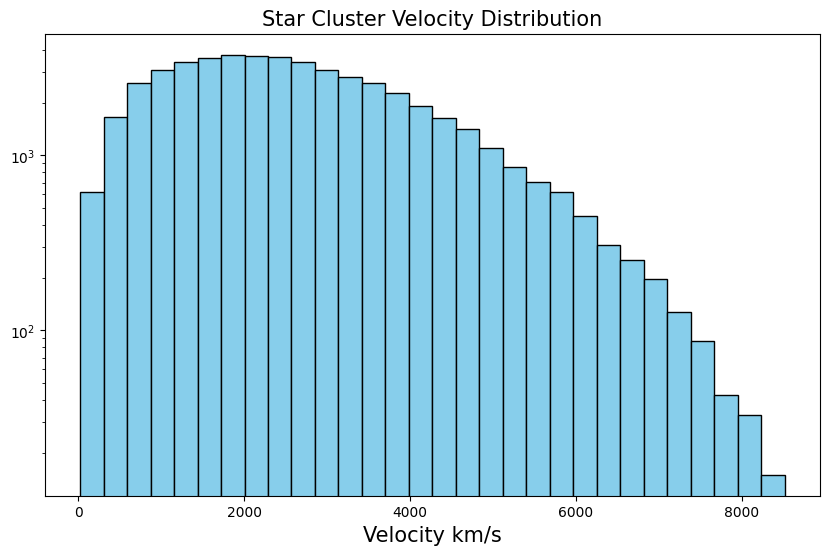

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df_stars['v_mag'], bins=30, color='skyblue', edgecolor='black',log = True)
#plt.xlim(0, 4) 
plt.title('Star Cluster Velocity Distribution',fontsize = 15)
plt.xlabel('Velocity km/s',fontsize = 15)
#plt.ylabel('Velocity km/s',fontsize = 15)
plt.show()

**TO BE CONTINUED...**

First plotting the stars in a coordinate system

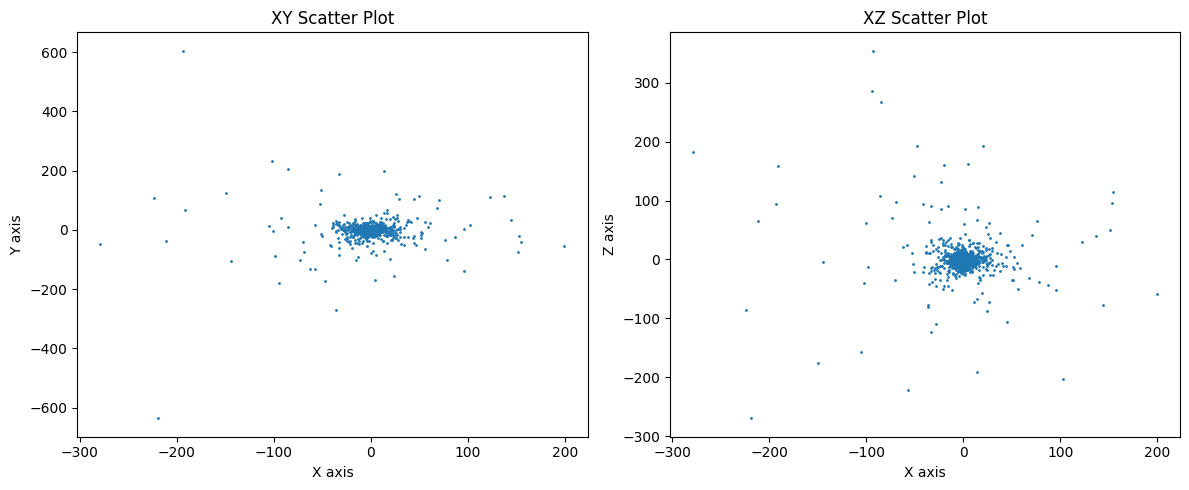

In [10]:
import matplotlib.pyplot as plt

# Assuming df_stars is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for XY plane
axes[0].scatter(df_stars['x'], df_stars['y'], s=1)
axes[0].set_xlabel('X axis')
axes[0].set_ylabel('Y axis')
axes[0].set_title('XY Scatter Plot')

# Scatter plot for XZ plane
axes[1].scatter(df_stars['x'], df_stars['z'], s=1)
axes[1].set_xlabel('X axis')
axes[1].set_ylabel('Z axis')
axes[1].set_title('XZ Scatter Plot')

plt.tight_layout()
plt.show()

In [ ]:
#Interactive 3d one, but it lags crazy
# Assuming df is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names
#fig = px.scatter_3d(df_stars, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 1,width = 1000,height = 500)

# You can customize the labels for each axis
#fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))

# Show the interactive plot
#fig.show()

### Fitting the hernquist profile

First let's define Hernquist profile for the system. We can get the total mass for the system, since the data for that is given. The r is a variable in my control also. What is unknown is the scale factor a which I will get once I fit the profile to empirical data. Fot that I will use scipy's curve_fit.

"curve_fit" uses a nonlinear least-squares algorithm to minimize the difference between the observed y-data and the values predicted by the user-defined function. It adjusts the parameters iteratively to minimize the sum of the squared residuals (the squared differences between the observed and predicted values).

The hernquist profile is defined as follows


### $\rho(r) = \frac{M_{tot}}{2 \cdot \pi} \frac{a}{r} \frac{1}{(r+a)^3} \quad[\frac{M_{\odot}}{{pc}^3}]$

Since the total mass is fixed the only unknown will be the scale radius a

In [18]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
print(f'Total mass of the system is {total_mass} M_sol')

Total mass of the system is 4622219.259 M_sol


In [19]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
print(f'Total mass of the system in solar masses: {total_mass}')
def hernquist_profile_fixed_M(r, a):
    return 4622219.259/ (2 * np.pi) * (a / r) * (1/(r + a)**3)

def log_hernquist_profile_fixed_M(r, a):
    log_rho = np.log10(4622219.259/(2*np.pi)) + np.log10(a) - np.log10(r) - 3*np.log10(r+a)
    return log_rho

Total mass of the system in solar masses: 4622219.259


To get the first quess fot the hernquist profile scale radius I will use the half mass formula from the hernquist profile:

## $r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

Since all the stars in this system have same masses, the half mass radius is straight forward. I will find the radius where the radius is when around 25005 stars are left.

In [15]:
r_half = 0.18874
f_df_stars = df_stars[df_stars['distance'] <= r_half]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.500500e+04  25005.000000  25005.000000  25005.000000  25005.000000   
mean   9.242590e+01     -0.000367      0.000006     -0.000435      2.822476   
std    2.087616e-11      0.057361      0.056588      0.056842   2192.670435   
min    9.242590e+01     -0.185048     -0.184957     -0.185508  -7231.980000   
25%    9.242590e+01     -0.031586     -0.030978     -0.031469  -1478.490000   
50%    9.242590e+01     -0.000219      0.000088     -0.000340      1.957230   
75%    9.242590e+01      0.030804      0.031566      0.030747   1486.950000   
max    9.242590e+01      0.187356      0.185406      0.184472   7525.940000   

                 vy            vz         v_mag      distance  
count  25005.000000  25005.000000  25005.000000  25005.000000  
mean       8.298934      3.762507   3503.480347      0.085063  
std     2212.636519   2178.371775   1474.480638      0.049877  
min    -7930.760000  -7952.250000    111.380143      0.000366  
25%    -1496.320000  -1457.980000   2412.007132      0.042932  
50%        9.200410      7.494210   3394.668592      0.079029  
75%     1505.600000   1472.740000   4483.275093      0.123677  
max     7874.570000   7595.740000   8518.785337      0.188707

So this brute force half mass radius seems to be around 0.18874 $pc$ from this the a will be

In [11]:
a_guess = r_half / ( 1 + np.sqrt(2))
print(f'a_guess is {a_guess}')

a_guess is 0.07817866776229795


First lets look at the distribution of stars

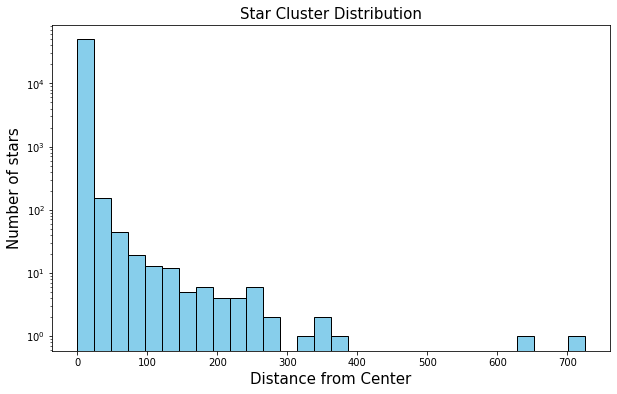

In [21]:
# Assuming 'star_df' is your DataFrame with columns 'x', 'y', 'z'
# Calculate the distance of each star from the center (middle) of the cluster
# Create a histogram of the distances
plt.figure(figsize=(10, 6))
plt.hist(df_stars['distance'], bins=30, color='skyblue', edgecolor='black',log = True)
#plt.xlim(0, 4) 
plt.title('Star Cluster Distribution',fontsize = 15)
plt.xlabel('Distance from Center',fontsize = 15)
plt.ylabel('Number of stars',fontsize = 15)
plt.show()

PLot the observed data density and its radial dependence with linear binning

/scratch/tmp.44815000.atepper/ipykernel_125112/785078647.py:24: RuntimeWarning:

divide by zero encountered in divide



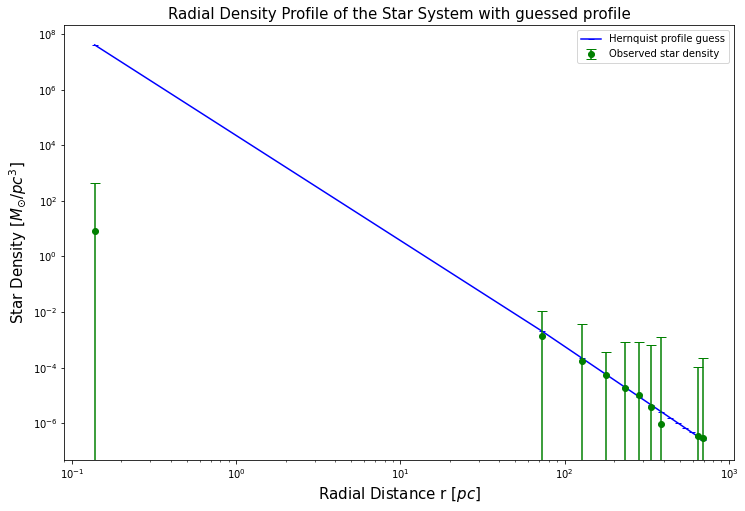

In [29]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

#bins = np.logspace(np.log(np.min(radial_distances)), np.log(np.max(radial_distances)), 50)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)
#bin_centers = (bin_edges[:-1] + bin_edges[1:])/ 2#averae
bin_centers = (bin_edges[:-1] * bin_edges[1:])**0.5 # gemetric
#find the denisty of stars in solar_masses per cubic parsec
# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 

#Guessef fixed mass profile
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_centers, a_guess)

#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero

plt.figure(figsize=(12, 8))
# Plot the radial density profile with logarithmic bins
plt.plot(bin_centers, fixed_M_fitted_profile, marker='_',label='Hernquist profile guess', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_centers,star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 15)
plt.show()

Using the a guess falls in to the error bars for the outer stars, but the profile has problems near center. Maybe because of binning.

Doing the same with logspace binning


In [30]:
# define radial distances
radial_distances = df_stars["distance"]
N_stars = df_stars.shape[0]
# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)
#log_bins = np.logspace(np.log10(0.1), np.log10(200), 25)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)
#bin_centers = (bin_edges[:-1] + bin_edges[1:])/ 2 #average

bin_centers = (bin_edges[:-1] * bin_edges[1:])**0.5 # gemetric
# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
# Star mass
lone_star_mass = df_stars["mass"].values[0]
# Calculate star density in each shell
star_density = hist*lone_star_mass / shell_volumes 
star_denisty_err = (lone_star_mass/shell_volumes)*(1/np.sqrt(N_stars))

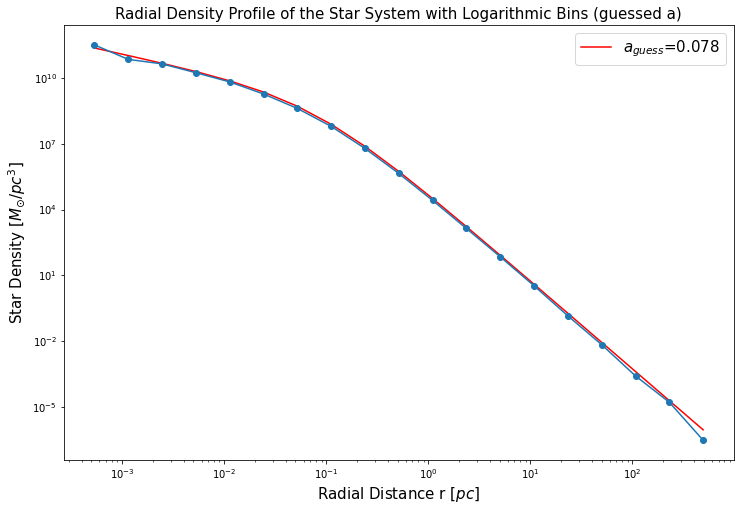

In [31]:
#centered_bins
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_centers, a_guess)
#fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], 0.0778)
#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_centers, fixed_M_fitted_profile, label='$a_{guess}$'+f"={np.round(a_guess,3)}", color='red')

# Plot the radial density profile with logarithmic bins
plt.plot(bin_centers, star_density, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (guessed a)', fontsize = 15)
plt.show()

Now try to fit the profile

For error

It is known that:

## $\frac{\Delta \rho}{\rho} \propto \frac{\Delta n}{n}$

## $\Delta \rho = |\frac{\partial \rho}{\partial n}| \Delta n$

From poissonian error , where $\frac{\partial \rho}{\partial n} = \frac{M}{V}$

## $\Delta n = \frac{1}{\sqrt{n}}$

Hence 

$\Delta \rho = \frac{M}{V} \cdot \frac{1}{\sqrt{n}} $

fixed mass profile scaling radius a value:0.07891396642126057 and pcov: 7.50771873745585e-16


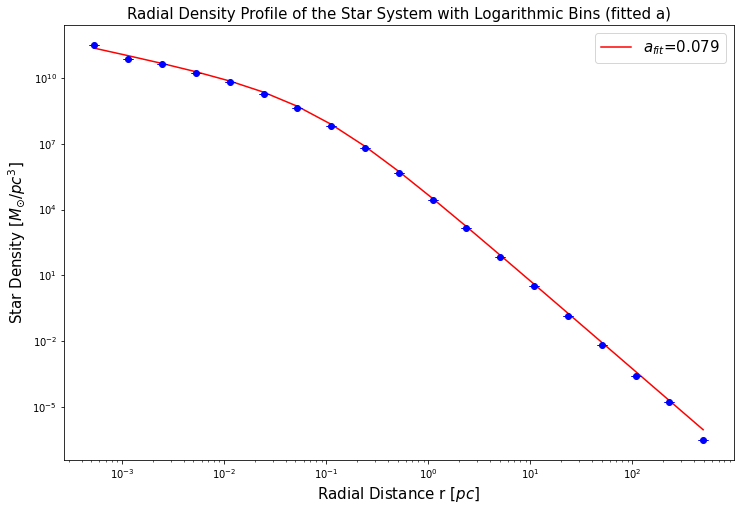

In [32]:
#start, end = 2, -2
#
error = star_denisty_err

#center binning with geometric mean
#a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_centers[start:end], star_density[start:end], p0=a_guess,sigma = star_denisty_err[start:end],absolute_sigma = True)
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_centers, star_density, p0=0.07,sigma = star_denisty_err, absolute_sigma = True)
#a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,sigma = sigma, p0=a_guess, absolute_sigma = True)
print(f'fixed mass profile scaling radius a value:{a_fit[0]} and pcov: {pcov[0][0]}')


fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_centers, a_fit)
log_hernquist_profile_fixed_M = log_hernquist_profile_fixed_M(bin_centers, a_fit)

#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_centers, fixed_M_fitted_profile, label='$a_{fit}$'+f"={np.round(a_fit[0],3)}", color='red')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (fitted a)', fontsize = 15)
plt.errorbar(bin_centers ,star_density, yerr=(error), fmt='o', capsize=5,label='Observed star density', color='blue')
plt.show()

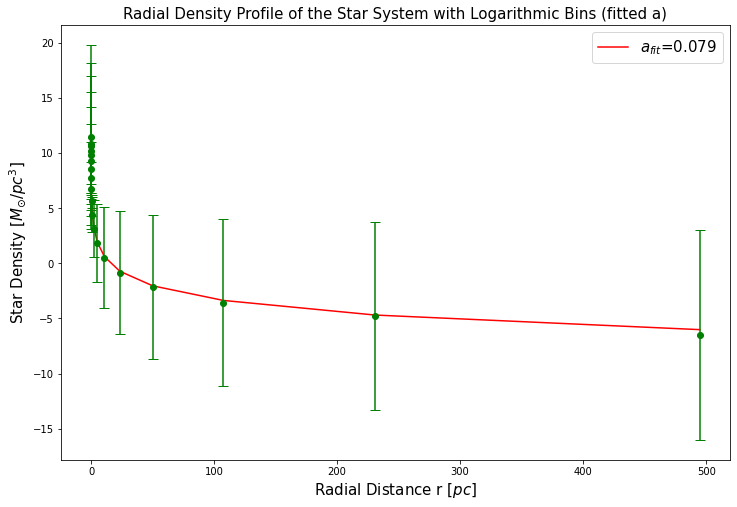

In [33]:
#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_centers, log_hernquist_profile_fixed_M, label='$a_{fit}$'+f"={np.round(a_fit[0],3)}", color='red')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (fitted a)', fontsize = 15)
plt.errorbar(bin_centers ,np.log10(star_density), yerr=np.log10(error), fmt='o', capsize=5,label='Observed star density', color='green')
plt.show()

Comparing a fit and a guess:

In [34]:
print(f'Guessed a value: {a_guess} and fitted a value: {a_fit}')

Guessed a value: 0.07817866776229795 and fitted a value: [0.07891397]


In [21]:
pcov

array([[7.50771874e-16]])

Fitting with taking bins that exclude the rightmost edge

### N-body forces

Compute the direct N-Body forces between particles (note that the array potential[i] is not
needed for this purpose). Start by assuming a softening of the order of the mean interparticle
separation in the system, then repeat the force calculation by experimenting with different
values of the softening and discuss your results.

The mean interparticle separation in the system should be calculated inside the half-mass radius 

$r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

In [35]:
a_fit

array([0.07891397])

In [36]:
(1 + np.sqrt(2))*0.3

0.7242640687119285

In [37]:
r_half = (1 + np.sqrt(2))*a_fit
print(f'fitted half mass radius: {r_half} [pc]')

fitted half mass radius: [0.19051517] [pc]


In [25]:
f_df_stars = df_stars[df_stars['distance'] <= r_half[0]]
#f_df_stars = df_stars[df_stars['distance'] <= r_half]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.513000e+04  25130.000000  25130.000000  25130.000000  25130.000000   
mean   9.242590e+01     -0.000381      0.000020     -0.000358      0.289044   
std    2.005191e-11      0.057690      0.056972      0.057272    143.716673   
min    9.242590e+01     -0.187188     -0.187796     -0.187676   -474.328986   
25%    9.242590e+01     -0.031752     -0.031079     -0.031517    -96.826804   
50%    9.242590e+01     -0.000230      0.000078     -0.000297      0.151453   
75%    9.242590e+01      0.030936      0.031690      0.030960     97.684035   
max    9.242590e+01      0.189057      0.187283      0.186398    493.609148   

                 vy            vz         v_mag      distance  
count  25130.000000  25130.000000  25130.000000  25130.000000  
mean       0.582126      0.224985    229.602055      0.085583  
std      145.011359    142.729960     96.622406      0.050294  
min     -520.160364   -521.569844      7.305168      0.000366  
25%      -98.006891    -95.537022    158.090850      0.043100  
50%        0.651369      0.472806    222.462275      0.079415  
75%       98.594557     96.486896    293.813789      0.124386  
max      516.474991    498.187170    558.727597      0.190504

### Estimating the mean inter-particle distance

Now I try to find the mean separation within the half mass radius. I have 2 options here for that One is using scipy and the other is a brute force one. First extract coordinates and then find the coordinates. After that test both methods on some subset, because it is also N*N problem

First extract coordinates and then find the coordinates

In [24]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'

star_cluster_df = f_df_stars[["x","y","z"]]

# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['x', 'y', 'z']].values, metric='euclidean')

# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_scipy = non_diagonal_distances.mean()
mean_distance_scipy = distance_matrix.mean()

print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

Mean Distance between particles (scipy): 0.12648600594684864


In [25]:
#def euclidean_distance(point1, point2):
#    return np.sqrt(np.sum((point1 - point2)**2))
#
#def mean_distance(star_coordinates):
#    num_stars = len(star_coordinates)
#    total_distance = 0.0
#
#    for i in range(num_stars):
#        for j in range(i+1, num_stars):
#            total_distance += euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])
#
#    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
#    return mean_distance
#
## the half mass radius stars coordinates
#star_cluster_df = f_df_stars[["x","y","z"]][:1000]#using 1000 stars only. Otherwise will run until "forever"
#
#result = mean_distance(star_cluster_df)
#print(f"Mean distance between stars: {result}")

Using a brute force mean distance calculator is already cumbersome, so can't imagine what happens with the direct force calculation. But both algorithms gave same answer, but one should stick with the scipy one.

Looking at the data we see that the softening is 0.1. With the used scipy mean distance calculator gives 0.126 [pc].


**There is actually a third option of using a formula. When looking at the slides there is a formula used for mean-interparticle distance**

## $d = \left[ \frac{4 \pi R^3}{3 N_{stars}} \right]^{\frac{1}{3}}$

again what should be the r- Right now using the half-mass radius again

And it seems that the one that the formula gives is the correct one when used for the theory comparison

So the softening that my program found was 1 magnitude bigger than the formula. WHy?

In [13]:
n_stars = df_stars.shape[0]
n_stars = df_stars.shape[0]/2 #whuch one to use?
d_mean = ((4*np.pi*(r_half**3))/(3*n_stars))**(1/3)
print(f'Formula based mean inter-interparticle distance {d_mean}')

Formula based mean inter-interparticle distance 0.010404419814962651


So the order of the softening $\epsilon$ I will be using is on 0.01 or at scale $10^{-2}$

### The equations of motion

## $\ddot{\mathbf{r_i}} = -G \Sigma_{j=1}^{N} \frac{m_j}{[(\mathbf{r_i}-\mathbf{r_j})^2+\epsilon^2]^{\frac{3}{2}}}(\mathbf{r_i}-\mathbf{r_j})$


The equation contains a softening length $\epsilon$. The purpose of the force
softening is to avoid large angle scatterings and the numerical expense that would
be needed to integrate the orbits with sufficient accuracy in singular potentials.
Also, we would like to prevent the possibility of the formation of bound particle
pairs – they would obviously be highly correlated and hence strongly violate
collisionless behavior. We don’t get bound pairs if

### $\langle v^2 \rangle \gg \frac{Gm}{\epsilon}$.

which can be viewed as a necessary (but not in general sufficient) condition on
reasonable softening settings (Power et al., 2003). The adoption of a softening
length also implies the introduction of a smallest resolved length-scale. The specific
softening choice one makes ultimately represents a compromise between
spatial resolution, discreteness noise in the orbits and the gravitational potential,
computational cost, and the relaxation effects that adversely influence results.


**Softening and mean interparticle distance**

**Smoothing Over Real Features**: If the softening length is too large, it can artificially smooth out the gravitational forces, causing the simulation to miss small-scale structures and interactions. This is particularly problematic in regions with high particle density or during close encounters between particles.

**Impact on Orbits and Dynamics**: Large softening can lead to inaccurate representations of particle trajectories, especially in regions of strong gravitational gradients. Orbits may be artificially stabilized, and the simulation may not capture the correct details of tidal interactions and close encounters.

**Smaller Gravitational Softening**:

**Increased Computational Cost**: Using a very small softening length might increase the computational cost of the simulation, as the forces between particles need to be accurately computed over smaller scales. This can make the simulation more computationally demanding and time-consuming.

**Numerical Instabilities**: Excessively small softening lengths can lead to numerical instabilities and inaccuracies, as the simulation attempts to resolve forces on scales that are smaller than the inherent discreteness of the particle distribution. This may result in unphysical behaviors.

**Effect of Larger Softening on Relaxation Time**:

If the softening length is too large, it may suppress the effects of small-scale gravitational interactions, potentially slowing down the relaxation process. This can lead to an underestimation of the true relaxation time

**Effect of Smaller Softening on Relaxation Time**:

Using a very small softening length may allow the simulation to more accurately capture small-scale interactions. However, it can also lead to an increase in computational cost. The relaxation time might be more accurately represented, but the overall simulation time may be longer.

### Direct force calculation algorithms

This is a NxN problem, which means it will get very computationally intensive. I will create a sequential program and then also a parallel computational on to speed up the process if needed. For this I need the correct units in the end of course.

In [4]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force
# Function to calculate total force on each star
def calculate_total_force(stars, epsilon):
    forces = np.zeros((len(stars), 3))
    #loop over stars. i is the star for which the the force is calculated for
    for i in range(len(stars)):
        #print(i)
        for j in range(len(stars)):
            if i != j:
                force = calculate_force(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
                forces[i] += force

    return forces

Creating a parallel computing version based on toturial from https://www.youtube.com/watch?v=fKl2JW_qrso&t=56s&ab_channel=CoreySchafer

In [5]:
#Seems to work better.
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force

#def calculate_force_parallel_proc(i):
def calculate_force_parallel_proc(i):
    #if i % 1000 == 0:
    #   print(i)
    
    forces = np.zeros(3)
    for j in range(len(stars)):
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
        else: 
            forces += np.zeros(3)
        
    return forces 

def calculate_total_force_parallel_proc(stars, epsilon, num_workers=48):
    with ProcessPoolExecutor(max_workers = num_workers) as executor:
        nr_stars = range(len(stars))
        #results = executor.map(calculate_force_parallel_proc, nr_stars,[epsilon]*len(nr_stars))
        results = executor.map(calculate_force_parallel_proc, nr_stars)
    
    
    forces = np.array(list(results))
    
    return forces

Testing parallized and non parallized

In [48]:
#Check how many cores are available from euler
import os
import multiprocessing

# Get the number of CPU cores
num_cores = os.cpu_count()

# Alternatively, you can use multiprocessing module to get the number of available CPU cores
num_cores_mp = multiprocessing.cpu_count()

print(f"Number of CPU cores (os.cpu_count()): {num_cores}")
print(f"Number of CPU cores (multiprocessing.cpu_count()): {num_cores_mp}")
print(f"Number of CPU cores available (len(os.sched_getaffinity(0))): {len(os.sched_getaffinity(0))} ")

Number of CPU cores (os.cpu_count()): 128
Number of CPU cores (multiprocessing.cpu_count()): 128
Number of CPU cores available (len(os.sched_getaffinity(0))): 16 


In [28]:
epsilon = 0.003
stars = df_stars[:15000]

In [31]:
##Secquential one
#
## Record start time
#start_time = time.time()
#forces = calculate_total_force(stars, epsilon)
## Record end time
#end_time = time.time()
## Calculate and print the elapsed time
#elapsed_time = end_time - start_time
#
## Data to be saved
#forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces}
#
## Save data to a pickle file
##with open('./created_data/forces_50k.pkl', 'wb') as file:
##    pickle.dump(forces_and_time, file)
#
#print(f"Elapsed time: {elapsed_time} seconds")

Using multiple cores now

In [19]:
#the multiprocessing one

# Record start time for processes
start_time = time.time()
forces_parallel_proc = calculate_total_force_parallel_proc(stars, epsilon)
# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time


#Data to be saved
forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces_parallel_proc}

#Save data to a pickle file
#with open('./created_data/forcerrs_50k.pkl', 'wb') as file:
#    pickle.dump(forces_and_time, file)


print(f"Elapsed time for multiple processes: {elapsed_time} seconds")

Elapsed time for multiple processes: 416.70295763015747 seconds


In [ ]:
# Load data from the pickle file
with open('./created_data/forces_50k.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

elapsed_time = loaded_data["elapsed_time"]/60 #to minutes
print(f"Elapsed time: {elapsed_time} minutes")

### Direct force calculation and its dependance on softening

So in total 95 minutes for full 50 k stars direct summation with the parallel example. With the sequential one it would be in order of days.


To check the direct summation I should use newton's second theorem for spherical potentials, where I can describe a star's resultant force at the edges of spherical shells. The formula:

$\vec{F(r)} = \frac{GM(r)}{r^2}\vec{r}$

describes the resultant force at a star that is on the edge of the spherical shell, where all the mass $M(r)$ is "depicted" as in the center of the shell with distance $r$


Besides just checking the force results I should also vary the softening $\epsilon$. 

Since I am calculating only for one object, define a force calculator just for one selected star

In [62]:
def calculate_force_lone_star(i,stars,epsilon,indeces):    
    forces = np.zeros(3)
    for j in indeces:
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
    return forces

Theory comparison with 2 formulas which should give same answers

$\vec{F(r)} = \frac{GM(r)}{r^2}\vec{r}$

For $M(r)$ 3 options:

a) use the formula contained in the Hernquist paper

$M(r) = M_{tot}\frac{r^2}{(r+a)^2}$

In [63]:
def theory_force_mag_a(distance_r,a_fit):
    #takes into account the total mass within a radius
    #and the distance of the star
    #hernquist_profile_fixed_M(distance_r, a_guess) #take rho with the hernquist profile
    star_m = 92.4259
    mass_r = 4622219.259*((distance_r**2)/(distance_r+a_fit)**2)# find the mass within r

    force = mass_r/(distance_r**2)*star_m
    
    return force

b) or from the book

$M(r) = 4\pi \int_{0}^{r}r^2 \rho(r)dr $

where $\rho(r)$ is the Hernquist profile:

$\rho(r) = \frac{M_{tot}}{2 \cdot \pi} \frac{a}{r} \frac{1}{(r+a)^3}$

c) Find the $M(r)$ from data

In [34]:
def theory_force_mag_b(distance_r, a_fit):
    #takes into account the total mass within a radius
    #and the distance of the star
    #hernquist_profile_fixed_M(distance_r, a_guess) #take rho with the hernquist profile
    star_m = 92.4259
    mass_r, _ = quad(lambda x: hernquist_profile_fixed_M(x, a_fit) * 4 * np.pi * x**2, 0, distance_r)# find the mass within r

    force = mass_r/(distance_r**2)*star_m
    
    return force

c) Find the $M(r)$ from data directly. Meaning, using the mass enclosed at a radius r

In [35]:
def theory_force_mag_c(df,distance_r):
    star_m = 92.4259
    #by brute force find the mass in a shell
    nr_stars  = df[df['distance'] <= distance_r].shape[0]
    mass_r = nr_stars*star_m
    force = mass_r/(distance_r**2)*star_m
   
    return force

In [ ]:
#radius of shells and amount of stars for understanding how much computation needed
0.02 pc 2000 stars
0.06 pc 9000 k stars
0.1 pc 16 k stars
0.14 pc 20 k stars
0.18 pc 25 k stars
0.22 pc 27 k stars

From each radius I will find the furthest star which will be the test particle for both theoretical and numerical force magnitude on a star.

In [34]:
distances = [0.02,0.06,0.1,0.14,0.18,0.22]
epsilons = [0.0001,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.1,0.126]
#epsilons = [0.0001,0.001,0.002]
#epsilons = [0.008,0.08,0.085,0.09,0.095,0.1,0.15,0.126,0.13,0.15,2,2.5]

In [54]:
#now filter spheres with the distances
dfs_stars = []
for dist in distances:
    #print(dist)
    subset_df_stars = df_stars[df_stars['distance'] <= dist]
    dfs_stars.append(subset_df_stars)
    

In [55]:
def hernquist_profile_fixed_M(r, a):
    return 4622219.259/ (2 * np.pi) * (a / r) * (1/(r + a)**3)

As the epsilon reaches zero it should converge to the theoretical result. Tweaking the a_fit by hand the best I found is $\epsilon =0.0778 $
So the true a_fit should be there?

In [56]:
num_mags_list = [] #numerical magnitudes list of listsat each star
theor_mags_list_a = [] #theoretical magnitudes list  at each star
theor_mags_list_b = []
theor_mags_list_c = []
distance_r_list = [] #list for the test star distance
star_m = 92.4259
df_num_mags = pd.DataFrame()
for f_stars in dfs_stars:
    num_mags = []#numerical magnitudes list with different epsilons
    
    #find location of the star
    distance_r = max(f_stars["distance"]) #the furthest distance of star in that shell
    distance_r_list.append(distance_r)
    org_index = f_stars.loc[f_stars["distance"] == distance_r].index[0] #find its index
    indeces = f_stars.index.tolist() #get the list of indeces since these are now filtered
    #print(indeces)
    #theoretical force magnitude at the star
    total_mass = f_stars["mass"][org_index]*len(indeces)
    
    #from hernquist
    theor_mag_a = theory_force_mag_a(distance_r, a_fit)
    theor_mags_list_a.append(theor_mag_a)
    
    #from book
    theor_mag_b = theory_force_mag_b(distance_r, a_fit)
    theor_mags_list_b.append(theor_mag_b)
    
    #from data
    theor_mag_c = theory_force_mag_c(f_stars,distance_r)
    theor_mags_list_c.append(theor_mag_c)
    #print(f"total mass: {theor_mags_list_c}")
    
    for epsilon in epsilons:
        
        
        #numerical magnitudes
        lone_star_forces = calculate_force_lone_star(org_index,f_stars,epsilon,indeces) #calculate lone star forces
        lone_star_forces = lone_star_forces*star_m
        lone_star_force_mag = np.sqrt(lone_star_forces[0]**2+lone_star_forces[1]**2+lone_star_forces[2]**2) #get magnitude
        num_mags.append(lone_star_force_mag)
    
    num_mags_list.append(num_mags)
    df_num_mags[f'radius={distance_r}'] = num_mags

Now try to plot these forces at each radius with both numerical and theoretical values

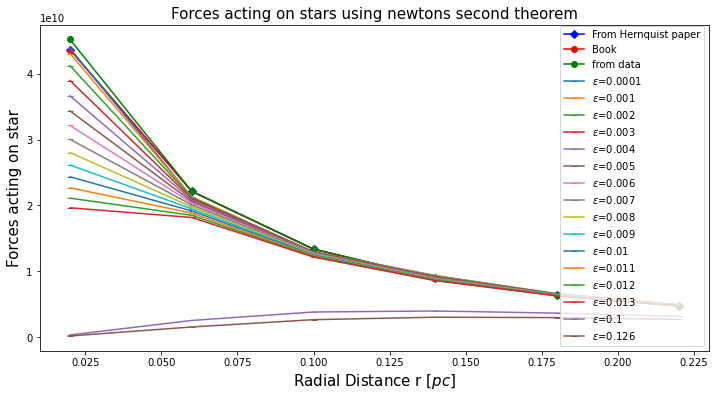

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(distance_r_list, theor_mags_list_a, marker='D',label='From Hernquist paper', color='blue')
plt.plot(distance_r_list, theor_mags_list_b, marker='o',label='Book', color='red')
plt.plot(distance_r_list, theor_mags_list_c, marker='o',label="from data", color='green')
#for i,distance_r in enumerate(distance_r_list):
for i,epsilon in enumerate(epsilons):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags.loc[i].values, marker='_',label=f'$\epsilon$={epsilon}')
plt.legend(loc='lower right')
plt.xlabel('Radial Distance r $[pc]$',fontsize = 15)
plt.ylabel('Forces acting on star', fontsize = 15)
plt.title('Forces acting on stars using newtons second theorem', fontsize = 15)
plt.show()

So scaling and shape is similar so i think I am on right track. The profile is decreasing as expected with $1/r^2$

As the epsilon is decreasing it is converging to a result. The convergence line should indicate what the theory should show.

But when describing the effects of the epsilon we see that the epsilon starts to lose its significance as the distance grows. The softening lengths is needed to avoid bound pairs which could happen in a more dense regions which is in the middle and indeed the plot shows the larger the epsilon the more mitigation of forces in denser regions.

### Computation of relaxation timescale

Compute the relaxation timescale of the numerical model given the number of particles and the
physical crossing timescale (use the half-mass radius Rhm and the circular velocity computed
at the half-mass radius, 

$v_c =\sqrt{\frac{GM(R_{half})}{R_{half}}}$ 


Relaxation timescale is defined as

$t_{relax} = \frac{N_{stars}}{8 \ln{N_{stars}}}t_{cross}$

where $N_{stars}$ is the number of stars conatined in the cluster

$t_{cross}$ is the typical timescale rquired by particle to travel through the system on a straight trajectory and defined as

$t_{cross} = \frac{R_{half}}{V_{c}}$

Is it though $R_{half}$ in the numerator for the t_cross?

In [249]:
r_half

0.19051516799486226

In [256]:
#OG
#r_half = r_half[0]
m_half = df_stars[df_stars['distance'] <= r_half].shape[0]*df_stars["mass"].values[0]# stars within half_mass times mass
N_stars = df_stars.shape[0]/2 #number of stars
def t_relax_f(N_stars,t_cross):
    t_relax =((N_stars)/(8*np.log(N_stars)))*(t_cross)
    return t_relax

def t_cross_f(r_half,m_half):
    v_c = np.sqrt((G*m_half*1.989*10**30)/(r_half*3.086*10**16))
    print(f'v_c = {v_c/1000} km/s')
    t_cross = r_half*3.086*10**16/v_c
    return t_cross

t_cross = t_cross_f(r_half,m_half)
t_relax = t_relax_f(N_stars,t_cross)
print(f'The numerical model crossing timescale: {t_cross/3.154e7} yr ')
print(f'The numerical model relaxation timescale: {t_relax/3.154e7/10**6} Myr')

v_c = 229.00797256955283 km/s
The numerical model crossing timescale: 813.9789780170685 yr 
The numerical model relaxation timescale: 0.2512328903383464 Myr


Calculating relaxation timescale

In [222]:
#G = 1
#r_half = r_half[0]
m_half = df_stars[df_stars['distance'] <= r_half].shape[0]*df_stars["mass"].values[0]# stars within half_mass times mass
N_stars = df_stars.shape[0]/2 #number of stars
def t_relax_f(N_stars,t_cross):
    t_relax =(N_stars)/(8*np.log(N_stars))*(t_cross)
    return t_relax

def t_cross_f(r_half,m_half):
    v_c = np.sqrt((1*m_half)/(r_half))
    t_cross = r_half/v_c
    return t_cross

t_cross = t_cross_f(r_half,m_half)
t_relax = t_relax_f(N_stars,t_cross)
print(f'The numerical model crossing timescale: {t_cross*t_coeff/3.154e7} yr')
print(f'The numerical model relaxation timescale: {t_relax*t_coeff/3.154e7/10**6} Myr' )

The numerical model crossing timescale: 813.9789780170685 yr
The numerical model relaxation timescale: 0.2512328903383464 Myr


Keeping in mind how the relaxation time
formula is derived: 

**Do you expect varying the value of the gravitational softening to change the
relaxation timescale?** 

**In particular, do you expect it to increase or decrease if the softening is
increased above the interparticle separation? Can you explain why?**

$t_{relax} = \frac{N_{stars}}{8 \ln{\Lambda}}t_{cross}$

$\ln{\Lambda}=\ln\frac{b_{max}}{b_{min}} $

$b_{max} \approx R_{cluster}$

$\frac{2Gm}{b_{min}v} \approx v$ $b_{min}$describes the  length at where transverse velocity perturbation becomes as large as the velocity

Increasing the softening makes $b_{min}$ to decrease. So the strong impacts become more rare. Hence the relaxation time increases

**Examples of relaxation times**

A system can be viewed as collisonless when $t_{relax} >> t_{age}$ 

for globular clusters

$t_{relax} \approx 100$ Myr

for open cluster

$t_{relax} \approx 10$ Myr

## Tree code 

Compute the force on particles (a subset of them would be fine) using multipole expansion
(tree-code). For multipole calculation decide on a criterion (distance based) to group particles,
eventually experimenting with different orders of the expansion. Finally, compare the tree-code
result with the direct summation result, in terms of accuracy as well as computational cost. Try
different softenings for the direct summation and different opening angles for the tree-code.

Particle located at $\mathbf{r}$  
Group of particles with COM located at $\mathbf{s}$  
Particles of the group are located at $\mathbf{x}_i$   

Aperture of group (what angle spans the group): $\theta \rightarrow$ (small if group is far, big otherwise)

$y = | \mathbf{r} - \mathbf{s}|$ is distance between group and particle 

$l = | \langle \mathbf{x}_i - \mathbf{s} \rangle |$ is the average distance between the group's particles and its COM

Potential of a group is defined by:  
$\Phi(\mathbf{r}) = -G \sum_i \frac{m_i}{|\mathbf{r}-\mathbf{x}_i|} = -G \sum_i \frac{m_i}{|\mathbf{r}-\mathbf{s}+\mathbf{s}-\mathbf{x}_i|}$. 

If opening angle is small enough: $\theta \approx l/y \ll 1$, then $l \ll y$. 

This means that both $l = | \langle \mathbf{x}_i - \mathbf{s} \rangle |$ and $\theta$ are small enough and we can expand in the denominator

$\frac{1}{|\mathbf{y}+\mathbf{s}-\mathbf{x}_i|} = \frac{1}{|\mathbf{y}|} - \frac{\mathbf{y} \cdot (\mathbf{s}-\mathbf{x}_i)}{|\mathbf{y}|^3} + \frac{1}{2} \frac{\mathbf{y}^T[ 3(\mathbf{s}-\mathbf{x}_i)(\mathbf{s}-\mathbf{x}_i)^T - (\mathbf{s}-\mathbf{x}_i)^2 ]\mathbf{y}}{|\mathbf{y}|^5}$

The 3 terms are known as monopole, dipole and quadrupole. The dipole term disappears if when the expansion is done in the COM frame.

Monopole:  
$M = \sum_i m_i$  
Quadrupole  
$Q_{ij} = \sum_{k}^{m_k}[3(\mathbf{s}-\mathbf{x}_k)_i(\mathbf{s}-\mathbf{x_k})_j- \delta_{ij}(\mathbf{s}-\mathbf{x}_k)^2]$


$\rightarrow \Phi(\mathbf{r}) = -G \Big( \frac{M}{|\mathbf{y}|} + \frac{1}{2}\frac{\mathbf{y}^T \mathbf{Q} \mathbf{y}}{|\mathbf{y}|^5} \Big)$

Good visual explaining the tree code main idea https://jheer.github.io/barnes-hut/ and change of angle

First let's do a force calculation with the stars with the direct force calculation or monopole

$\nabla\Phi(\mathbf{r})  \rightarrow\vec{a} =  \frac{G \cdot M}{|\vec{y}|^3}\vec{y}$

In [38]:
radius = 0.0055
df_stars_sub = df_stars[df_stars['distance'] <= radius]
df_stars_sub.describe()

mass           x           y           z          vx  \
count  2.130000e+02  213.000000  213.000000  213.000000  213.000000   
mean   9.242590e+01   -0.000051    0.000206   -0.000076    4.011309   
std    1.424433e-13    0.002324    0.002162    0.002238  120.132889   
min    9.242590e+01   -0.005187   -0.005311   -0.005240 -355.269589   
25%    9.242590e+01   -0.001681   -0.001115   -0.001673  -78.299261   
50%    9.242590e+01    0.000153    0.000106    0.000080   -4.550383   
75%    9.242590e+01    0.001658    0.001654    0.001547   93.800259   
max    9.242590e+01    0.005113    0.005348    0.005233  267.097411   

               vy          vz       v_mag    distance  
count  213.000000  213.000000  213.000000  213.000000  
mean    13.995460   18.588131  194.118955    0.003653  
std    127.436304  119.355844   87.280795    0.001313  
min   -329.746133 -342.656417   27.692529    0.000366  
25%    -64.049347  -55.430204  128.147648    0.002592  
50%     21.013908   14.911300  179.806257    0.003771  
75%     94.074416   87.105722  257.593122    0.004762  
max    366.602489  412.570945  433.640149    0.005470

### Tree code

based on https://mikegrudic.wordpress.com/2017/07/11/a-simple-and-pythonic-barnes-hut-treecode/

In [3]:
import numpy as np
 
def TreeWalk(node, node0, thetamax=0.7, G=1.0): #parent node, the leaf you are describing, maximum opening angle, Gravitational constant
    
    """
    The force calculation with the tree then proceeds by walking the tree. Starting at
    the root node, one checks for every node whether the opening angle under which
    it is seen is smaller than a prescribed tolerance angle
    Adds the contribution to the field at node0's point due to particles in node.
    Calling this with the topnode as node will walk the tree to calculate the total field at node0.
    """
    dx = node.COM - node0.COM    # vector between nodes' centres of mass
    r = np.sqrt(np.sum(dx**2))   # distance between them
    #node.size is the radius a of sphere 
    if r > 0: #eliminating cases where the same nodes or with itself
        
        # if the node only has one particle or theta is small enough,
        #  add the field contribution to value stored in node.g
        if (len(node.children)==0) or (node.size/r < thetamax):
            node0.g +=  G * (node.mass)*dx/r**3#G * (node.mass) * dx/r**3#   This is a monopole contribution Is it though? This should be: G * (node.mass)*dx/r**1.5
        else:
            #So if the angle is too big or more than one particle ( not a leaf)
            # start the walk again going over the nodes children
            #So conduct a treewalk over recursevly
            for c in node.children: TreeWalk(c, node0, thetamax, G)

In [4]:
class TreeNode:
    """Creates a node that contains each nodes charecteristics like: it location, size of box, children (as other nodes),
       Center of Mass, id of node and the acceleration (forces) acting on the star(leaf) of interest.
       The general build of a tree is made of 8 subsections (octants). Those octants which contain particles are saved. Otherwise
       ignored (not saved)"""
    def __init__(self, center, size, masses, points, ids, leaves=[]):
        self.center = center                    # center of the node's box
        self.size = size                        # maximum side length of the box
        self.children = []                      # start out assuming that the node has no children
 
        Npoints = len(points)                   #Get the number of stars within node
 
        if Npoints == 1:
            # if we're down to one point, then can store info
            leaves.append(self) #add this to the global list of children
            self.COM = points[0] # nodes center of mass coordinates
            self.mass = masses[0] # nodes mass
            self.id = ids[0]    # nodes id
            self.g = np.zeros(3)        # at each point, we will want the gravitational field
        else:
            self.GenerateChildren(points, masses, ids, leaves)     # if we have at least 2 points in the node,
                                                                   # spawn its children and the process continues recursevly
 
            # now we can sum the total mass and center of mass hierarchically, visiting each point once!
            com_total = np.zeros(3) # running total for mass moments to get COM
            m_total = 0.            # running total for masses
            for c in self.children:
                m, com = c.mass, c.COM #every childrens 
                m_total += m
                com_total += com * m   # add the moments of each child
            self.mass = m_total
            self.COM = com_total / self.mass  
 
    def GenerateChildren(self, points, masses, ids, leaves):
        """Generating the nodes children is a tricky process where you have to determine carefully to which octant to spawn a 
           child"""
        octant_index = (points > self.center)  #does all comparisons needed to determine points' octants
        for i in range(2): #looping over the 8 octants
            for j in range(2):
                for k in range(2):
                    in_octant = np.all(octant_index == np.bool_([i,j,k]), axis=1)
                    if not np.any(in_octant): continue           # if no particles, don't make a node
                    dx = 0.5*self.size*(np.array([i,j,k])-0.5)   # offset between parent and child box centers
                    self.children.append(TreeNode(self.center+dx, #new center
                                                 self.size/2,    #new box size
                                                 masses[in_octant],
                                                 points[in_octant],
                                                 ids[in_octant],
                                                 leaves))
                    

I will make a version that also can calculate forces acting on a lone star 

In [5]:
def Tree_forces(df_stars, thetamax=0.7, G=1., lone_star = False, org_index = None,potential_cal = False):
    
    """Calculates the gravitational acceleration for stars
       If lone_star = True, then only the forces acting on a lone star with index = org_index 
       is calculated"""
    
    points = df_stars[["x","y","z"]].values #coordinates from the dataframe
    masses = df_stars["mass"].values  #masses from the dataframe
    
    #THis is not taking the center as just 000, but trying to find the real center using colosest and furthest stars
    center = (np.max(points,axis=0)+np.min(points,axis=0))/2       #center of bounding box
    topsize = np.max(np.max(points,axis=0)-np.min(points,axis=0))  #size of bounding box
    leaves = []  # want to keep track of leaf nodes . List of how many nodes with 1 star and the leaves are in the same order as the given datafram
    
    if potential_cal == True:
        print("use pot")
        
        indeces = np.arange(len(masses))
        print
        topnode = TreeNode(center, topsize, masses, points, indeces, leaves) #build the tree #the topnode gives you a whole tree
        pot = np.empty_like(points)
        #print(f'Amount of leaves created: {len(leaves)}')
        for i,leaf in enumerate(leaves): #iterate trough leaves
            TreeWalk_pot(topnode, leaf, thetamax, G)  # do field summation
            pot[leaf.id] = leaf.g  # get the stored acceleration 
        return pot
     
    
    
    #If lone star == False then the whole system is solved otherwise
    #only the star that the user is interested in org_index
    if lone_star == False: 
        print("tavaline")
        indeces = np.arange(len(masses))
        print
        topnode = TreeNode(center, topsize, masses, points, indeces, leaves) #build the tree #the topnode gives you a whole tree
        accel = np.empty_like(points)
        #print(f'Amount of leaves created: {len(leaves)}')
        for i,leaf in enumerate(leaves): #iterate trough leaves
            TreeWalk(topnode, leaf, thetamax, G)  # do field summation
            accel[leaf.id] = leaf.g  # get the stored acceleration 
        return accel
            
    else: 
        print("lone")
        #only for the star interested
        indeces = np.asarray(df_stars.index.tolist()) #original indeces from the original dataframe
        topnode = TreeNode(center, topsize, masses, points, indeces, leaves) #build the tree #the topnode gives you a whole tree
        #print(df_stars)
        #print(indeces)
        org_id_list = [leaf.id for leaf in leaves] #Leaves corresponding to the original index of stars
        index_of_org_id = org_id_list.index(org_index) #get the index int the leaves list of the corrseponding star
        leaf = leaves[index_of_org_id] #get the leaf object
        TreeWalk(topnode, leaf, thetamax, G) #Do the tree walk where the forces are calculated
        accel = leaf.g #resultant acc on the body

        return accel


I will do a potential calculator separetely to find the total potential of the system

In [6]:
def TreeWalk_pot(node, node0, thetamax=0.7, G=1.0): #parent node, the leaf you are describing, maximum opening angle, Gravitational constant
    #92.4259 mass
    """
    ###THIS IS NOW POTENTIAL CALCULATOR NOT THE FORCES TREE WALK  
    """
    dx = node.COM - node0.COM    # vector between nodes' centres of mass
    r = np.sqrt(np.sum(dx**2))   # distance between them
    #node.size is the radius a of sphere 
    if r > 0: #eliminating cases where the same nodes or with itself
        
        # if the node only has one particle or theta is small enough,
        #  add the field contribution to value stored in node.g
        if (len(node.children)==0) or (node.size/r < thetamax):
            node0.g +=  G * (node.mass)/(r) #monoole
        else:
            #So if the angle is too big or more than one particle ( not a leaf)
            # start the walk again going over the nodes children
            #So conduct a treewalk over recursevly
            for c in node.children: TreeWalk_pot(c, node0, thetamax, G)

In [45]:
df_examp_stars = df_stars[df_stars['distance'] <= 0.02]
df_examp_stars = df_examp_stars[10:1000] #10 stars with new indeces
df_examp_stars[:10]

mass         x         y         z          vx          vy  \
206  92.4259  0.001014  0.008747  0.005201  -59.969858 -289.575630   
234  92.4259  0.002199 -0.012381  0.003642  338.355831  117.980479   
355  92.4259  0.015466  0.008199  0.006916  168.268542 -297.055252   
379  92.4259 -0.012886  0.001221 -0.001638  245.057318  -45.167237   
390  92.4259  0.009304  0.004978  0.012954   33.638820  200.698384   
403  92.4259  0.003897 -0.000398  0.012613   87.635671 -145.067546   
405  92.4259  0.005965 -0.000032 -0.003690   72.568863 -146.996481   
407  92.4259 -0.014103  0.007821  0.003723  -39.381352 -170.356199   
421  92.4259 -0.001052 -0.001115  0.000224  -50.816306  -15.978740   
444  92.4259  0.001644 -0.000493 -0.005042   47.050325   62.435234   

             vz       v_mag  distance  
206   -6.468548  295.790925  0.010227  
234 -149.883652  388.418809  0.013091  
355  170.934026  381.804356  0.018821  
379 -174.109127  303.985454  0.013047  
390  148.299053  251.801550  0.016708  
403  234.680031  289.481123  0.013207  
405  -26.406595  166.046721  0.007014  
407   69.903378  188.304561  0.016550  
421  142.290563  151.934925  0.001549  
444 -161.920964  179.806257  0.005326

Test for furthest star

In [46]:
distance_r = max(df_stars["distance"])#find furthest
org_index = df_stars.loc[df_stars["distance"] == distance_r].index[0]#fint its index
print(org_index)

33830


In [47]:
org_index = 33830
#Tree code
lone_star_forces_tree = Tree_forces(df_stars, thetamax = 3, G = 1., lone_star = True, org_index = org_index)
#direct summation
f_stars = df_examp_stars
#org_index = f_stars.loc[f_stars["distance"] == distance_r].index[0] #find its index
indeces = df_stars.index.tolist() #get the list of indeces since these are now filtered
lone_star_forces_direct = calculate_force_lone_star(org_index,df_stars,0.001,indeces)
print(f'Calculation of forces on one star with tree code: {lone_star_forces_tree}')
print(f'Calculation of forces on one star with direct summation code: {lone_star_forces_direct}')

lone
Calculation of forces on one star with tree code: [2.66293008 7.72166086 3.27925277]
Calculation of forces on one star with direct summation code: [2.66296358 7.72119114 3.27909957]


Test the tree code vs the direct summation for one star

In [48]:
org_index = 390
#Tree code
lone_star_forces_tree = Tree_forces(df_examp_stars, thetamax = 0.5, G = 1., lone_star = True, org_index = org_index)
#direct summation
f_stars = df_examp_stars
#org_index = f_stars.loc[f_stars["distance"] == distance_r].index[0] #find its index
indeces = f_stars.index.tolist() #get the list of indeces since these are now filtered
lone_star_forces_direct = calculate_force_lone_star(org_index,f_stars,0.001,indeces)
print(f'Calculation of forces on one star with tree code: {lone_star_forces_tree}')
print(f'Calculation of forces on one star with direct summation code: {lone_star_forces_direct}')

lone
Calculation of forces on one star with tree code: [-1.25787607e+08 -8.83632503e+07 -1.91838893e+08]
Calculation of forces on one star with direct summation code: [-1.25112779e+08 -8.46954495e+07 -1.87100135e+08]


So looking at the results for my example stars, I get the same results. 

### Check results compared to theory

Now trying to calculate the forces on stars comparing tree code, direct summation and theory. Also should do an computation comparison

In [308]:
distances = [0.02,0.06,0.1,0.14,0.18,0.22]
epsilons = [0.0001,0.001,0.002,0.003,0.004,0.005]
opening_angles = [0.1,0.2,0.3,0.4,0.5, 0.6,1,2,3,4]
#epsilons = [0.008,0.08,0.085,0.09,0.095,0.1,0.15,0.126,0.13,0.15,2,2.5]

In [309]:
#now filter spheres with the distances
#create list of dataframes withing distances
dfs_stars = []
for dist in distances:
    #print(dist)
    subset_df_stars = df_stars[df_stars['distance'] <= dist]
    dfs_stars.append(subset_df_stars)

In [310]:
def hernquist_profile_fixed_M(r, a):
    return 4622219.259/ (2 * np.pi) * (a / r) * (1/(r + a)**3)

In [316]:
#numerical magnitudes at each star with direct summation
#num_mags_list_direct = [] 
df_num_mags_direct = pd.DataFrame()


#numerical magnitudes at each star with multipole expansion (tree code)
#num_mags_list_tree = [] #numerical magnitudes list of listsat each star
df_num_mags_tree = pd.DataFrame()

theor_mags_list_a = [] #theoretical magnitudes list  at each star
theor_mags_list_b = []
theor_mags_list_c = []

star_m = 92.4259# mass of a star

distance_r_list = [] #list for the test star distance
for f_stars in dfs_stars:
    num_mags_direct = []#numerical magnitudes list with different epsilons
    num_mags_tree = [] #numerical magnitudes list with different opening angles
    #find location of the star
    distance_r = max(f_stars["distance"]) #the furthest distance of star in that shell
    distance_r_list.append(distance_r)
    org_index = f_stars.loc[f_stars["distance"] == distance_r].index[0] #find its index
    indeces = np.asarray(f_stars.index.tolist()) #get the array of indeces since these are now filtered
    
    #theoretical force magnitude at the star
    total_mass = f_stars["mass"][org_index]*len(indeces)
    
    #from hernquist
    theor_mag_a = theory_force_mag_a(distance_r, a_fit)
    theor_mags_list_a.append(theor_mag_a)
    
    #from book
    theor_mag_b = theory_force_mag_b(distance_r, a_fit)
    theor_mags_list_b.append(theor_mag_b)
    
    #from data
    theor_mag_c = theory_force_mag_c(f_stars,distance_r)
    theor_mags_list_c.append(theor_mag_c)
    
    for epsilon in epsilons:
        
        
        #numerical magnitudes
        lone_star_forces = calculate_force_lone_star(org_index,f_stars,epsilon,indeces) #calculate lone star forces
        lone_star_forces = lone_star_forces*star_m
        lone_star_force_mag = np.sqrt(lone_star_forces[0]**2+lone_star_forces[1]**2+lone_star_forces[2]**2) #get magnitude
        num_mags_direct.append(lone_star_force_mag)
    

    df_num_mags_direct[f'radius={distance_r}'] = num_mags_direct
    
    #calculate tree code
    for angle in opening_angles:
    
        lone_star_forces = Tree_forces(f_stars, thetamax = angle, G = 1., lone_star = True, org_index = org_index) #calculate forces
        lone_star_forces = lone_star_forces*star_m
        lone_star_force_mag = np.sqrt(lone_star_forces[0]**2+lone_star_forces[1]**2+lone_star_forces[2]**2) #get magnitude
        num_mags_tree.append(lone_star_force_mag)
    df_num_mags_tree[f'radius={distance_r}'] = num_mags_tree
        

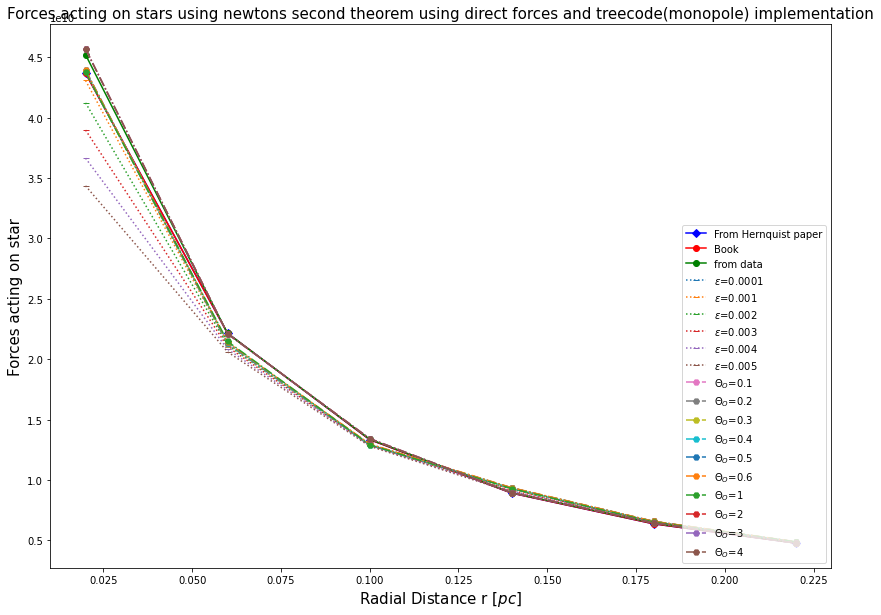

In [317]:
plt.figure(figsize=(14,10))
plt.plot(distance_r_list, theor_mags_list_a, marker='D',label='From Hernquist paper', color='blue')
plt.plot(distance_r_list, theor_mags_list_b, marker='o',label='Book', color='red')
plt.plot(distance_r_list, theor_mags_list_c, marker='o',label="from data", color='green')
#plt.plot(distance_r_list, theor_mags_list2, marker='o',label='Theory2', color='red')
#for i,distance_r in enumerate(distance_r_list):
for i,epsilon in enumerate(epsilons):
#    #plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags_direct.loc[i].values,linestyle=':', marker='_',label=f'$\epsilon$={epsilon}')
    
#tree code with different opening angles
for i,angle in enumerate(opening_angles):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags_tree.loc[i].values, linestyle='-.',marker='H',label=f'$\Theta_O$={angle}')
plt.legend(loc='lower right')
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Forces acting on star',fontsize = 15)
plt.title('Forces acting on stars using newtons second theorem using direct forces and treecode(monopole) implementation', fontsize = 15)
plt.show()

### Comparing computation time of algorithms

I will use the same data basically but now timing the amount of time it takes to calculate at one radius with each implementation

In [27]:
dfs_stars = []
nr_stars_list = [100,500,1000,2000,3000,4000,5000] 
#nr_stars_list = [100,200,300,400,500,600] 
for nr_stars in nr_stars_list:
    #print(dist)
    subset_df_stars = df_stars[:nr_stars]
    dfs_stars.append(subset_df_stars)

In [49]:
seq_times = [] #time for sequential
par_times = [] #time for parallel one
#tree_times = [] #time for treecode
epsilon = 0.00001
tree_times_per_angles = pd.DataFrame()#time for treecode

opening_angles = [0.3,0.5,0.7,1,1.5]
forces_tree_mags = [] #this list contains list of lists where for every opening angle different calculation is done
forces_direct_mags = []


for stars in dfs_stars:
    print(stars.shape[0])
    if stars.shape[0] < 4000:
        #sequential direct force
        # Record start time
        start_time_seq = time.time()
        forces_direct = calculate_total_force(stars, epsilon)
        # Record end time
        end_time_seq = time.time()
        # Calculate and print the elapsed time
        elapsed_time_seq = end_time_seq - start_time_seq
        seq_times.append(elapsed_time_seq)

    
    #forces_parallel_proc_mag
    #parallel direct force
    start_time_par = time.time()
    forces_parallel_proc = calculate_total_force_parallel_proc(stars, epsilon)
    # Record end time
    end_time_par = time.time()
    # Calculate and print the elapsed time
    elapsed_time_par = end_time_par - start_time_par
    par_times.append(elapsed_time_par)
    
    #record direct forces sequential
    forces_direct_mag = np.linalg.norm(forces_parallel_proc, axis=1)
    forces_direct_mags.append(forces_direct_mag)
    
    
    
    
    
    #treecode
    forces_tree_mags_per_angles = []
    tree_times_per_angle =[]
    #print(forces_tree_mags_per_angles)
    for angle in opening_angles:
        start_time_tree = time.time()
        forces_tree = Tree_forces(stars, thetamax = angle, G = 1.)
        # Record end time
        end_time_tree = time.time()
        # Calculate and print the elapsed time
        elapsed_time_tree = end_time_tree - start_time_tree
        tree_times_per_angle.append(elapsed_time_tree)     
        
        forces_tree_mag = np.linalg.norm(forces_tree, axis=1)
        forces_tree_mags_per_angles.append(forces_tree_mag)
        
    tree_times_per_angles[f'nr_stars={stars.shape[0]}'] = tree_times_per_angle
    forces_tree_mags.append(forces_tree_mags_per_angles)

Ńow plot the results as: x-axis shows amount of stars and y-axis shows the time it took

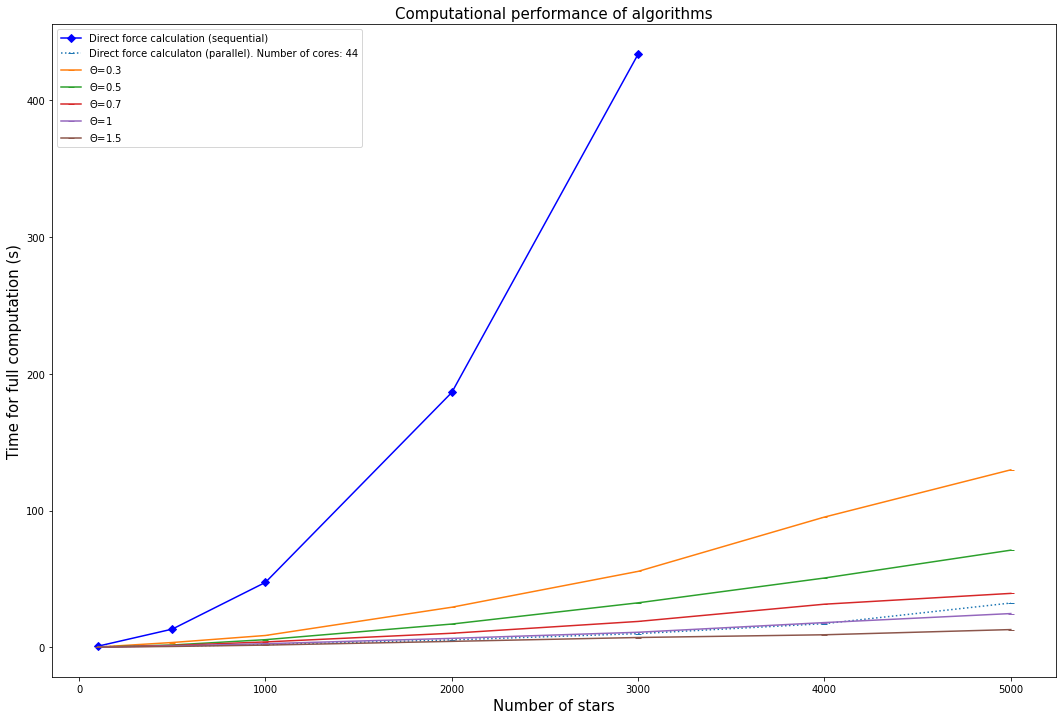

In [73]:
plt.figure(figsize=(18, 12))
plt.plot(nr_stars_list[:len(seq_times)], seq_times, linestyle='-', marker='D',label='Direct force calculation (sequential)', color='blue')
plt.plot(nr_stars_list, par_times, linestyle=':', marker='_',label=f'Direct force calculaton (parallel). Number of cores: {44}')
#plot for different epsilons
for i,angle in enumerate(opening_angles):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(nr_stars_list, tree_times_per_angles.loc[i].values, marker='_',label=f'$\Theta$={angle}')

plt.legend(loc='upper left')
plt.xlabel('Number of stars',fontsize = 15)
plt.ylabel('Time for full computation (s)',fontsize = 15)
plt.title('Computational performance of algorithms', fontsize = 15)
plt.show()

From this plot one can see the expected timewise expense for each algorithm especially for Sequential diret force calculation which should scale as NxX and the tree code should scale.
The parallel one is just for refrence to see how well it performs. And seems that it performs better than the tree code, but that is expected when using that many cores. In total it shows how good the tree code actually is since it is not that much slower.

### Comparing accuracy of algorithms

For this I will use the parallel direct force computation with $\epsilon\rightarrow 0$ since it is faster. And also will use the tree code with different opening angles. To see how it affects accuracy.

Calculate errors. I will plot average relative error compared to the direct summation.

In [69]:
#errors_per_nr_stars=[]
df_errors_per_nr_stars = pd.DataFrame()
for i,nr_stars in enumerate(nr_stars_list):
    avg_error_per_angle = []
    for j,angle in enumerate(opening_angles):
        #difference = forces_direct_mags[i] - forces_tree_mags[i][j]
        avg_rel_error = np.mean(np.abs((forces_direct_mags[i] - forces_tree_mags[i][j])/ forces_direct_mags[i]))#*100#calculate the average relative error vs the direct summation
        avg_error_per_angle.append(avg_rel_error)
    df_errors_per_nr_stars[f'nr_stars={nr_stars}'] = avg_error_per_angle
    #errors_per_nr_stars.append(avg_error_per_angle)

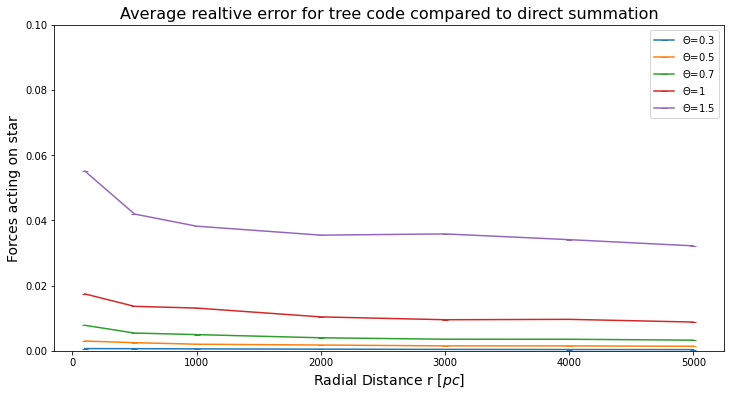

In [77]:
plt.figure(figsize=(12, 6))
#for i,distance_r in enumerate(distance_r_list):
for i,angle in enumerate(opening_angles):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(nr_stars_list, df_errors_per_nr_stars.loc[i].values, marker='_',label=f'$\Theta$={angle}')
plt.legend(loc='upper right')
plt.xlabel('Radial Distance r $[pc]$', fontsize = 14)
plt.ylabel('Number of stars', fontsize = 14)
plt.ylim(0.0,0.10)
plt.title('Average realtive error for tree code compared to direct summation', fontsize = 16)
plt.show()

**This plot has wrong axis labels**

x-axis should be- **Number of stars**  
y-axis should be- **average relative error**

Verdict on which theta to use. Looking at the computational time and accuracy I would use $\Theta=0.7$. Just because error is pretty small and the computational time is not the worst.

### Time integration

Using an appropriate time integrator among those that you have studied and tested earlier,
integrate the equation of motions using direct summation for a few systems’ crossing timescales
(see definition at Task 1 Step 2). Repeat the integration with different force softenings and
attempt to measure the magnitude of numerical relaxation in runs with.

The time integration method I will use will implement the leapfrog. Since this should be the best used for problems like this, where conservation of energy is important. I will use the kick drift formula for the leapfrog

First half kick:

$v_{n+\frac{1}{2}} = v_n +f(x_n)\frac{\Delta t}{2}$
    
Drift:

$x_{n+1} = x_n + v_{n+\frac{1}{2}} \Delta t$

Second half kick:

$v_{n+\frac{1}{2}} = v_n +f(x_n)\frac{\Delta t}{2}$

Setting up the integrator with direct summation

In [7]:
def leapfrog_integration(stars, forces, dt, epsilon = 0.1):
    positions = stars[['x', 'y', 'z']].values
    velocities = stars[['vx', 'vy', 'vz']].values
    masses = stars['mass'].values.reshape(stars.shape[0],1)
    #print(f'forces{forces}')
    #1/2 kick
    velocities += forces * dt/2.0
    #print(f'velocities1 {velocities}')
    
    #drift
    positions += velocities * dt
    stars[['x', 'y', 'z']] = positions #update positions
    #print(f'pos {positions}')
    
    #new forces # here is a flaw

    #new_forces = calculate_total_force(stars, epsilon)#sequential
    #print(f"new forces for seq: {new_forces[:5]}")
    new_forces = calculate_total_force_parallel_proc(stars, epsilon)#parallel
    #print(f"new forces for parallel: {new_forces[:5]}")
    
    #ramaining 1/2 kick
    velocities += new_forces*dt/2.0
    #print(f'velocities2 {velocities}')
    #rename forces for next loop
    forces = new_forces
    
    stars[['vx', 'vy', 'vz']] = velocities

    
    #save data frame
    #data = np.concatenate((masses, positions, velocities), axis=1)
    #stars = pd.DataFrame(data, columns=column_names)
    
    return stars, forces

Setting up integrator for tree code

In [8]:
def leapfrog_integration_tree(stars, forces, dt, opening_angle = 0.5):
    positions = stars[['x', 'y', 'z']].values
    velocities = stars[['vx', 'vy', 'vz']].values
    masses = stars['mass'].values.reshape(stars.shape[0],1)

    #1/2 kick
    velocities += forces * dt/2.0
    #print(f'velocities1 {velocities}')
    
    #drift
    positions += velocities * dt
    stars[['x', 'y', 'z']] = positions #update positions
    #print(f'pos {positions}')
    
    #calculate tree forces
    new_forces = Tree_forces(stars, thetamax = opening_angle, G = 1.)
    
    #ramaining 1/2 kick
    velocities += new_forces*dt/2.0
    #print(f'velocities2 {velocities}')
    #rename forces for next loop
    forces = new_forces
    
    stars[['vx', 'vy', 'vz']] = velocities

    
    #save data frame
    #data = np.concatenate((masses, positions, velocities), axis=1)
    #stars = pd.DataFrame(data, columns=column_names)
    
    return stars, forces

In [9]:
##########################################################################################
###Creatning subsample of stars within the system randomly according to n samples needed##
##########################################################################################
def sample_stars(df,nr_stars,seed =10):
    #radius = 0.0055#0.0055 213 stars 0.1 15 k stars
    #df_stars_sub = df_stars[df_stars['distance'] <= radius]
    sample_df = df.sample(n=nr_stars, random_state = seed)
    #reset indexes
    sample_df = sample_df.reset_index(drop=True)
    #df_stars_sub.describe()
    return sample_df

In [10]:
##############################################################################
###Test array for integration that works on both methods. Mine and the given##
##############################################################################
def test_sample():
    """This creates a test sample for both my integrators and the example integrator to
        compare results.
    """
    N         = 200 #df.shape[0]    # number of particles
    t         = 0      # current time of the simulation
    endTime   = 0.1   # time at which simulation ends
    dt        = 0.01   # timestep
    limit     = 0.1    # limit length
    G         = 1.0    # value of Gravitational Constant used for the simulation
    # seeding the random number generator with Unix time 
    np.random.seed(100)
    
    M   = 2*np.ones((N, 1))/N  # total M of particles is 100
    R   = np.random.randn(N, 3)    # randomly selected positions and velocities#
    vel = np.random.randn(N, 3)
    
    #R = np.asarray([[0.0,0.0,0.0],
    #                [1.0,0.0,0.0]])
    #vel = np.asarray([[0.0,0.0,0.0],
    #                  [0.0,v,0.0]])
    test_array=np.concatenate((M, R,vel), axis=1)
    column_names2 = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
    test_df =  pd.DataFrame(test_array, columns=column_names2)
    return test_df

In [11]:
def leapfrog_direct_summation_sim(sample_df, epsilon = 0.008):
    """Leapfrog direct summation with direct summation"""

    stars = sample_df#sample of stars to conduct simulation on
    N = stars.shape[0]#nr of stars
    
    #time parameters
    endTime = 0.1 #endtime
    dt = 0.01
    num_steps = int(np.ceil(endTime/dt))# number of timesteps
    
    
    #first forces calculation direct
    forces = calculate_total_force_parallel_proc(stars, epsilon = epsilon)
    
    #save particle orbits for plotting trails
    position_save = np.zeros((N, 3, num_steps+1))
    position_save[:,:,0] = stars[["x","y","z"]]
    
    #plot style
    plt.style.use('dark_background')
    for step in range(num_steps):
        #direct summation
        stars, forces = leapfrog_integration(stars, forces, dt,epsilon = epsilon)
        
        position_save[:,:,step+1] = stars[["x","y","z"]] # save positions for plotting trail
        
        plt.cla()# clear the current figure

        xp = position_save[:, 0, max(step-50,0):step+1]#xp and yp are the trail left behind by the stars
        yp = position_save[:, 1, max(step-50,0):step+1]

        plt.scatter(xp, yp, s=1, color = 'cornflowerblue') # plotting the trails
        # plotting the objects
        plt.scatter(stars[["x","y","z"]].values[:,0], stars[["x","y","z"]].values[:,1], s=10, color ='white')
        plt.pause(0.001)
    return 0

In [12]:
def leapfrog_tree_code_sim(sample_df, opening_angle = 0.5):
    """Leapfrog direct summation with direct summation"""

    stars = sample_df#sample of stars to conduct simulation on
    N = stars.shape[0]#nr of stars
    
    #time parameters
    endTime = 0.1 #endtime
    dt = 0.01
    num_steps = int(np.ceil(endTime/dt))# number of timesteps
    
    
    #first forces calculation tree
    forces = Tree_forces(stars, thetamax = opening_angle, G = 1.)
    
    #save for plotting
    # save particle orbits for plotting trails
    position_save = np.zeros((N, 3, num_steps+1))
    position_save[:,:,0] = stars[["x","y","z"]]
    
    #plot style
    plt.style.use('dark_background')
    for step in range(num_steps):        
        #tree code
        stars, forces = leapfrog_integration_tree(stars, forces, dt, opening_angle = 0.5)
        
        position_save[:,:,step+1] = stars[["x","y","z"]] # save positions for plotting trail
        
        plt.cla()# clear the current figure

        xp = position_save[:, 0, max(step-50,0):step+1]#xp and yp are the trail left behind by the stars
        yp = position_save[:, 1, max(step-50,0):step+1]

        plt.scatter(xp, yp, s=1, color = 'cornflowerblue') # plotting the trails
        # plotting the objects
        plt.scatter(stars[["x","y","z"]].values[:,0], stars[["x","y","z"]].values[:,1], s=10, color ='white')
        plt.pause(0.001)
    return 0

First I will take a look at all the integrators in my use to evolve the system to see if they work using a toy example

As we are looking at the system we see that the star systems explode. As before stated the stars are too fast. 

<!-- To analyze it further lets take a look at the systems total kinetic $KE$ and potential $PE$ energy. In a system like this one would expect to see the application of Virial Theorem, which states that on average there would be twice as much $⟨KE⟩$ as $⟨PE⟩$. Lets put that to the test. -->

## $2⟨KE⟩+⟨PE⟩=0$

First let's find the average kinetic energy. For a single star the $KE$ is defined as $KE = \frac{1}{2}mv^2$

In [44]:
file_path = './data.txt'

# Define column names
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'soft', 'pot']

# Read the .txt file into a DataFrame
org_stars = pd.read_csv(file_path, sep='\t', header=None, names=column_names)

#remove useless columns
useless = ['soft','pot']
org_stars= org_stars.drop(columns=useless)
# Add velocity magnitude
org_stars['v_mag'] = np.sqrt(org_stars['vx']**2 + org_stars['vy']**2 + org_stars['vz']**2)
# Add distance
org_stars['distance'] = np.sqrt(org_stars['x']**2 + org_stars['y']**2 + org_stars['z']**2)

In [45]:
df = org_stars
KE = 0.5 * df['mass'] * (df['vx']**2 + df['vy']**2 + df['vz']**2).values
avg_KE = np.mean(KE)
print(f'The average kinetic energy of the whole system: {avg_KE}')

The average kinetic energy of the whole system: 440965413.90465117


To test this we will look at 3 different radii. $R_{half}$,$R_{quart}$ and $R_{eight}$ corresponding to half-mass radius and then next half and so fourth

In [46]:
r_half = (1 + np.sqrt(2))*a_fit[0]
r_quart = r_half/2
r_eight = r_quart/2
r_16 = r_eight/2
r_list = [r_half,r_quart,r_eight,r_16]
print(f'The radiuses: {np.round(r_half,3)} [pc], {np.round(r_quart,3)} [pc], {np.round(r_eight,3)} [pc])')
#also make dataframes
#org_stars = df_stars
r_half_df_stars = org_stars[org_stars['distance'] <= r_half]#25k
r_quart_df_stars = org_stars[org_stars['distance'] <= r_quart]#15k
r_eight_df_stars = org_stars[org_stars['distance'] <= r_eight]#7k stars
r_16_df_stars = org_stars[org_stars['distance'] <= r_16]#3k stars
dfs_list = [r_16_df_stars, r_eight_df_stars, r_quart_df_stars, r_half_df_stars] 

The radiuses: 0.191 [pc], 0.095 [pc], 0.048 [pc])


In [48]:
r_half_df_stars.describe()

mass             x             y             z            vx  \
count  2.513000e+04  25130.000000  25130.000000  25130.000000  25130.000000   
mean   9.242590e+01     -0.000381      0.000020     -0.000358      4.406983   
std    2.005191e-11      0.057690      0.056972      0.057272   2191.213565   
min    9.242590e+01     -0.187188     -0.187796     -0.187676  -7231.980000   
25%    9.242590e+01     -0.031752     -0.031079     -0.031517  -1476.295000   
50%    9.242590e+01     -0.000230      0.000078     -0.000297      2.309175   
75%    9.242590e+01      0.030936      0.031690      0.030960   1489.365000   
max    9.242590e+01      0.189057      0.187283      0.186398   7525.940000   

                 vy            vz         v_mag      distance  
count  25130.000000  25130.000000  25130.000000  25130.000000  
mean       8.875532      3.430300   3500.687330      0.085583  
std     2210.953325   2176.169377   1473.178592      0.050294  
min    -7930.760000  -7952.250000    111.380143      0.000366  
25%    -1494.287500  -1456.630000   2410.373176      0.043100  
50%        9.931270      7.208760   3391.828823      0.079415  
75%     1503.247500   1471.112500   4479.708195      0.124386  
max     7874.570000   7595.740000   8518.785337      0.190504

First I take the radiuses I have chosen and compute the average kinetic and potential energy within the spheres within radius

In [49]:
potentials_list = []
kinetic_list = []
for i,df in enumerate(dfs_list):
    print(i)
    #if i < 3:
    KE = 0.5 * df['mass'] * (df['vx']**2 + df['vy']**2 + df['vz']**2).values
    avg_KE = np.mean(KE)
    kinetic_list.append(avg_KE)
    
    potentials = Tree_forces(df, thetamax=0.4, G=1., lone_star = False, org_index = None,potential_cal = True)
    mean_potentials = np.mean(potentials[:,0])
    potentials_list.append(mean_potentials)

0
use pot
1
use pot
2
use pot
3
use pot


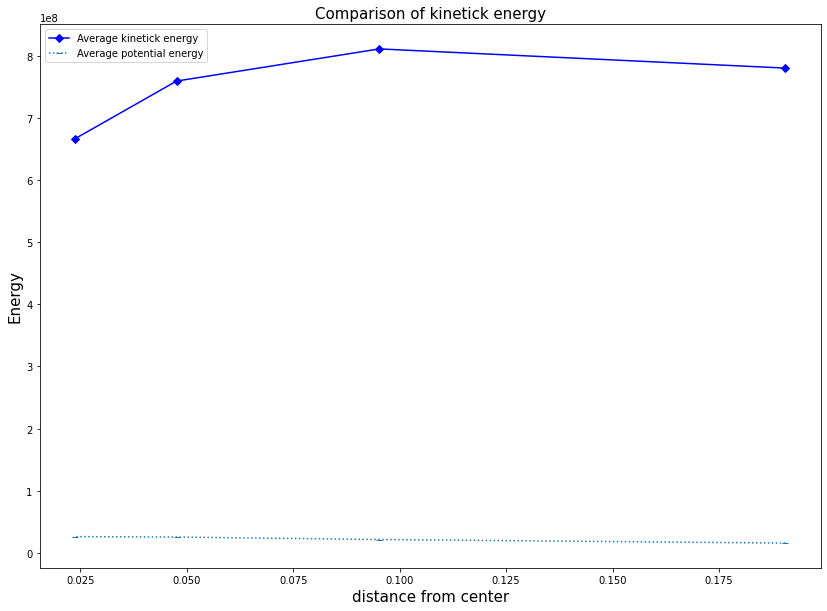

In [51]:
#G =1 and org data
plt.figure(figsize=(14, 10))
plt.plot(r_list, kinetic_list, linestyle='-', marker='D',label='Average kinetick energy', color='blue')
plt.plot(r_list, potentials_list, linestyle=':', marker='_',label=f'Average potential energy')

plt.legend(loc='upper left')
plt.xlabel('distance from center',fontsize = 15)
plt.ylabel('Energy',fontsize = 15)
plt.title('Comparison of kinetick energy', fontsize = 15)
plt.show()

Then will do another one where I use the whole system with subsamples within them

In [56]:
#also make dataframes
#org_stars = df_stars
seed_value = 100
df_stars_25k = org_stars.sample(n=25000, random_state = seed_value )#25k
df_stars_15k = org_stars.sample(n=15000, random_state = seed_value )#15k
df_stars_7k = org_stars.sample(n=7000, random_state = seed_value )#7k stars
df_stars_3k = org_stars.sample(n=3000, random_state = seed_value )#3k stars
dfs_list = [df_stars_3k, df_stars_7k, df_stars_15k, df_stars_25k] 

In [57]:
potentials_list = []
kinetic_list = []
for i,df in enumerate(dfs_list):
    print(i)
    #if i < 3:
    KE = 0.5 * df['mass'] * (df['vx']**2 + df['vy']**2 + df['vz']**2).values
    avg_KE = np.mean(KE)
    kinetic_list.append(avg_KE)
    
    potentials = Tree_forces(df, thetamax=0.4, G=1., lone_star = False, org_index = None,potential_cal = True)
    mean_potentials = np.mean(potentials[:,0])
    potentials_list.append(mean_potentials) 

0
use pot
1
use pot
2
use pot
3
use pot


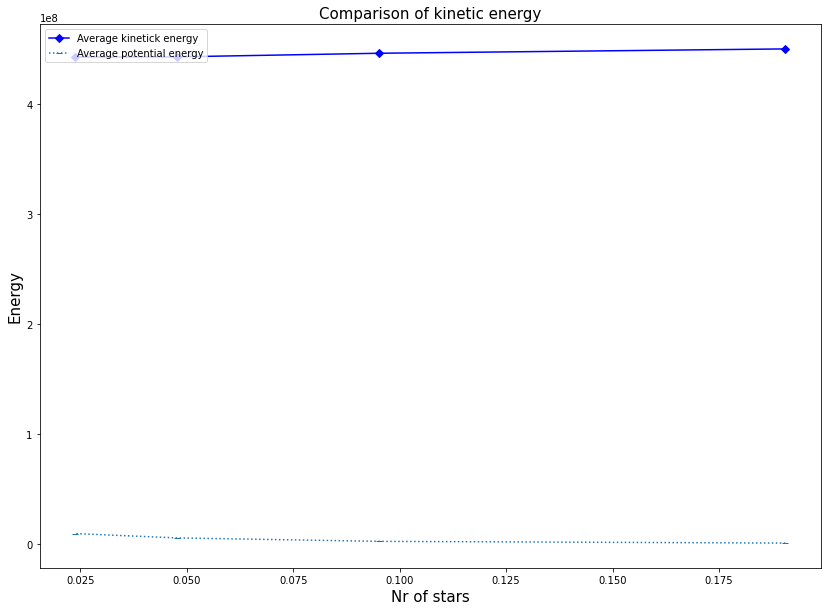

In [59]:
#G =1 and org data
plt.figure(figsize=(14, 10))
plt.plot(r_list, kinetic_list, linestyle='-', marker='D',label='Average kinetick energy', color='blue')
plt.plot(r_list, potentials_list, linestyle=':', marker='_',label=f'Average potential energy')

plt.legend(loc='upper left')
plt.xlabel('Nr of stars',fontsize = 15)
plt.ylabel('Energy',fontsize = 15)
plt.title('Comparison of kinetic energy', fontsize = 15)
plt.show()

So all in all we see that the data does not come even close to the Virial theorem

## From there extra stuff not in project

In [82]:
potentials_list = []
kinetic_list = []
for i,df in enumerate(dfs_list):
    print(i)
    #if i < 3:
    KE = 0.5 * df['mass'] * (df['vx']**2 + df['vy']**2 + df['vz']**2).values
    avg_KE = np.mean(KE)
    kinetic_list.append(avg_KE)
    
    potentials = Tree_forces(df, thetamax=0.4, G=1., lone_star = False, org_index = None,potential_cal = True)
    mean_potentials = np.mean(potentials[:,0])
    potentials_list.append(mean_potentials)
    

0
use pot
1
use pot
2
use pot
3


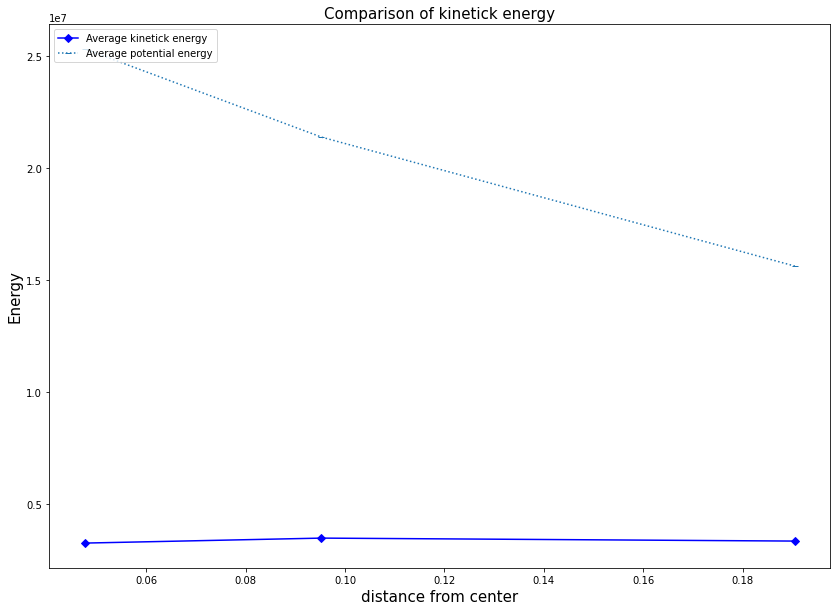

In [83]:
#with G = 1 and converted units
plt.figure(figsize=(14, 10))
plt.plot(r_list[:-1], kinetic_list, linestyle='-', marker='D',label='Average kinetick energy', color='blue')
plt.plot(r_list[:-1], potentials_list, linestyle=':', marker='_',label=f'Average potential energy')

plt.legend(loc='upper left')
plt.xlabel('distance from center',fontsize = 15)
plt.ylabel('Energy',fontsize = 15)
plt.title('Comparison of kinetick energy', fontsize = 15)
plt.show()

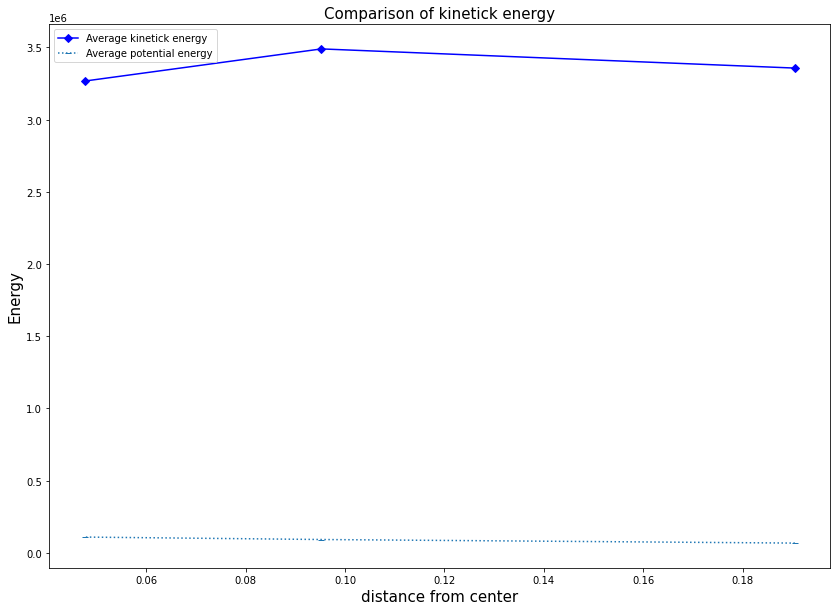

In [79]:
#with G = 0.0034 and converted units
plt.figure(figsize=(14, 10))
plt.plot(r_list[:-1], kinetic_list, linestyle='-', marker='D',label='Average kinetick energy', color='blue')
plt.plot(r_list[:-1], potentials_list, linestyle=':', marker='_',label=f'Average potential energy')

plt.legend(loc='upper left')
plt.xlabel('distance from center',fontsize = 15)
plt.ylabel('Energy',fontsize = 15)
plt.title('Comparison of kinetick energy', fontsize = 15)
plt.show()

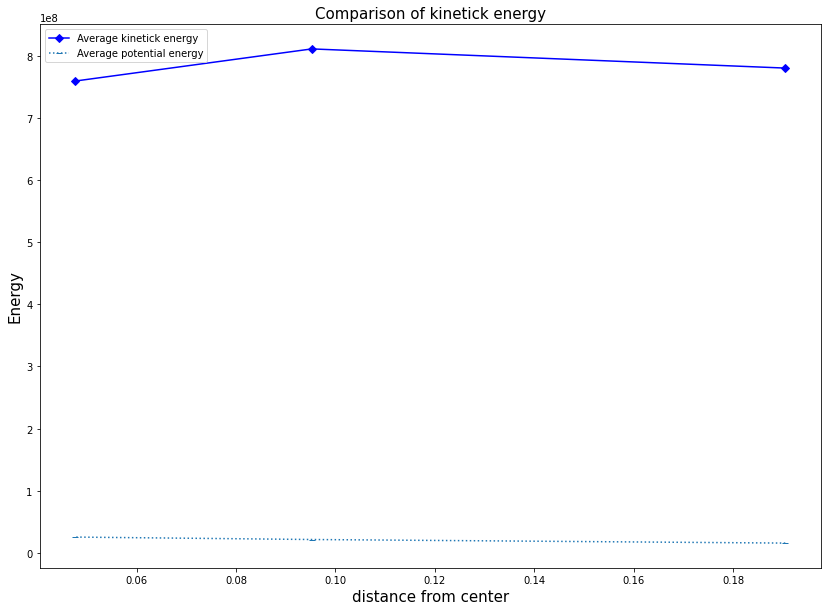

In [71]:
#internal units G = 1
plt.figure(figsize=(14, 10))
plt.plot(r_list[:-1], kinetic_list, linestyle='-', marker='D',label='Average kinetick energy', color='blue')
plt.plot(r_list[:-1], potentials_list, linestyle=':', marker='_',label=f'Average potential energy')

plt.legend(loc='upper left')
plt.xlabel('distance from center',fontsize = 15)
plt.ylabel('Energy',fontsize = 15)
plt.title('Comparison of kinetick energy', fontsize = 15)
plt.show()

In [54]:
# Function to calculate gravitational force with softening
def calculate_potential(m_j,x1,y1,z1,x2,y2,z2):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    potential = 1*(m_j)/r12
    return potential
# Function to calculate total force on each star
def calculate_total_potential(stars):
    #spews out a list with the potentials
    potentials = np.zeros((len(stars), 1))
    #loop over stars. i is the star for which the the force is calculated for
    for i in range(len(stars)):
        #print(i)
        for j in range(len(stars)):
            if i != j:
                potential = calculate_potential(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j])
                potentials[i] += potential

    return potentials

In [ ]:
potentials_direct = calculate_total_potential(df)
np.mean(potentials_direct)

In [58]:
#potentials = Tree_forces(df, thetamax=0.4, G=1., lone_star = False, org_index = None,potential_cal = True)
#np.mean(potentials[:,0])

In [14]:
'''
doc: https://matplotlib.org/api/pyplot_api.html
Mathplotlib has been used to make scatterplots to represent the point particles
'''
import matplotlib.pyplot as plt

'''
doc: https://numpy.org/doc/
Numpy has been used to make matrix claculations.
All the arrays used are ndarrys supplied by Numpy and not the ususal python list.
'''
import numpy as np
from numpy import inf

'''
doc: https://docs.python.org/3/library/time.html
Time has been used to get Unix time and to seed Numpy's random number generator
with it.
'''
import time

def getAcceleration(limit, G, M, R):
    '''
    R is the N x 3 position matrix of the form [[x1, y1, z1], [x2, y2, z2], ...]
    M is the N x 1 mass matrix of the form [[m1], [m2], ..]. The reason to
    write masses like this over [m1, m2, ..] is to use the same technique to
    generate the 2d random lists provided by Numpy.
    G is Universal Gravitational constant used for the simulation. I have put it
    inside main to avoid clashes with other code in case the script is imported
    as a module.
    limit is the limiting value of |r2 - r1|.
    A is N x 3 matrix of the acceleration for a particle due to all the other
    particles of the form [[ax1, ay1, az1], [ax2, ay2, az2],..].
    '''
    
    # reference to see how slicing of ndarray's work
    # https://www.w3schools.com/python/numpy_array_slicing.asp
    # X is a ndarray of the form [[x1], [x2], ...]
    X = R[:, 0:1]
    Y = R[:, 1:2]
    Z = R[:, 2:3]

    # ndarray.T returns the tranpose of the ndarray
    # dx is a ndarray that stores the rj - ri values
    # so for a 3x3 case the matrix formed by this operation is of the form
    # [[0, x2 - x1, x3 - x1], [x1 - x2, 0, x3 - x2], [x1 - x3, x2 - x3, 0]]
    Dx = X.T - X
    Dy = Y.T - Y
    Dz = Z.T - Z

    # the limit is very small and hence negligible
    # Dx**2 sqares each of the element
    InvR3 = (Dx**2 + Dy**2 + Dz**2 + limit**2)
    # raising all the elements of InvR3 to the power -3/2
    InvR3 = np.power (InvR3, -1.5)
    # replacing all infinities prodcued by exponentiation process
    InvR3 [InvR3 == inf] = 0
    # For a 3 x 3 case InvR3's final form is
    # [[0, ((x2-x1)^2 + (y2-y1)^2 + (z2 - z1)^2)^-1.5,  ((x3-x1)^2 + (y3-y1)^2 + (z3 - z1)^2)^-1.5]
    #  [((x1-x2)^2 + (y1-y2)^2 + (z1 - z2)^2)^-1.5,   0,((x3-x2)^2 + (y3-y2)^2 + (z3 - z2)^2)^-1.5]
    #  [((x1-x3)^2 + (y1-y3)^2 + (z1 - z3)^2)^-1.5,  ((x2-x3)^2 + (y2-y3)^2 + (z2 - z3)^2)^-1.5, 0]]

    # @ is the matrix multiplication method
    # link explaining it: https://stackoverflow.com/questions/34142485/difference-between-numpy-dot-and-python-3-5-matrix-multiplication
    # The calculation for Ax is of the form
    # G * [[0, (x2-x1)*r21^-1.5*m2, (x3-x1)*r31^-1.5*m3], [(x1-x2)*r12^-1.5*m1, 0, (x3-x2)*r32-1.5*m3]]
    # So the ith-row of Ax is the acceleration of the ith particle due to all the
    #  other particles. The zeroes represent the fact a particle cannot apply
    # force on itself. Hence, the acceleration due to itself is zero.
    Ax = G * (Dx * InvR3) @ M
    Ay = G * (Dy * InvR3) @ M
    Az = G * (Dz * InvR3) @ M
    
    # Creating the final matrix for acceleration of all the particles
    # link for hstack method: https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
    A = np.hstack((Ax, Ay, Az))
    # A is of the form
    # [[ax1, ay1, az1], [ax2, ay2, az2], ...]
    return A

In [15]:
def leapfrog_example_sim(df_stars_sub, epsilon = 0.1):
    df = df_stars_sub
    N         = df.shape[0]#200 #df.shape[0]    # number of particles
    t         = 0      # current time of the simulation
    endTime   = 0.1   # time at which simulation ends
    dt        = 0.01   # timestep
    limit     = epsilon #0.1    # limit length
    G         = 1.0    # value of Gravitational Constant used for the simulation
    
    #assing position,velocities and mass from datafram
    R = df[["x","y","z"]].values
    vel = df[["vx","vy","vz"]].values
    M = df[["mass"]].values.reshape(df.shape[0],1)
    
    # Convert to Center-of-M frame
    #vel -= np.mean(M * vel,0) / np.mean(M)
    
    # calculate initial gravitational accelerations
    acc = getAcceleration(limit, G, M, R)
    
    # number of timesteps
    Nt = int(np.ceil(endTime/dt))
    
    # save particle orbits for plotting trails
    position_save = np.zeros((N, 3, Nt+1))
    position_save[:,:,0] = R
    
    plt.style.use('dark_background')
    # simulation loop
    for i in range(Nt):
        # using leapfrog integration. https://en.wikipedia.org/wiki/Leapfrog_integration
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift
        R += vel * dt
        #print(R)
        # update accelerations
        acc = getAcceleration(limit, G, M, R)
         
        # (1/2) kick
        vel += acc * dt/2.0
        
        # update time
        t += dt
        
        # save positions for plotting trail
        position_save[:,:,i+1] = R
        
        # clear the current figure
        plt.cla()
        #xp and yp are the trail left behind by the stars
        xp = position_save[:, 0, max(i-50,0):i+1]
        yp = position_save[:, 1, max(i-50,0):i+1]
        # plotting the trails
        plt.scatter(xp, yp, s=1, color = 'cornflowerblue')
        # plotting the objects
        plt.scatter(R[:,0], R[:,1], s=10, color ='white')
        plt.pause(0.001)
    plt.show()
    return 0

In [38]:
df = df_stars_sub
#df = test_df
N         = df.shape[0]#200 #df.shape[0]    # number of particles
t         = 0      # current time of the simulation
endTime   = 0.1   # time at which simulation ends
dt        = 0.01   # timestep
limit     = 0.1    # limit length
G         = 1.0    # value of Gravitational Constant used for the simulation
# seeding the random number generator with Unix time 
#np.random.seed(int(time.time()))

#M   = 2*np.ones((N, 1))/N  # total M of particles is 100
#R   = np.random.randn(N, 3)    # randomly selected positions and velocities#
#vel = np.random.randn(N, 3)
#R = np.asarray([[0.0,0.0,0.0],
#                [1.0,0.0,0.0]])
#vel = np.asarray([[0.0,0.0,0.0],
#                  [0.0,v,0.0]])

#example system
#fulll
R = df[["x","y","z"]].values
vel = df[["vx","vy","vz"]].values
M = df[["mass"]].values.reshape(df.shape[0],1)

# Convert to Center-of-M frame
#vel -= np.mean(M * vel,0) / np.mean(M)
#print(vel)

# calculate initial gravitational accelerations
acc = getAcceleration(limit, G, M, R)
#print(acc)

# number of timesteps
Nt = int(np.ceil(endTime/dt))
print(Nt)

# save particle orbits for plotting trails
position_save = np.zeros((N, 3, Nt+1))
position_save[:,:,0] = R

NameError: name 'df_stars_sub' is not defined

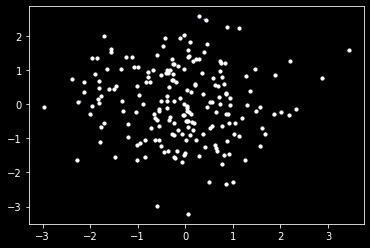

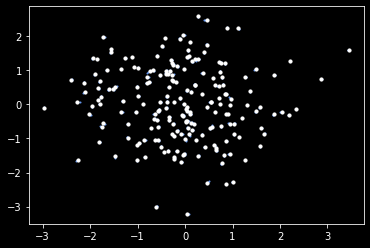

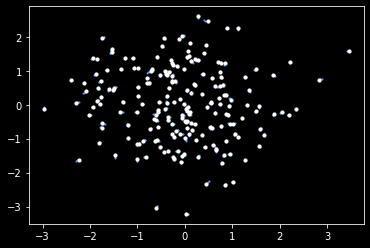

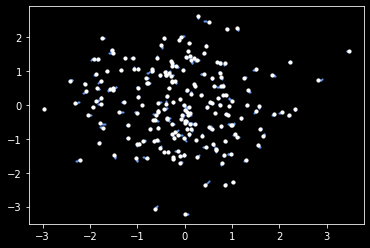

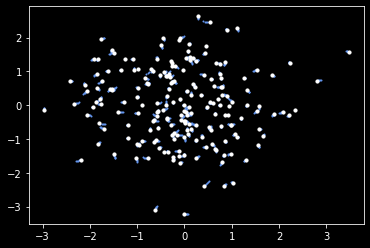

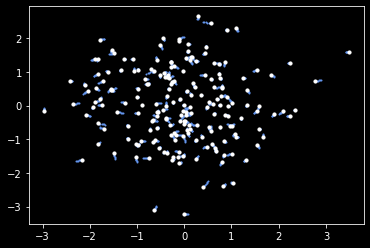

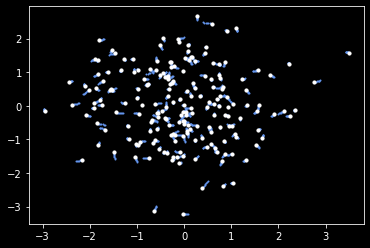

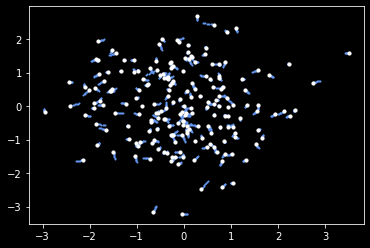

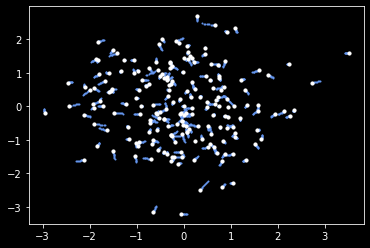

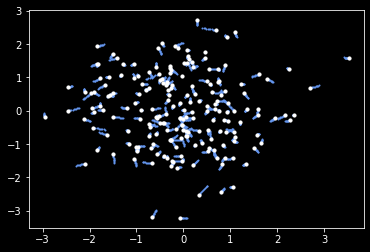

In [38]:
# figure
plt.style.use('dark_background')
# simulation loop
for i in range(Nt):
    # using leapfrog integration. https://en.wikipedia.org/wiki/Leapfrog_integration
    # (1/2) kick
    vel += acc * dt/2.0
    
    # drift
    R += vel * dt
    #print(R)
    # update accelerations
    acc = getAcceleration(limit, G, M, R)
     
    # (1/2) kick
    vel += acc * dt/2.0
    
    # update time
    t += dt
    
    # save positions for plotting trail
    position_save[:,:,i+1] = R
    
    # clear the current figure
    plt.cla()
    #xp and yp are the trail left behind by the stars
    xp = position_save[:, 0, max(i-50,0):i+1]
    yp = position_save[:, 1, max(i-50,0):i+1]
    # plotting the trails
    plt.scatter(xp, yp, s=1, color = 'cornflowerblue')
    # plotting the objects
    plt.scatter(R[:,0], R[:,1], s=10, color ='white')
    plt.pause(0.001)
plt.show()


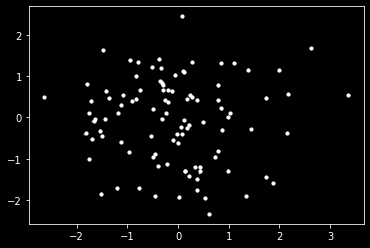

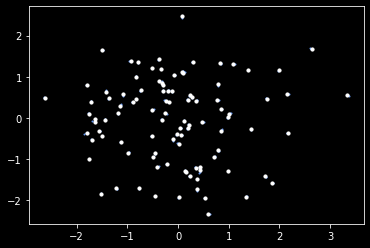

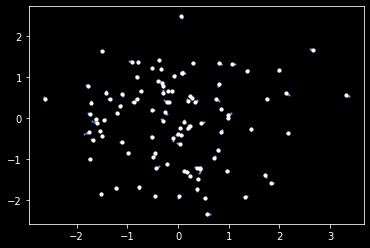

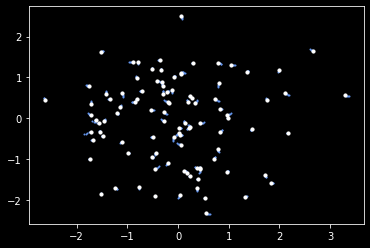

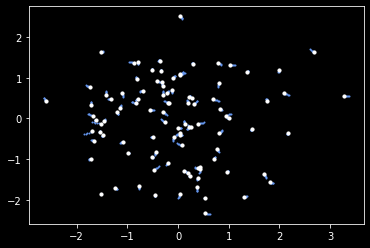

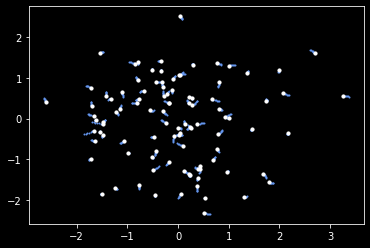

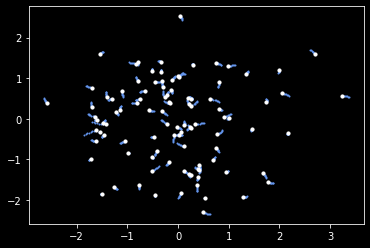

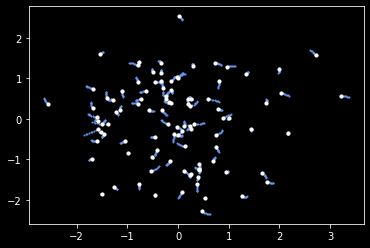

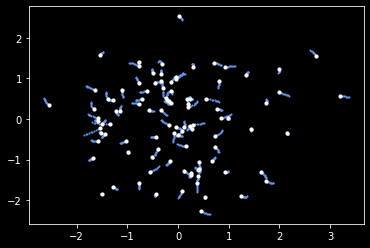

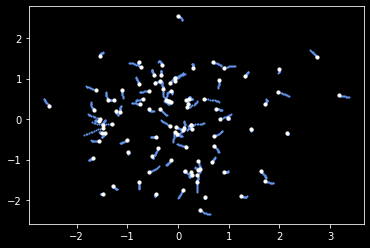

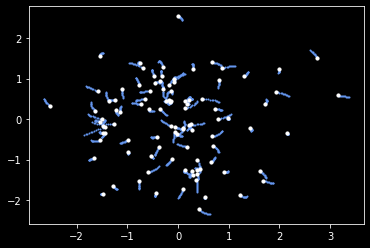

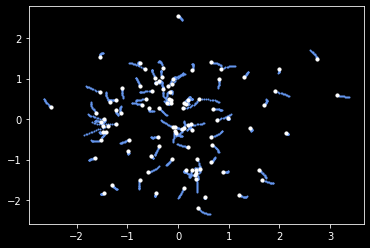

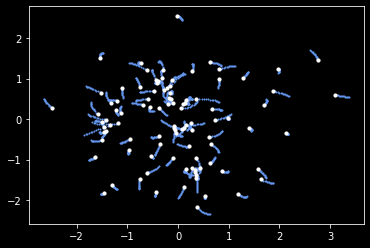

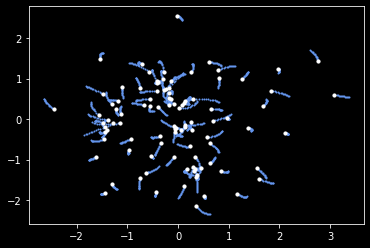

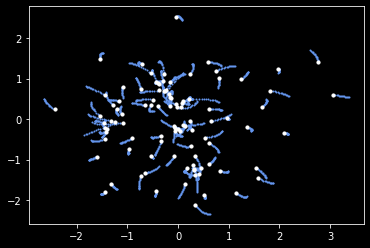

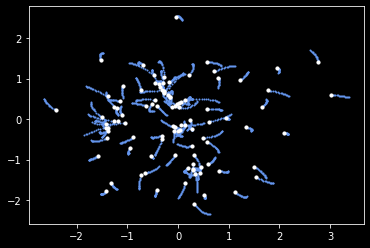

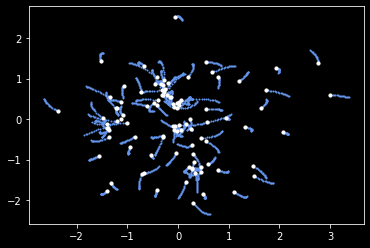

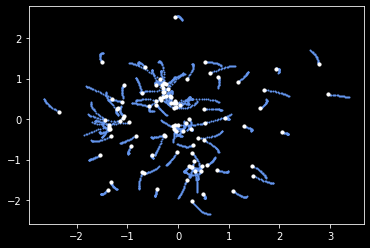

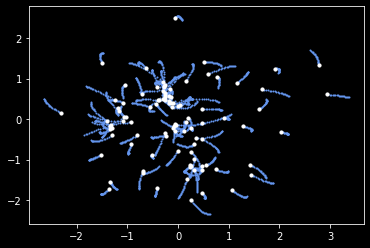

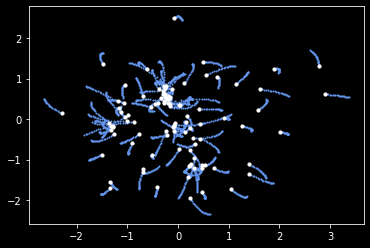

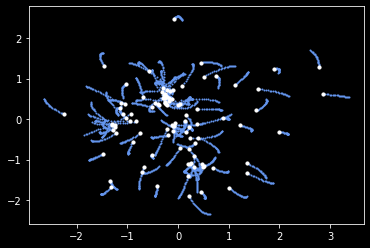

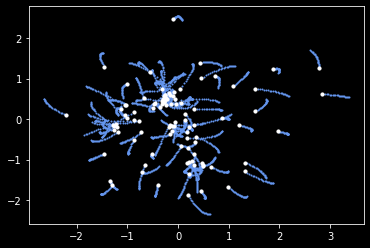

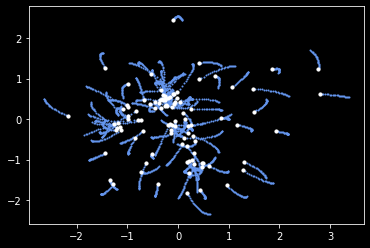

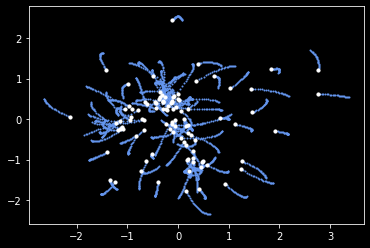

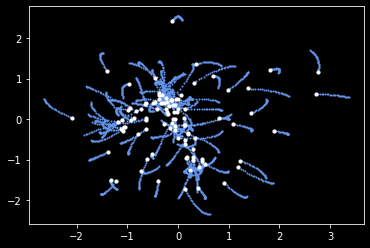

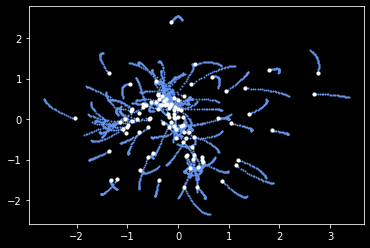

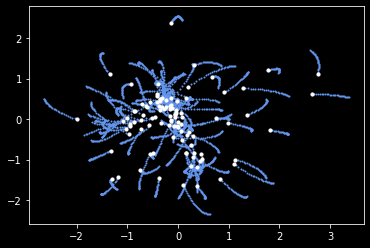

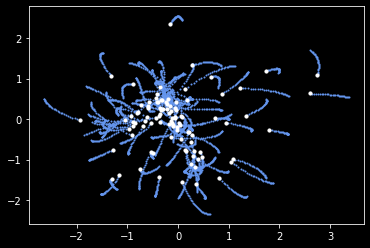

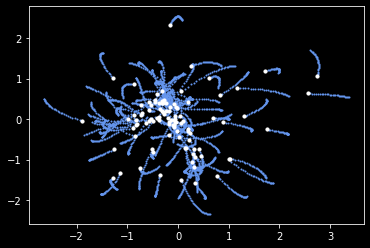

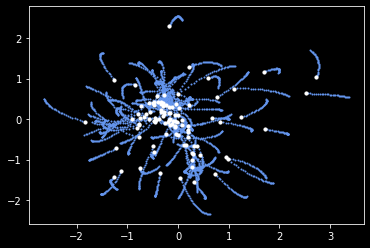

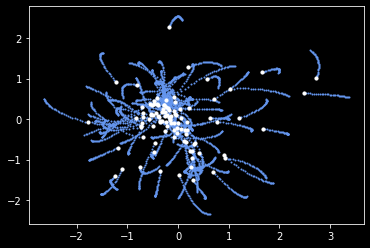

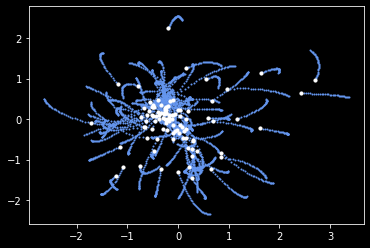

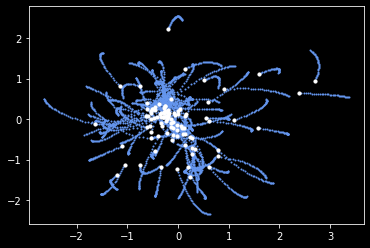

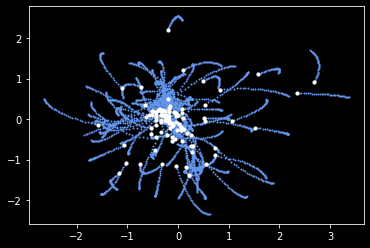

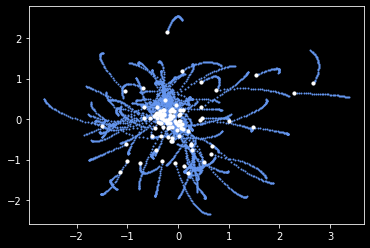

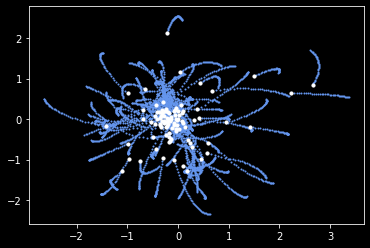

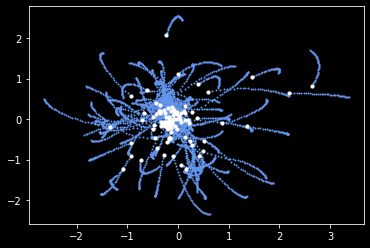

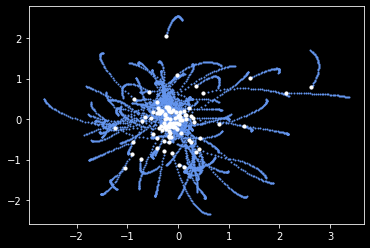

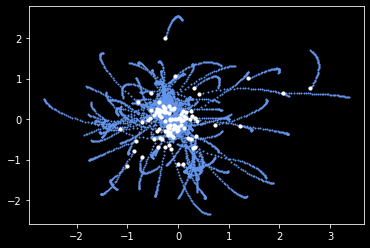

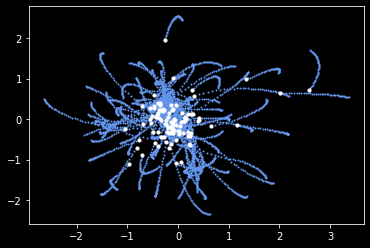

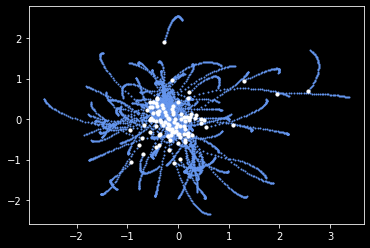

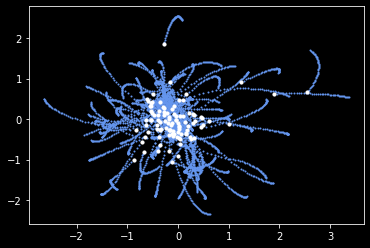

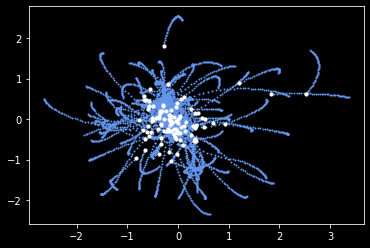

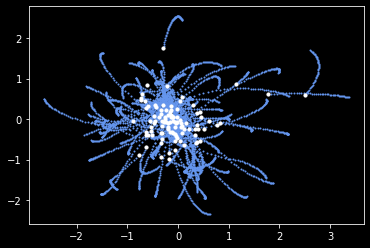

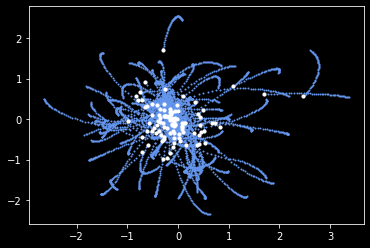

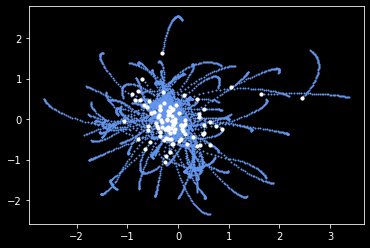

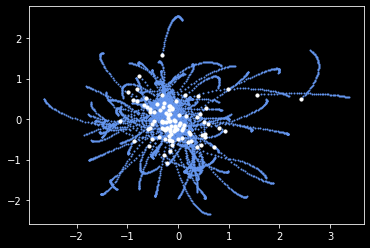

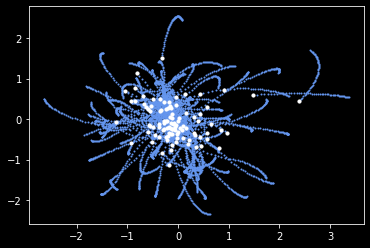

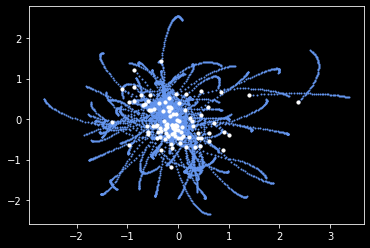

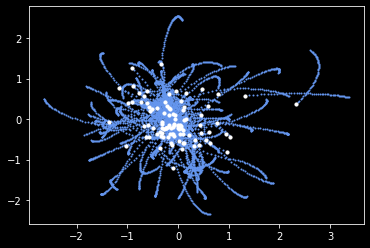

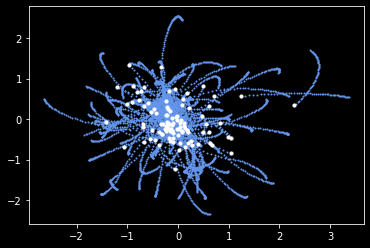

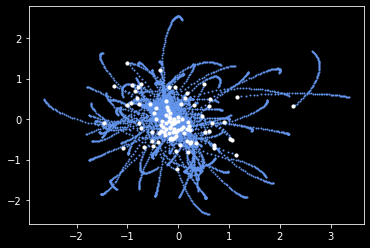

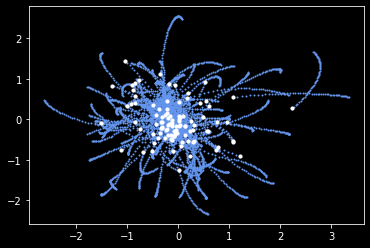

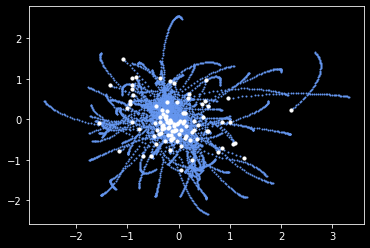

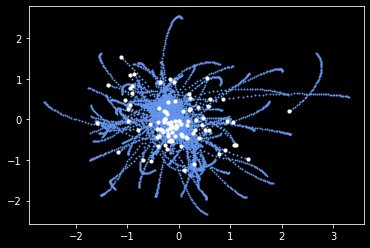

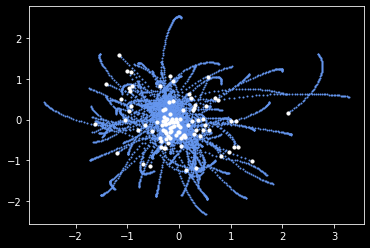

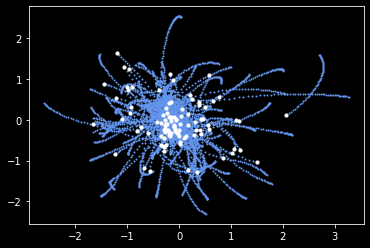

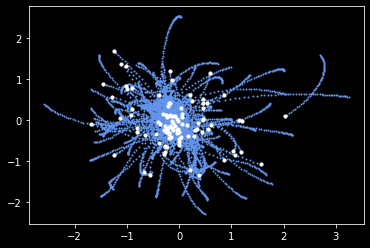

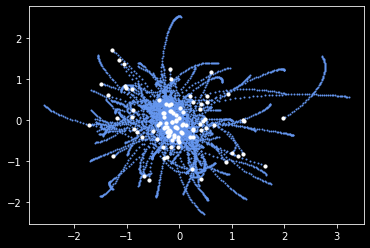

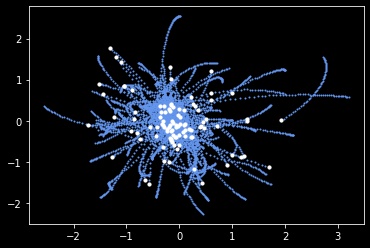

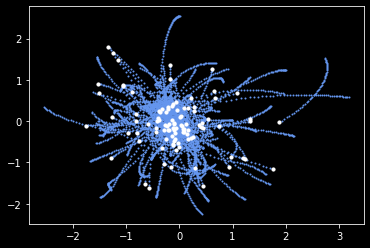

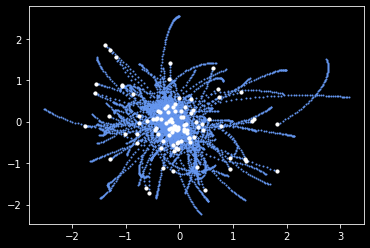

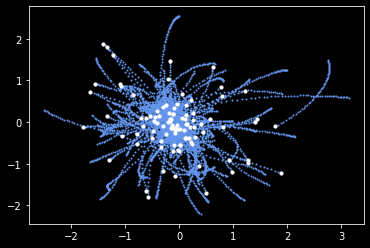

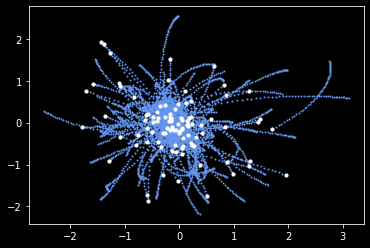

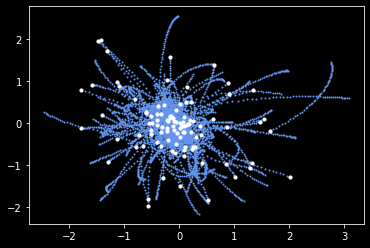

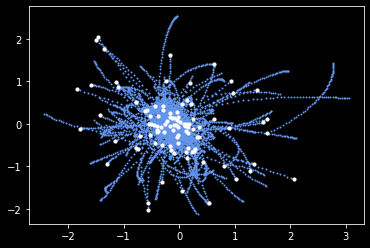

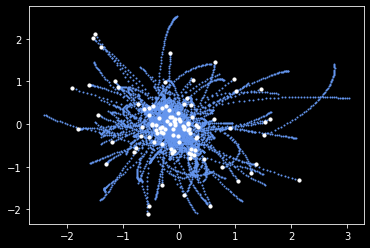

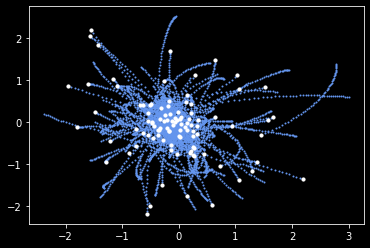

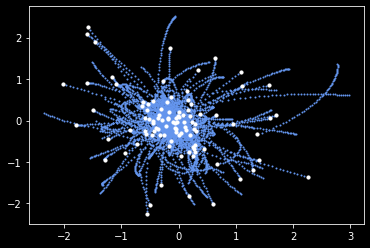

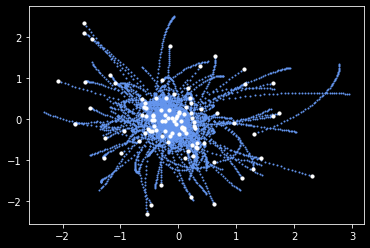

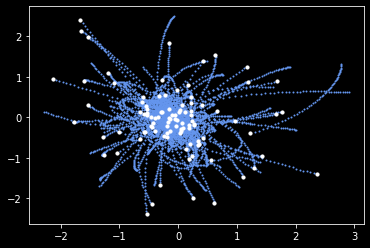

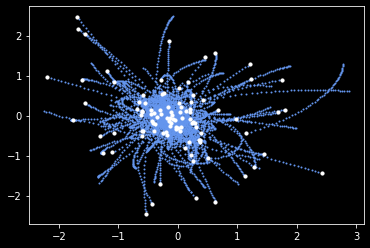

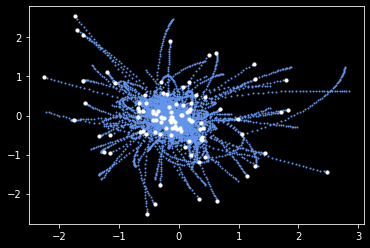

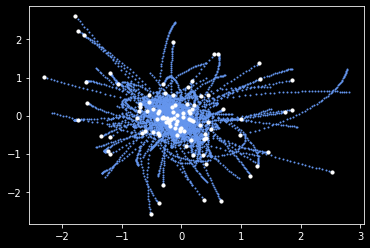

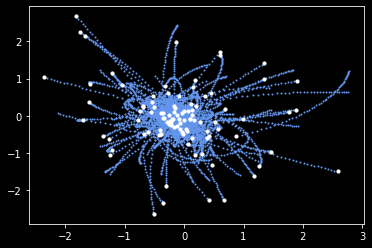

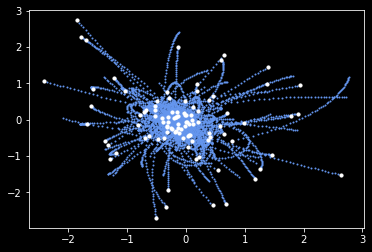

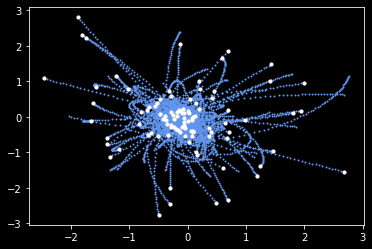

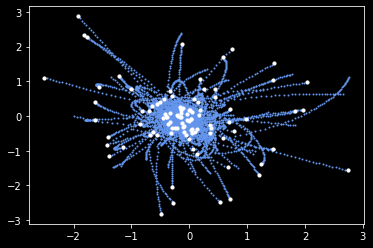

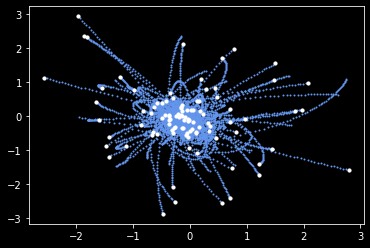

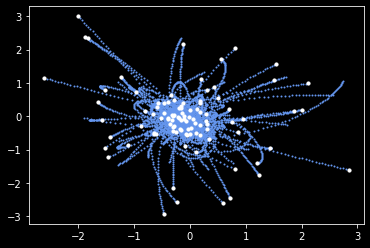

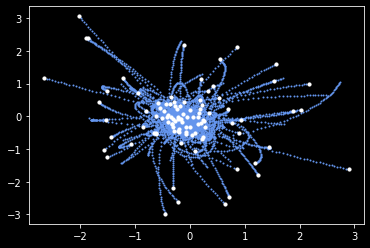

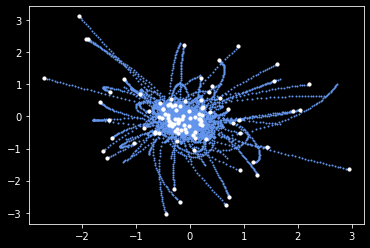

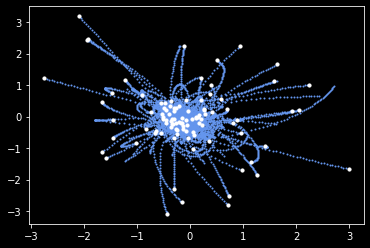

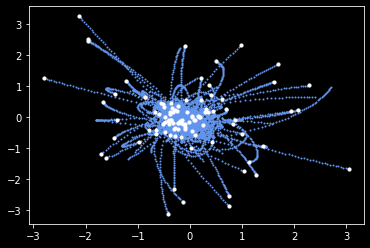

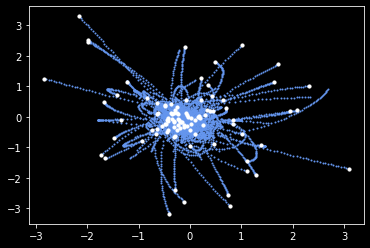

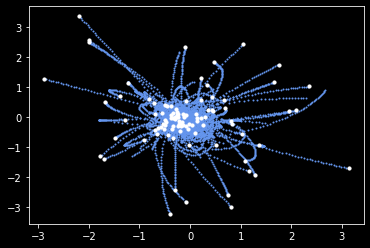

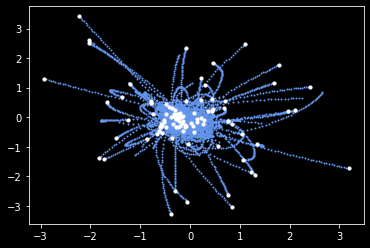

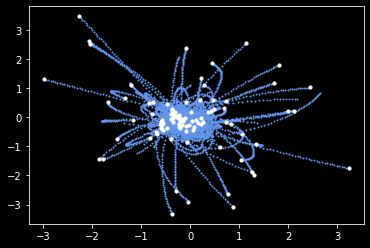

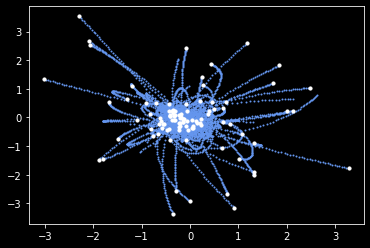

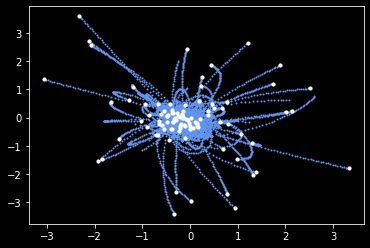

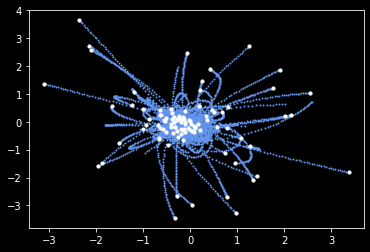

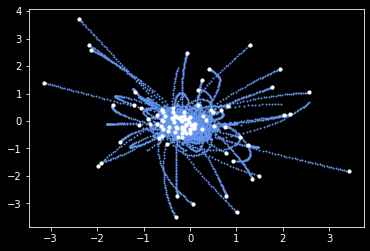

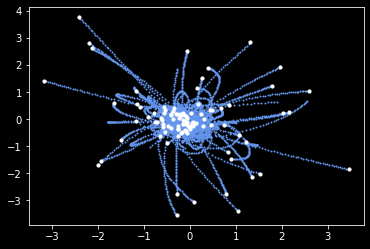

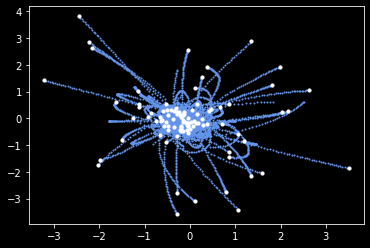

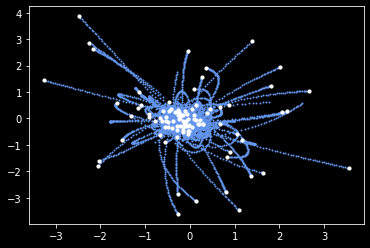

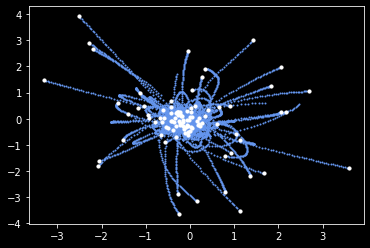

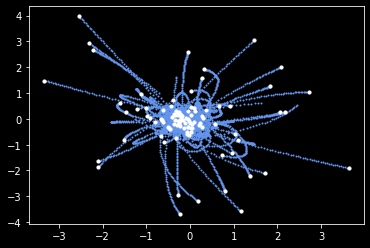

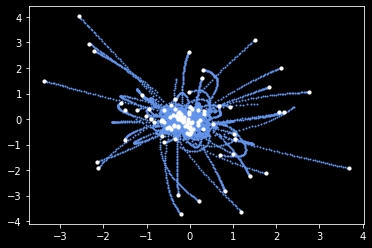

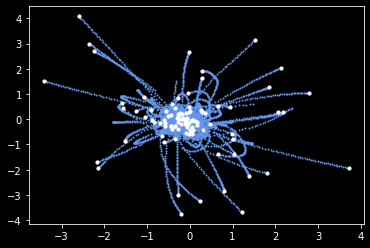

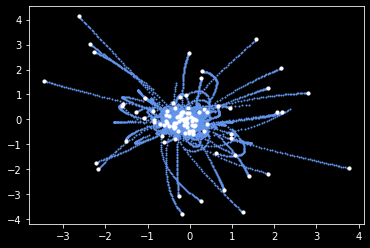

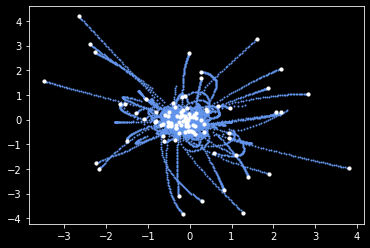

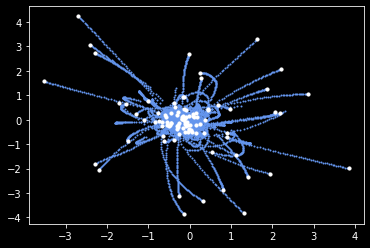

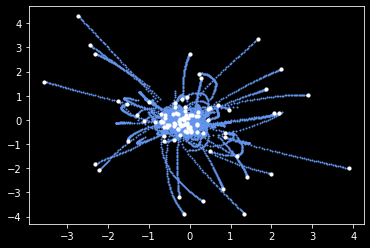

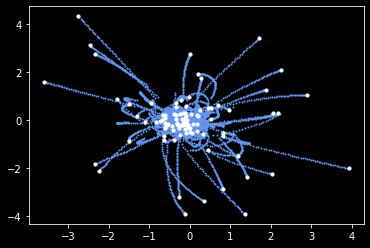

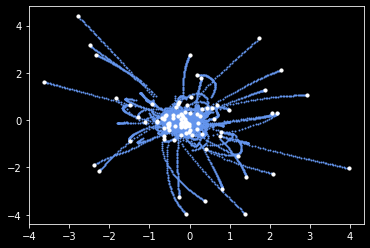

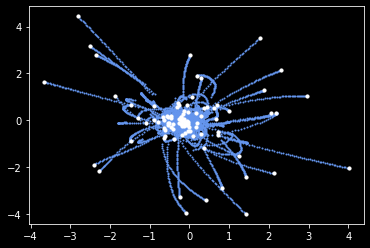

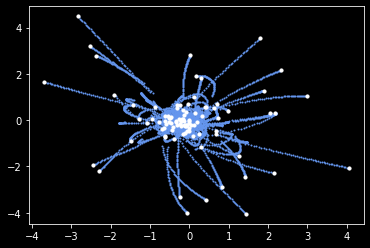

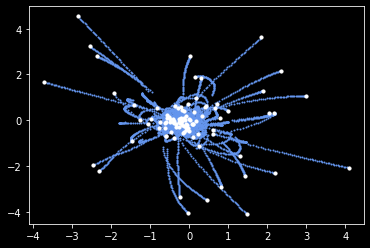

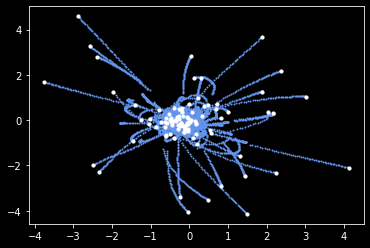

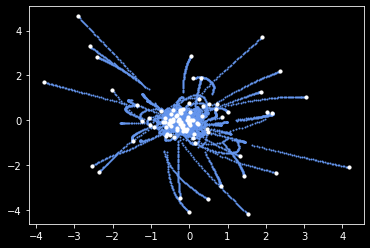

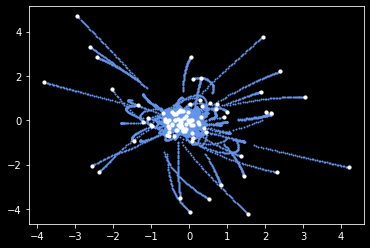

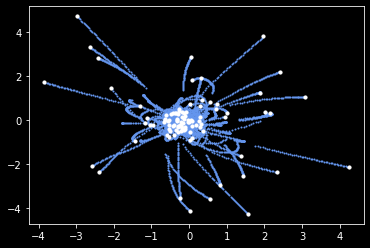

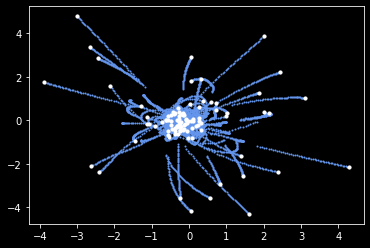

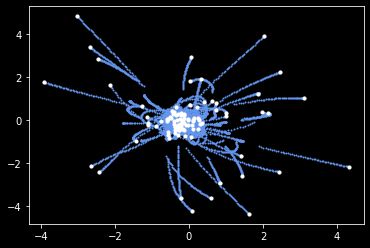

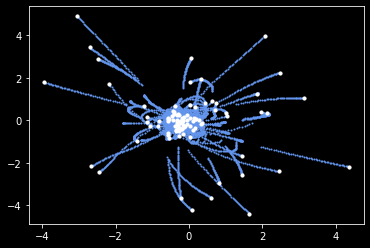

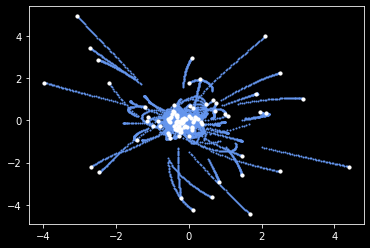

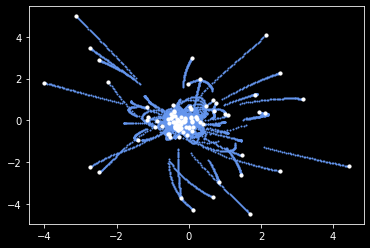

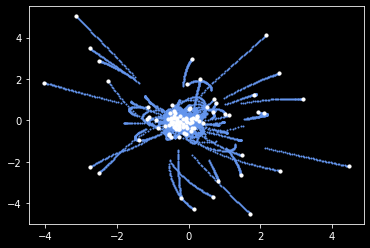

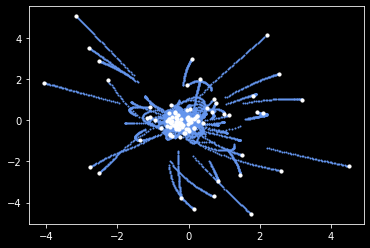

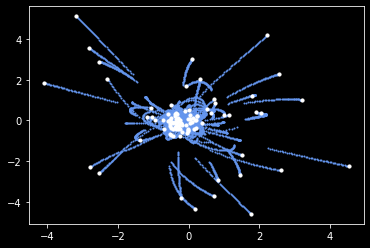

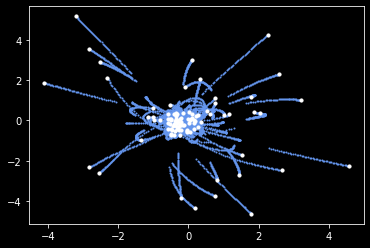

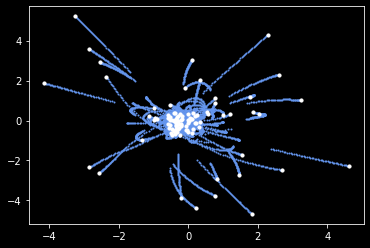

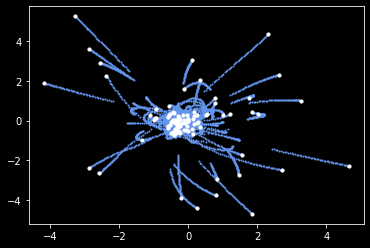

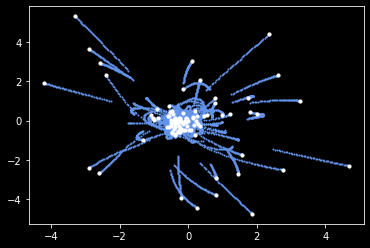

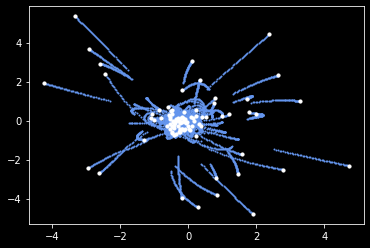

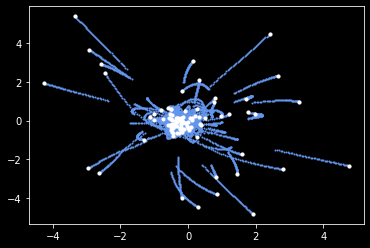

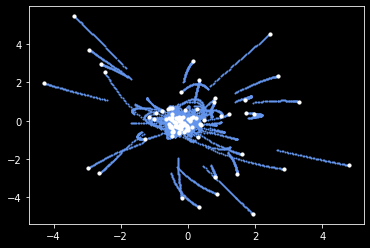

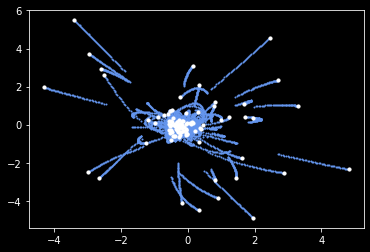

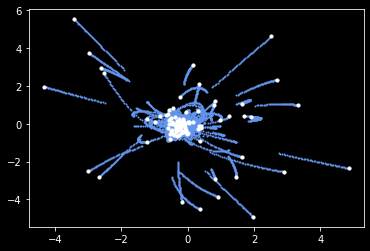

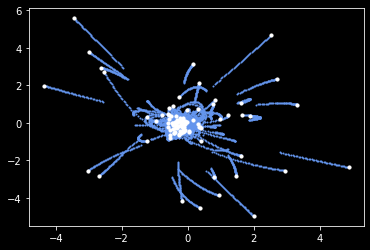

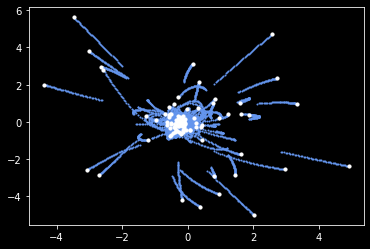

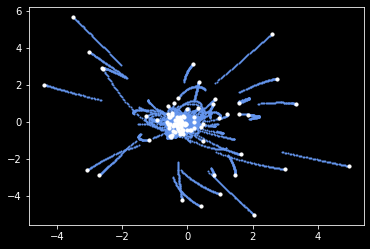

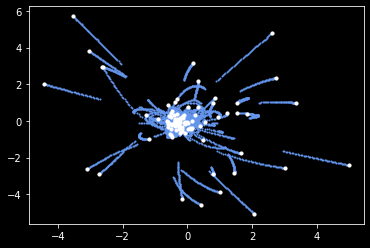

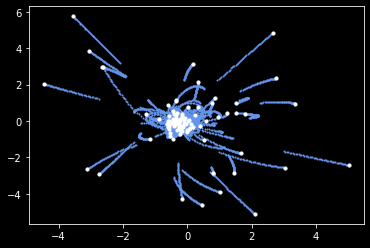

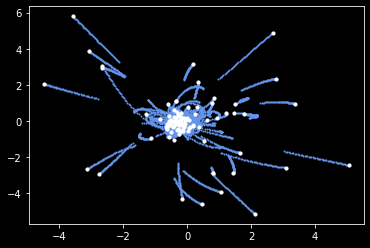

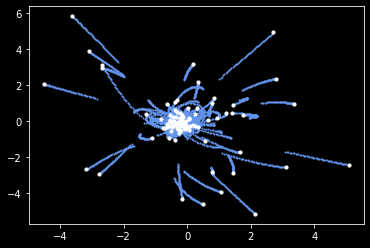

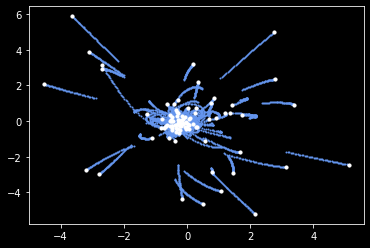

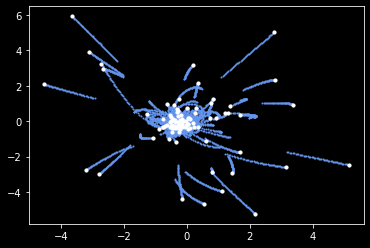

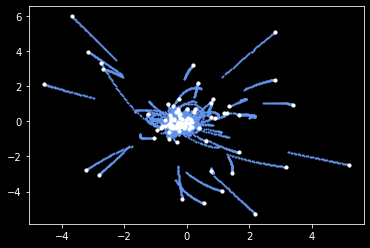

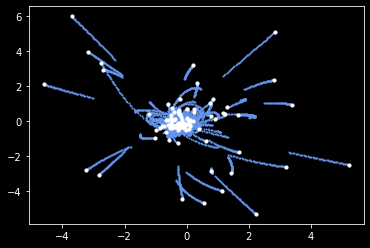

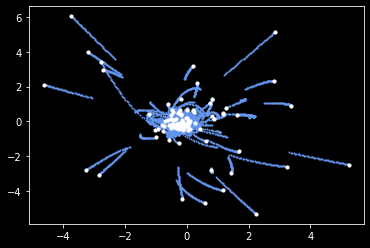

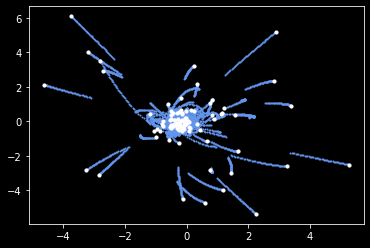

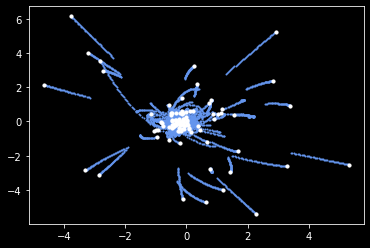

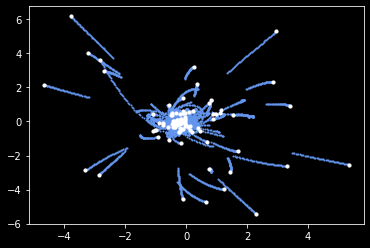

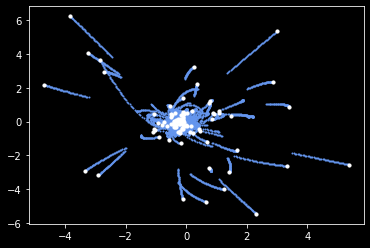

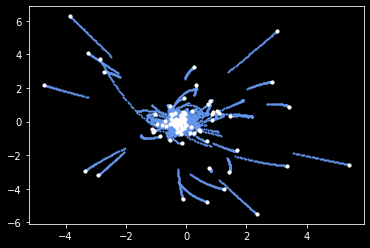

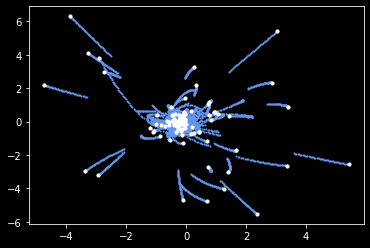

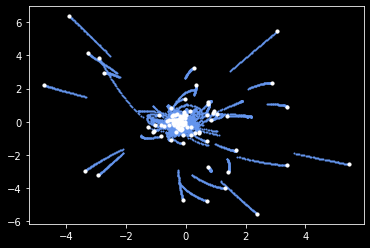

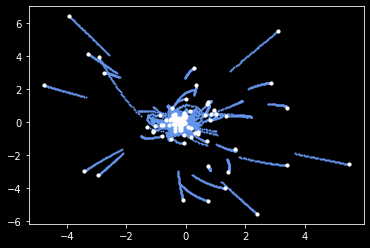

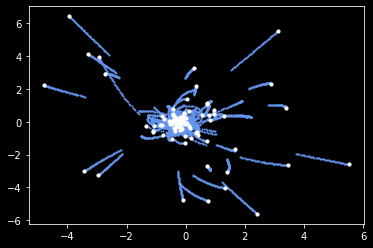

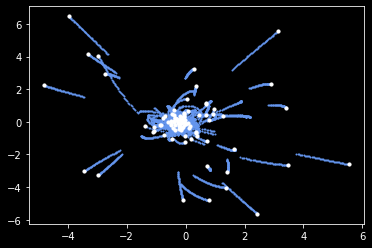

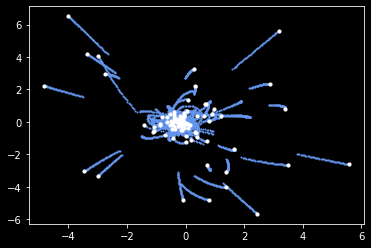

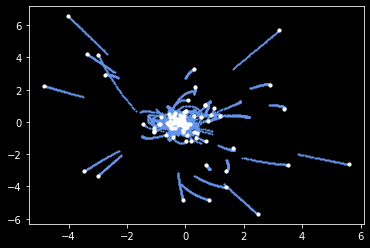

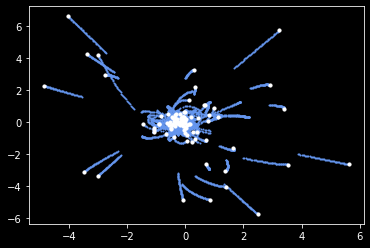

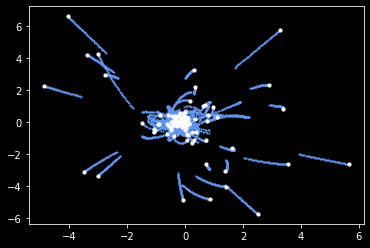

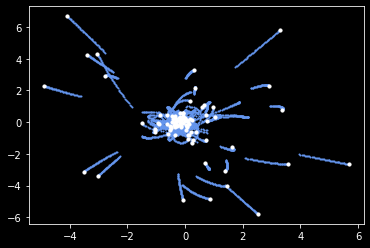

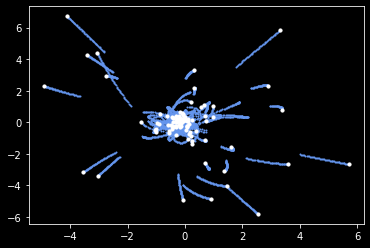

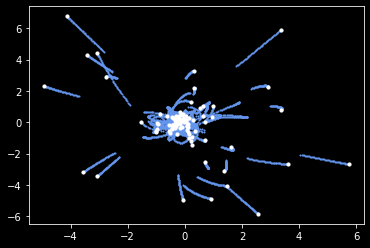

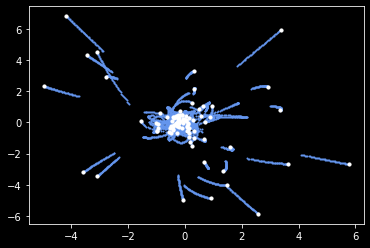

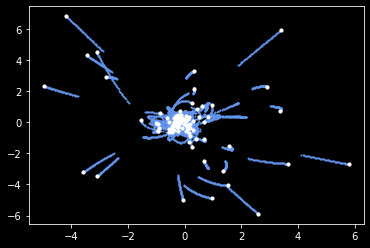

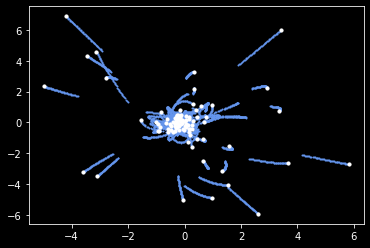

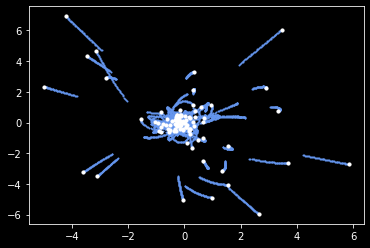

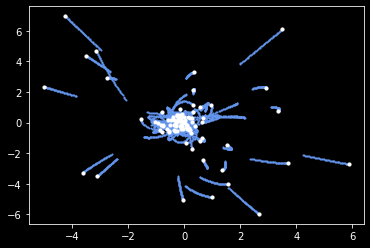

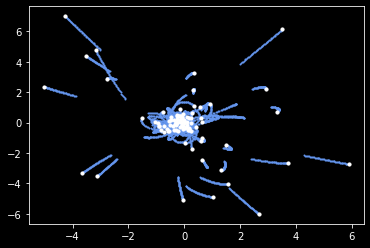

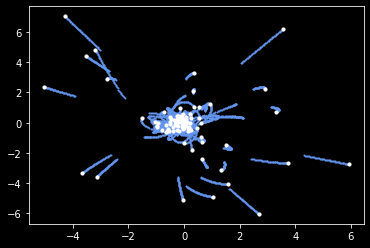

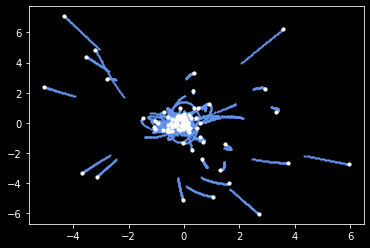

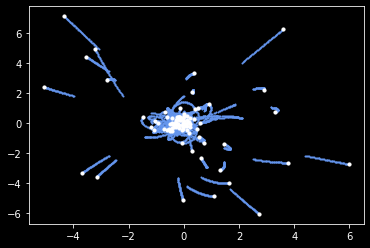

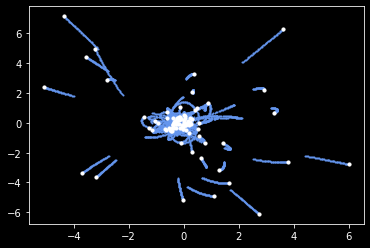

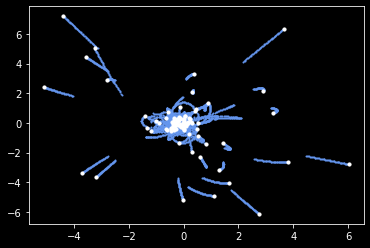

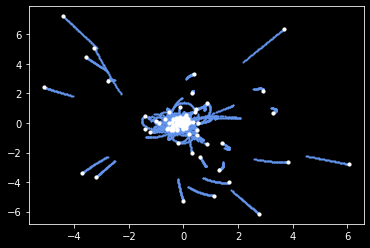

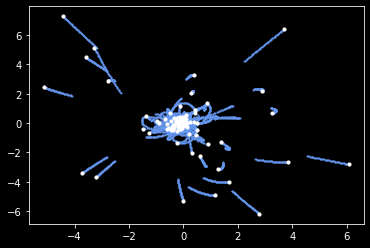

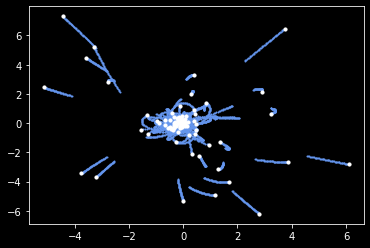

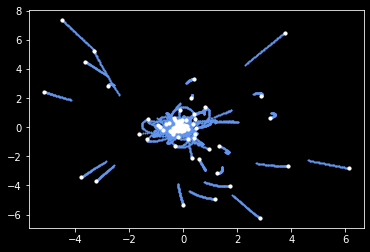

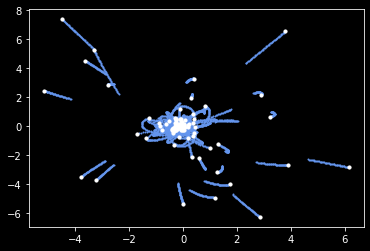

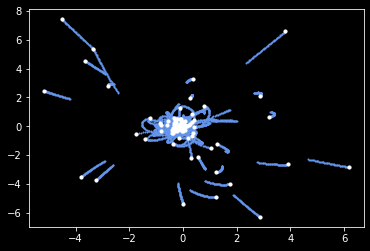

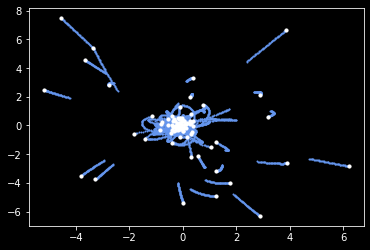

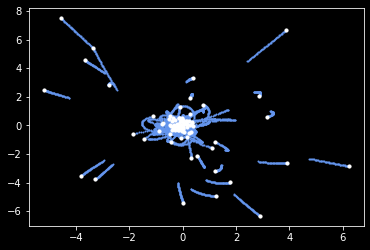

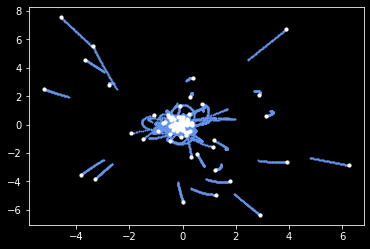

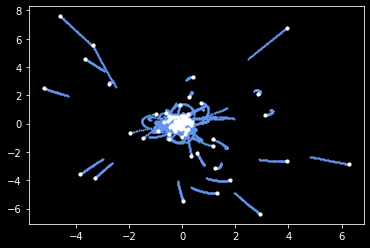

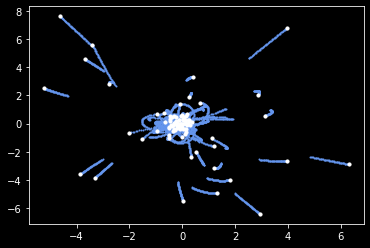

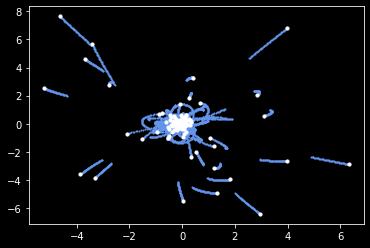

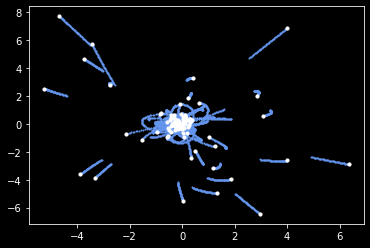

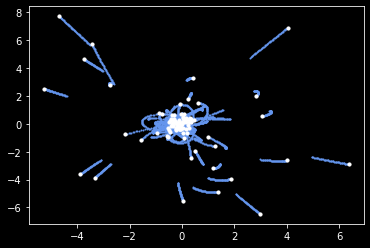

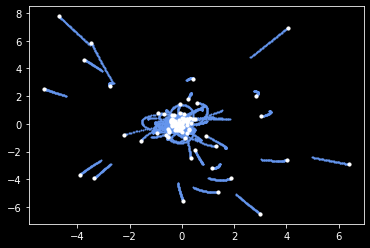

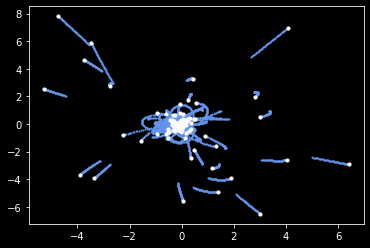

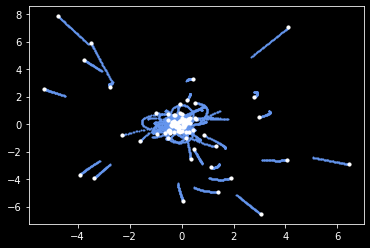

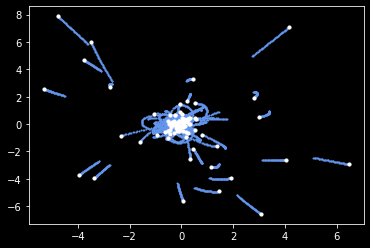

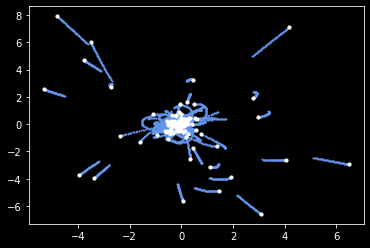

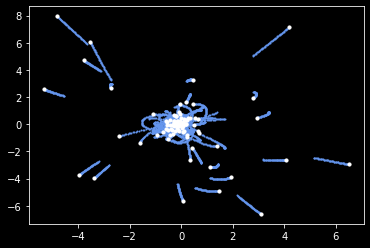

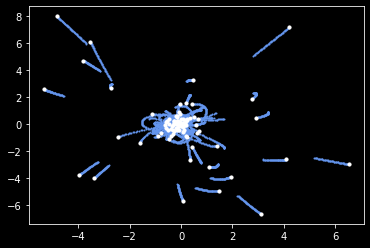

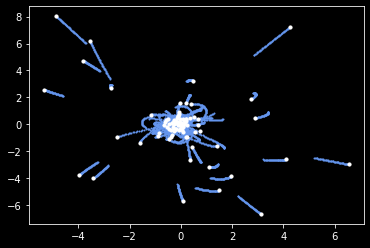

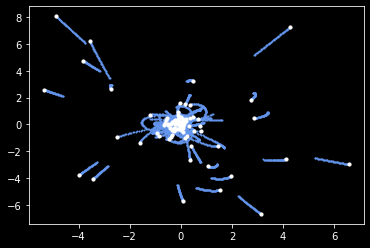

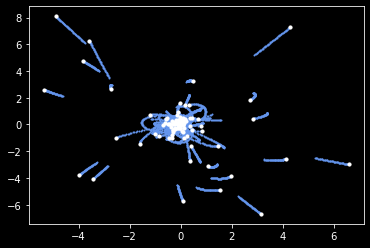

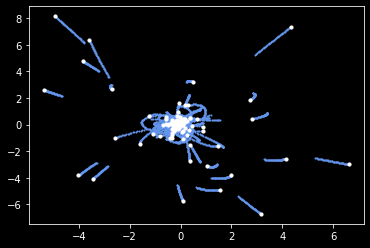

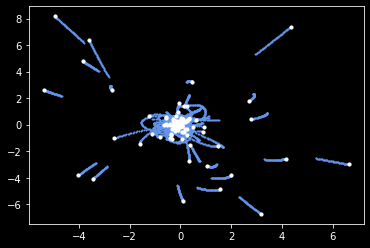

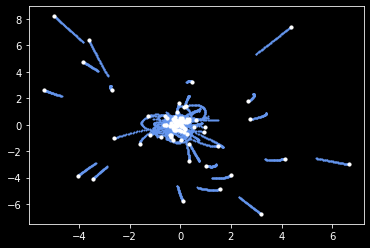

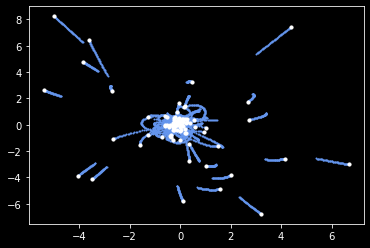

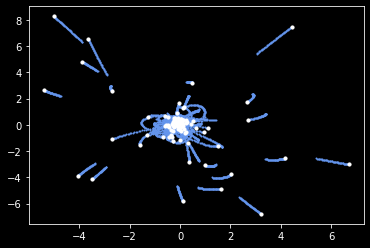

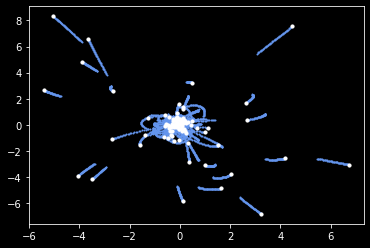

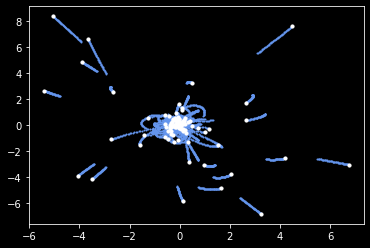

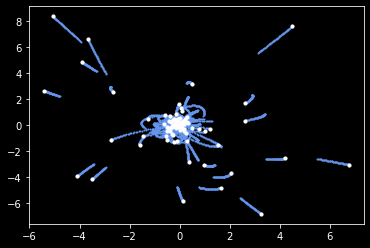

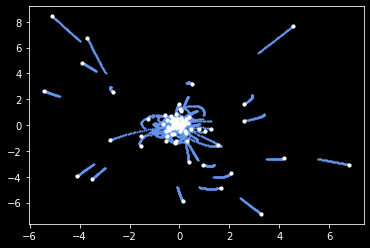

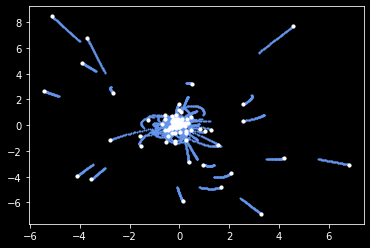

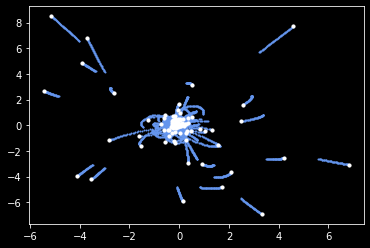

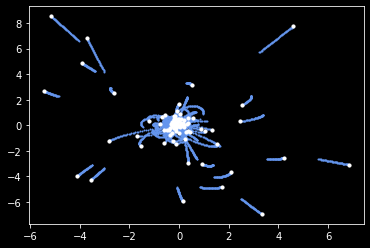

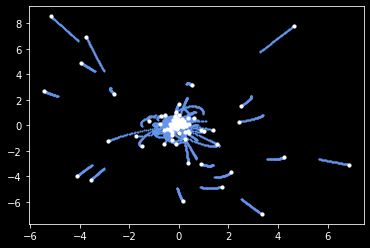

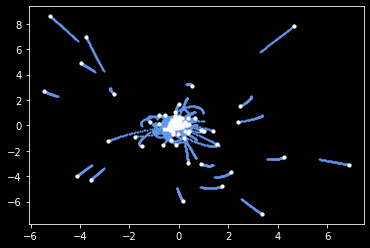

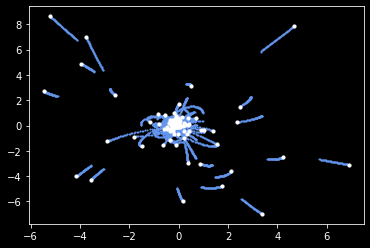

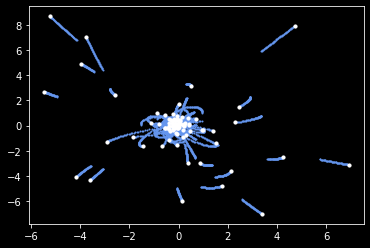

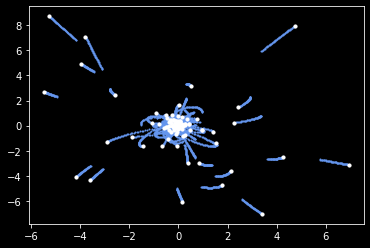

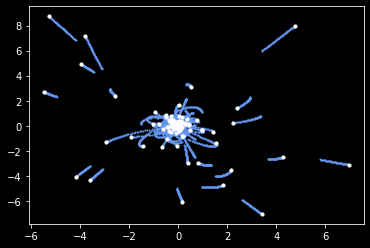

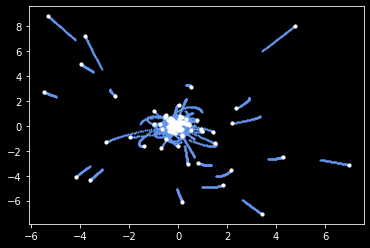

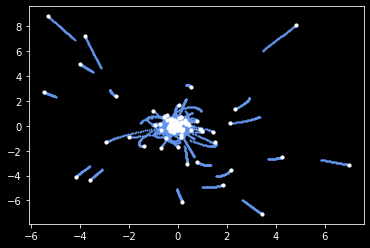

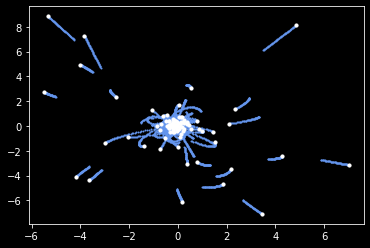

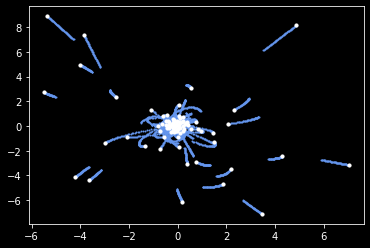

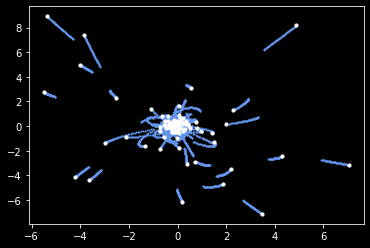

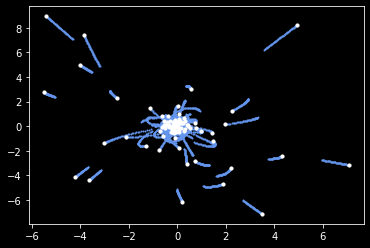

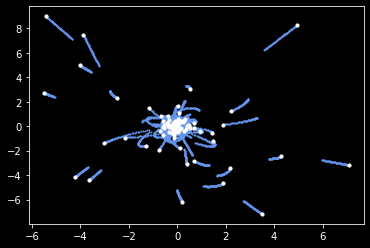

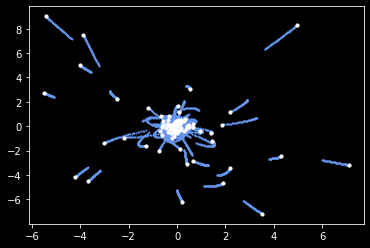

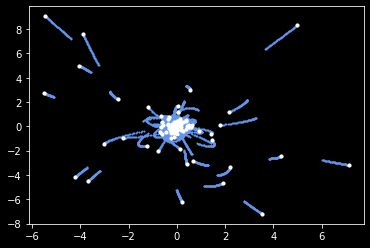

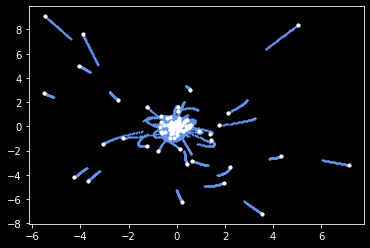

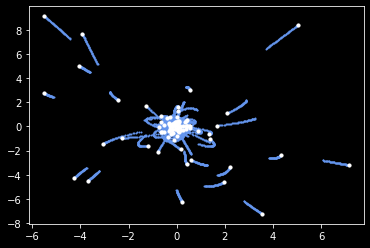

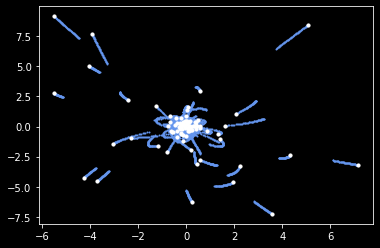

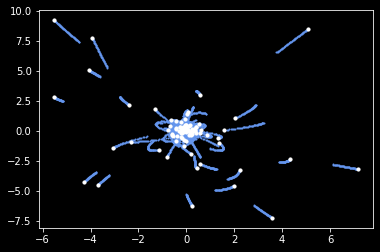

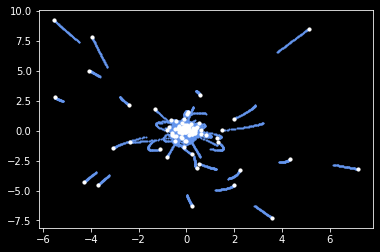

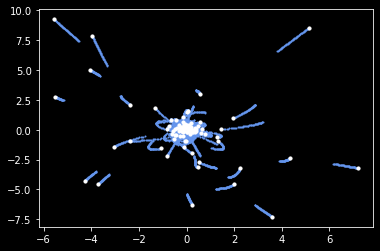

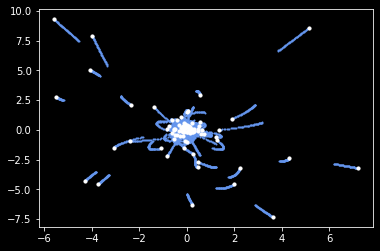

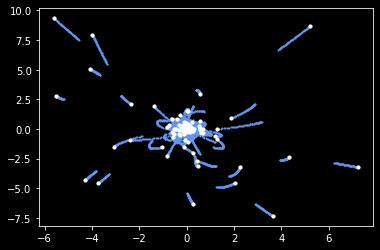

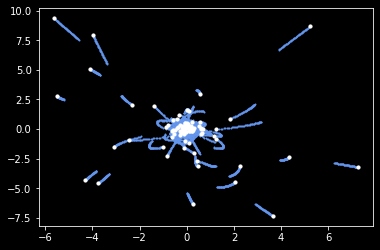

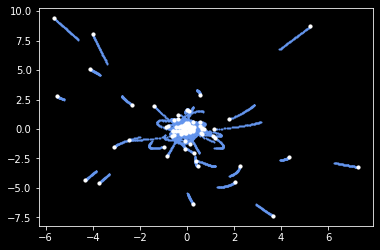

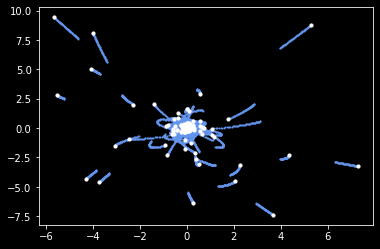

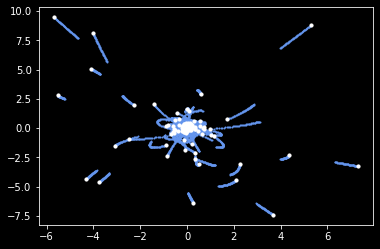

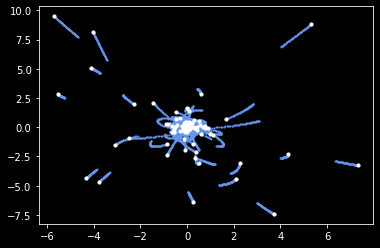

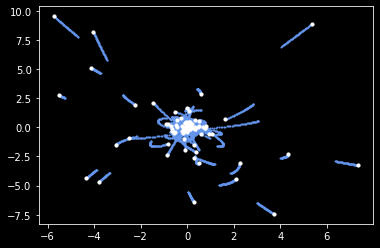

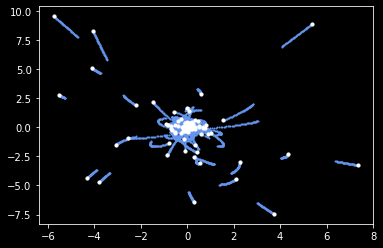

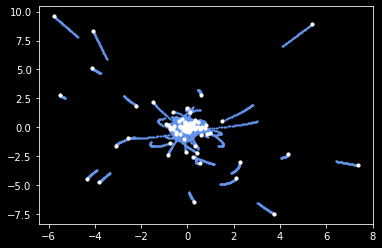

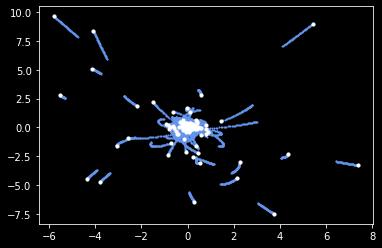

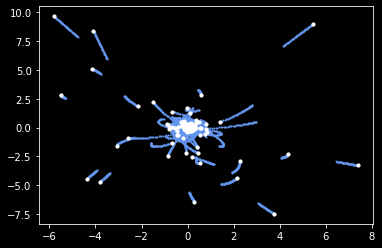

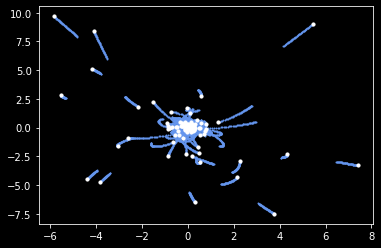

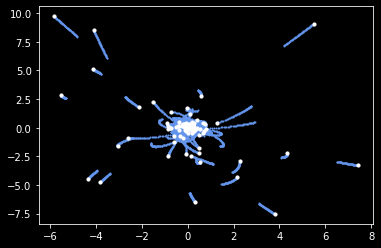

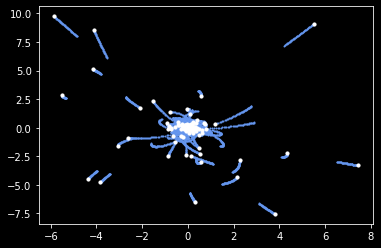

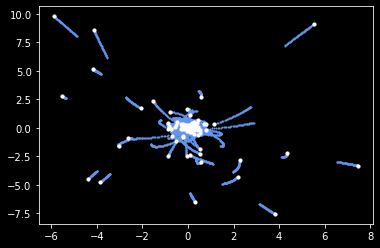

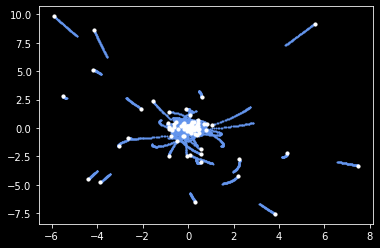

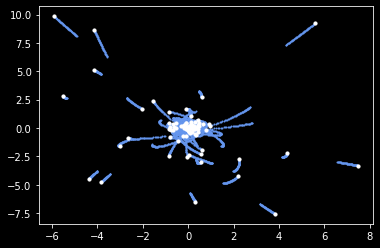

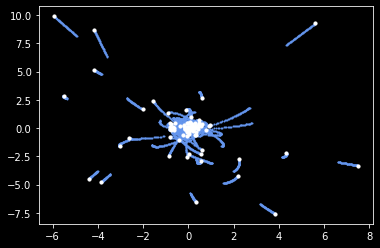

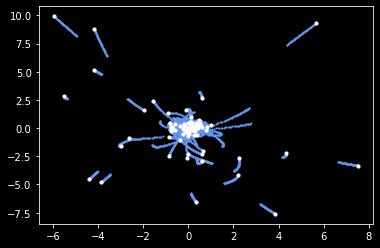

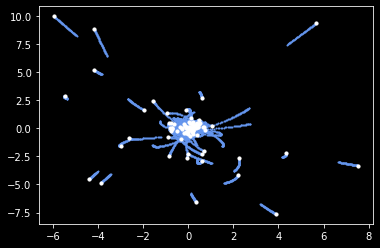

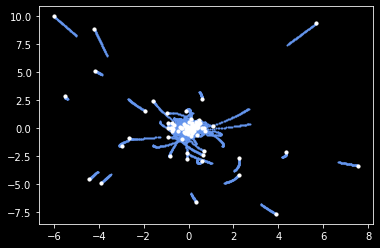

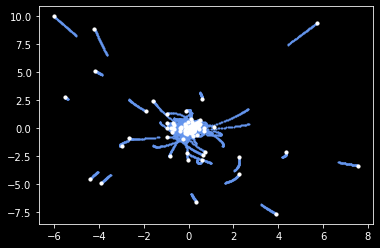

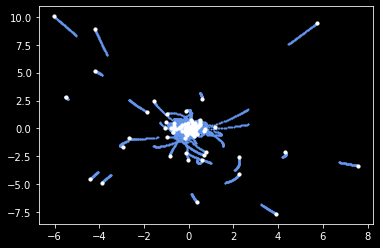

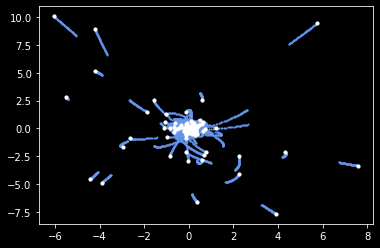

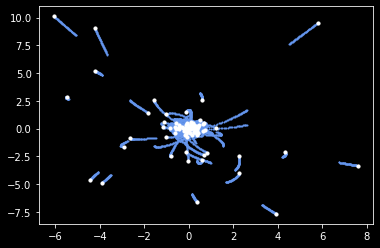

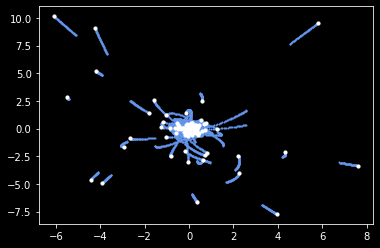

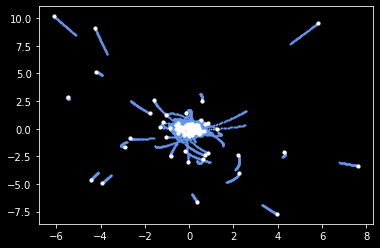

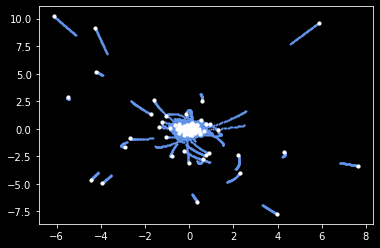

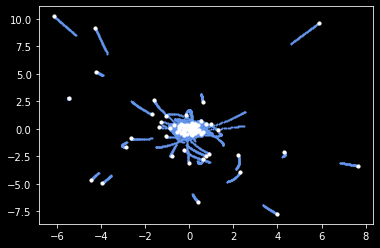

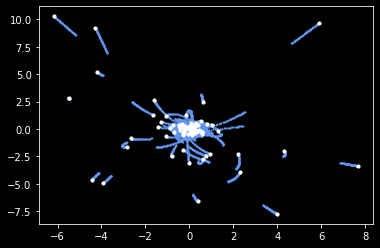

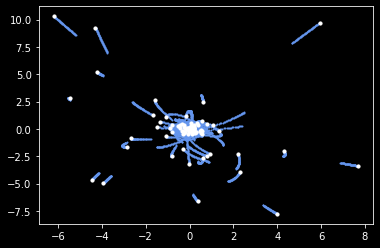

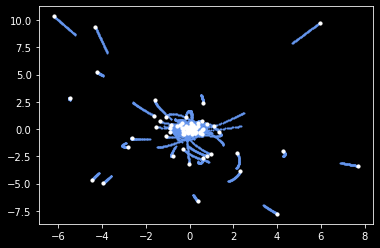

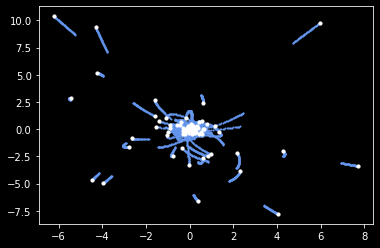

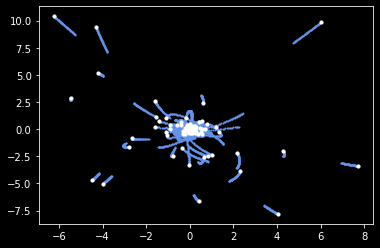

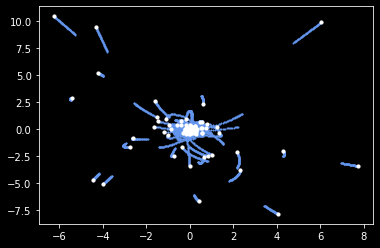

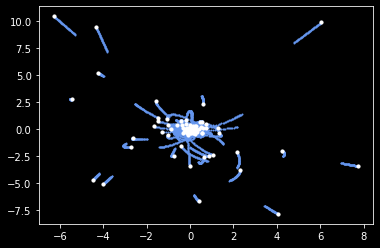

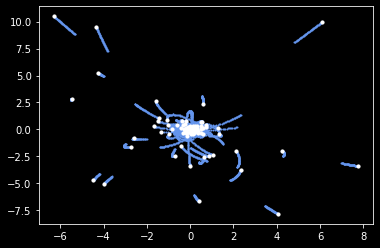

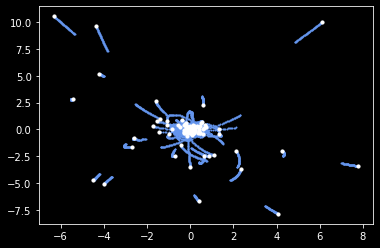

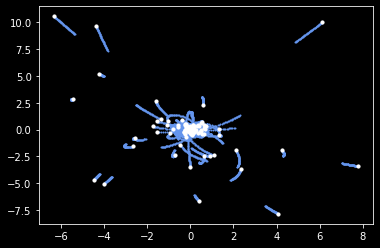

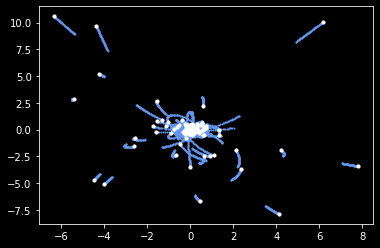

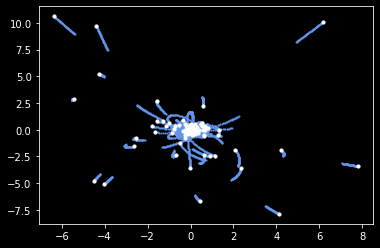

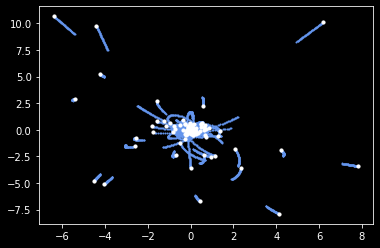

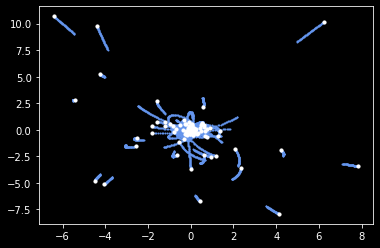

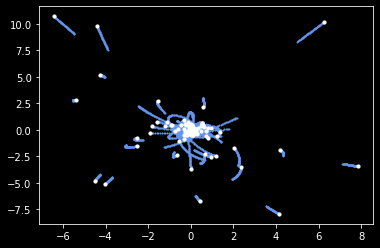

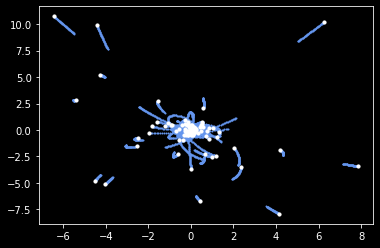

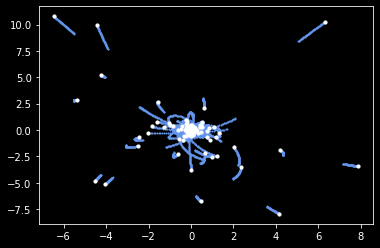

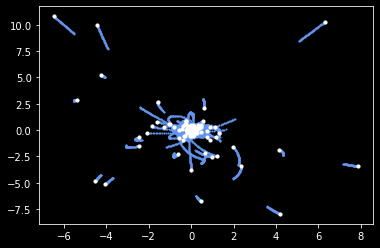

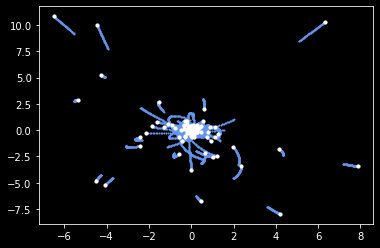

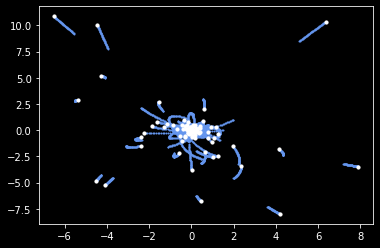

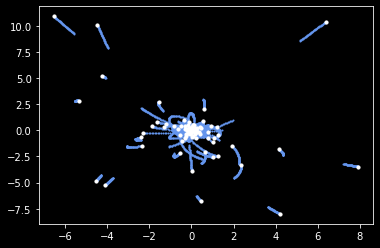

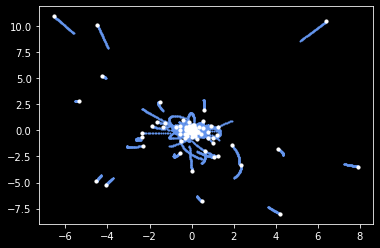

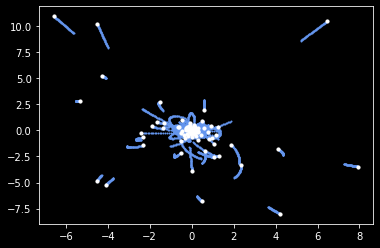

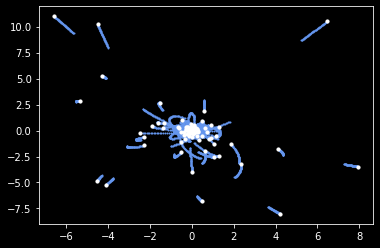

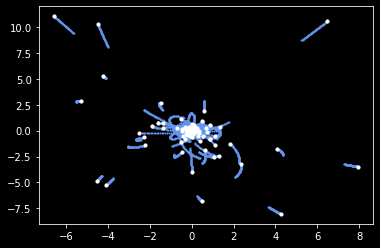

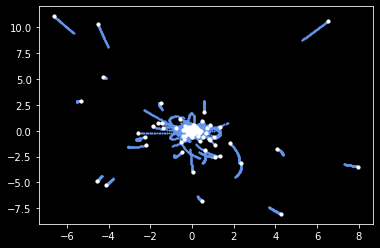

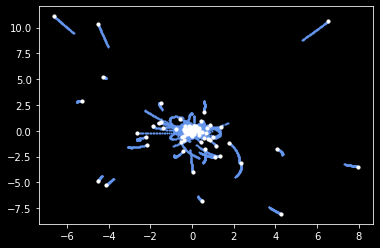

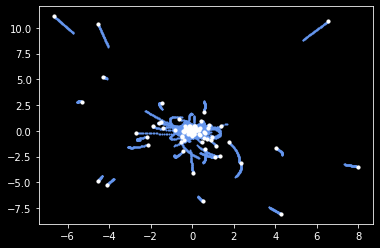

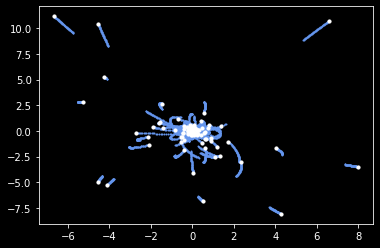

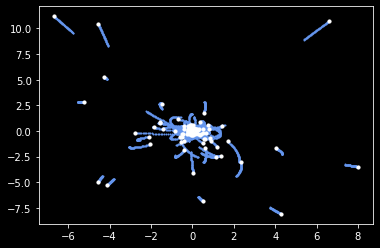

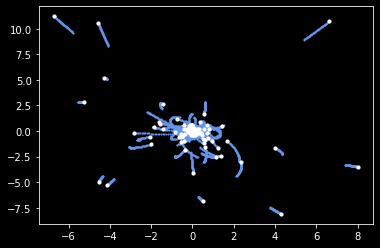

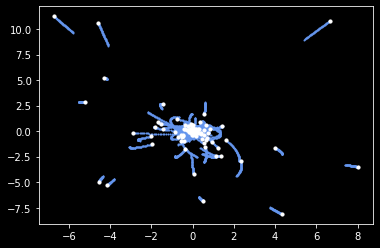

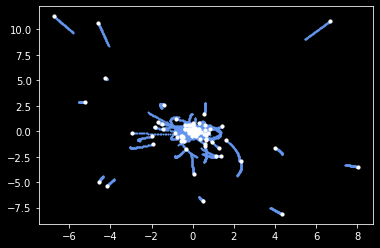

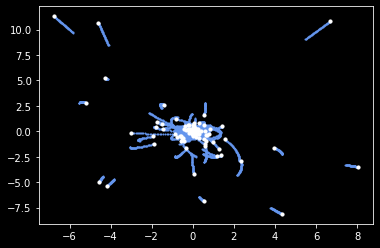

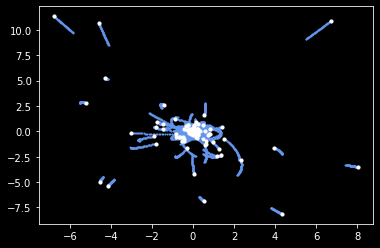

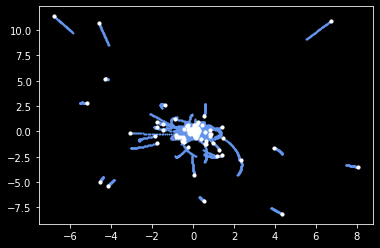

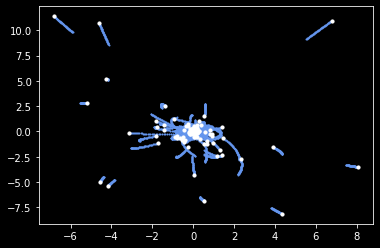

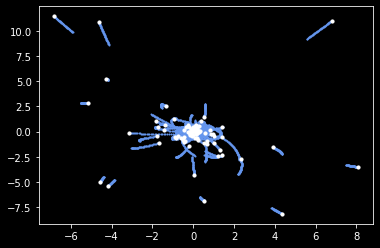

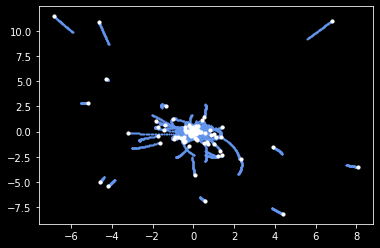

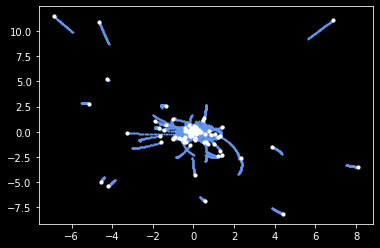

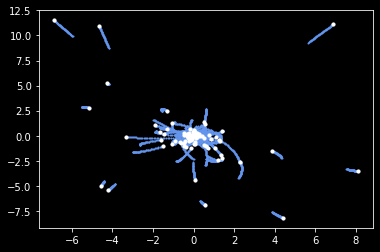

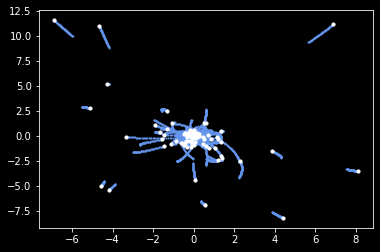

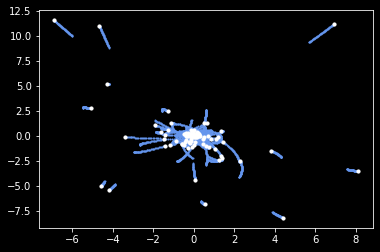

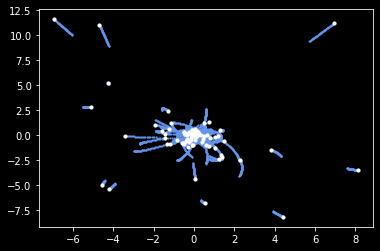

In [115]:
def main():
    
    N         = 100    # number of particles
    t         = 0      # current time of the simulation
    endTime   = 3.0   # time at which simulation ends
    dt        = 0.01   # timestep
    limit     = 0.1    # limit length
    G         = 1.0    # value of Gravitational Constant used for the simulation

    # seeding the random number generator with Unix time 
    np.random.seed(int(time.time()))
    
    M   = 100.0*np.ones((N, 1))/N  # total M of particles is 100
    R   = np.random.randn(N, 3)    # randomly selected positions and velocities
    vel = np.random.randn(N, 3)
    
    # Convert to Center-of-M frame
    vel -= np.mean(M * vel,0) / np.mean(M)
    
    # calculate initial gravitational accelerations
    acc = getAcceleration(limit, G, M, R)
    
    # number of timesteps
    Nt = int(np.ceil(endTime/dt))
    
    # save particle orbits for plotting trails
    position_save = np.zeros((N, 3, Nt+1))
    position_save[:,:,0] = R
    
    # figure
    plt.style.use('dark_background')

    # simulation loop
    for i in range(Nt):
        # using leapfrog integration. https://en.wikipedia.org/wiki/Leapfrog_integration
        # (1/2) kick
        vel += acc * dt/2.0
        
        # drift
        R += vel * dt
        
        # update accelerations
        acc = getAcceleration(limit, G, M, R)
        
        # (1/2) kick
        vel += acc * dt/2.0
        
        # update time
        t += dt
        
        # save positions for plotting trail
        position_save[:,:,i+1] = R
        
        # clear the current figure
        plt.cla()
        xp = position_save[:, 0, max(i-50,0):i+1]
        yp = position_save[:, 1, max(i-50,0):i+1]
        # plotting the trails
        plt.scatter(xp, yp, s=1, color = 'cornflowerblue')
        # plotting the objects
        plt.scatter(R[:,0], R[:,1], s=10, color ='white')
        plt.pause(0.001)
    
    plt.show()
    return 0
    
if __name__== "__main__":
  main()

....

## From there extra stuff not in project

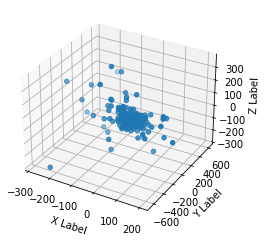

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_stars['x'], df_stars['y'], df_stars['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

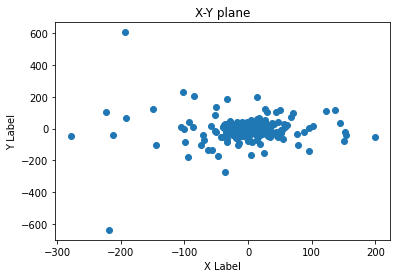

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['x'], df_stars['y'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.title("X-Y plane")
plt.show()

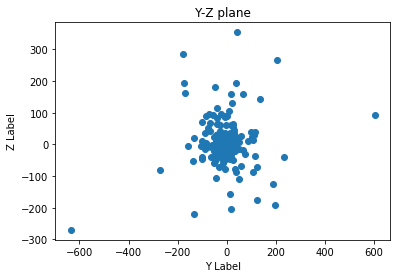

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['y'], df_stars['z'])

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')


plt.title("Y-Z plane")
plt.show()

So I have to first do a histogram of of masses. 
What would the binning be?
Should do a programm that creates bins with changable lentgh and fills them.

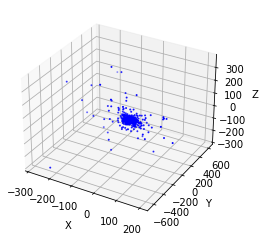

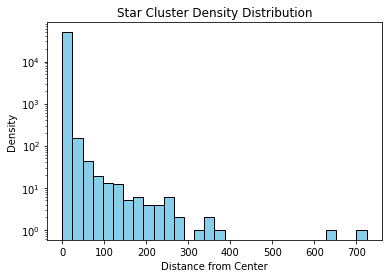

In [68]:
# Assuming 'star_df' is your DataFrame with columns 'x', 'y', 'z'
# Calculate the distance of each star from the center (middle) of the cluster
star_df = df_stars

#star_df['distance'] = np.sqrt(star_df['x']**2 + star_df['y']**2 + star_df['z']**2)

# Plot the 3D distribution of stars (optional but useful for visualization)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(star_df['x'], star_df['y'], star_df['z'], s=1, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Create a histogram of the distances
plt.hist(star_df['distance'], bins=30, color='skyblue', edgecolor='black',log = True)
#plt.xlim(0, 4) 
plt.title('Star Cluster Density Distribution')
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.show()

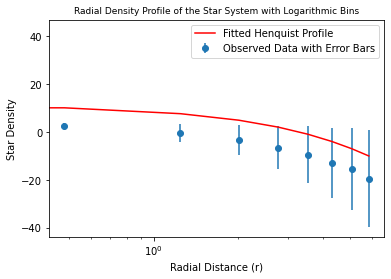

In [67]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes # This is the lambda

# Calculate Poisson errors
errors = np.sqrt(hist) / shell_volumes # This is the np.sqrt(lambda)

# Use curve_fit to find the optimal parameters with errors
params, covariance = curve_fit(hernquist_profile, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)



# Plot the observed data and the fitted profile with error bars
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(errors), fmt='o', label='Observed Data with Error Bars')
plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [ ]:
a_fit

array([1.29013535e+04, 5.33686134e-02])

In [28]:
print(len(params))

array([[3.33099418e+03, 4.76897331e-06],
       [4.76897332e-06, 1.15921231e-07]])

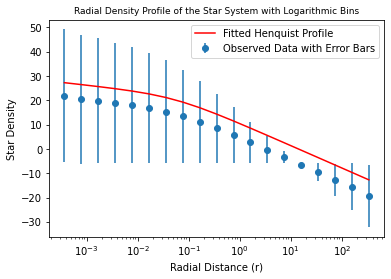

In [52]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin and get the bin edges
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell using the bin edges 
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes

# Use curve_fit to find the optimal parameter for a (scale factor)
params, covariance = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)

#extract the fitted scale factor a
a_fit = params

fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

e_pos = fitted_profile-star_density/np.sqrt(hist)
# Plot the observed data and the fitted profile with error bars
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
#plt.axvline(x=np.log(a_fit), color='red', linestyle='--', label='scale radius a')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [53]:
pcov

array([[inf]])

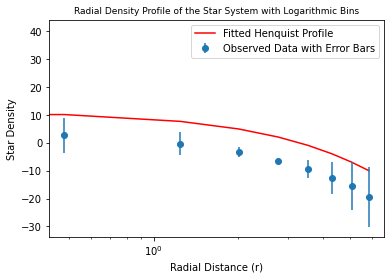

In [54]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [31]:
a_fit

array([0.82558247])

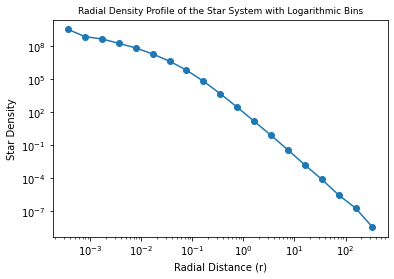

In [71]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], (star_density), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

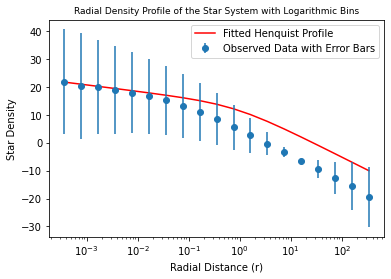

In [8]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

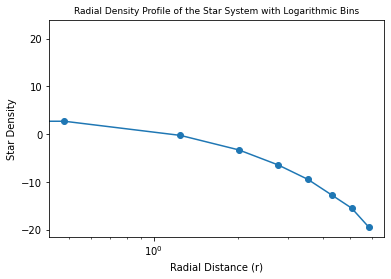

In [66]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3) #

# Calculate star density in each shell for 
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(np.log(bin_edges[:-1]), np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

fixed mass profile a value:[0.005]


/scratch/tmp.42882350.atepper/ipykernel_11146/4042980114.py:9: RuntimeWarning:

divide by zero encountered in divide

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:31: RuntimeWarning:

divide by zero encountered in log

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:33: RuntimeWarning:

divide by zero encountered in log



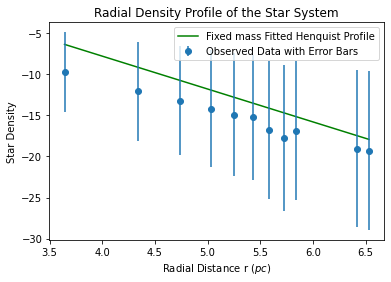

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins
bins = np.linspace(0, np.max(radial_distances), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,p0=0.005)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')






# Plot the radial density profile
#plt.plot(np.log(bin_edges[:-1]), np.log(regular_fitted_profile), label='Fitted Henquist Profile', color='red')
plt.plot(np.log(bin_edges[:-1]), np.log(fixed_M_fitted_profile), label='Fixed mass Fitted Henquist Profile', color='green')
#plt.scatter(np.log(bins[:-1]), np.log(star_density), marker='o')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(sigma), fmt='o', label='Observed Data with Error Bars')
plt.xlabel('Radial Distance r ($pc$)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Radial Density Profile of the Star System')
plt.show()

In [ ]:
result_df = df[df['your_column'] == desired_value]


In [177]:
example_star = df_stars[df_stars["distance"] == 724.689657812915  ] 

In [178]:
example_star

mass        x        y        z       vx       vy       vz  soft  \
33830  92.4259 -219.267 -635.776 -269.974  61.1198 -28.4596  32.0028   0.1   

            pot    distance  
33830  0.013022  724.689658

In [179]:
r_tot = 724.689657812915#pc
v = np.sqrt(total_mass/724.689657812915)

In [180]:
v

79.86366559905319

In [ ]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'
data = {'StarID': [1, 2, 3],
        'X': [1.0, 2.0, 3.0],
        'Y': [1.0, 1.5, 2.0],
        'Z': [5.0, 4.0, 2.0]}

star_cluster_df = pd.DataFrame(data)

# Calculate the Euclidean distance for each pair of particles (numpy)
distances_np = np.linalg.norm(star_cluster_df[['X', 'Y', 'Z']].values, axis=1)
print(distances_np)
# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['X', 'Y', 'Z']].values, metric='euclidean')
print(pairwise_distances)
# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_np = distances_np[distances_np != 0].mean()
mean_distance_scipy = non_diagonal_distances.mean()

print(f"Mean Distance between particles (numpy): {mean_distance_np}")
print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

In [ ]:
#Parallelized version. Not sure if works, because 1000 particle really did not show any speed up against the regular on
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def pairwise_distance(args):
    i, j, star_coordinates = args
    return euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])

def mean_distance(star_coordinates):
    num_stars = len(star_coordinates)
    total_distance = 0.0

    # Using ThreadPoolExecutor for parallelization
    with ThreadPoolExecutor() as executor:
        # Create a list of argument tuples for pairwise_distance function
        args_list = [(i, j, star_coordinates) for i in range(num_stars) for j in range(i+1, num_stars)]
        
        # Map the pairwise_distance function to the list of arguments using multiple threads
        distances = list(executor.map(pairwise_distance, args_list))

        # Sum up the distances
        total_distance = sum(distances)

    # Calculate the mean distance
    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
    return mean_distance

# Example coordinates of 10 stars in a DataFrame
# the half mass radius stars coordinates
star_cluster_df = f_df_stars[["x","y","z"]][:1000]

result = mean_distance(star_cluster_df)
print(f"Mean distance between stars: {result}")

In [35]:
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force

In [38]:
stars = df_stars[:2]
i=0
j=1
calculate_force(stars['mass'][j],
                stars['x'][i], stars['y'][i], stars['z'][i],
                stars['x'][j], stars['y'][j], stars['z'][j], epsilon)

array([ -270.48838683, -1612.50867626,    77.70457927])

In [37]:
stars = df_stars[:2]
stars["mass"]

0    92.4259
1    92.4259
Name: mass, dtype: float64

In [ ]:

#plt.plot(distance_r_list, theor_mags_list, marker='_',label='Theoretical forces acting on a star', color='blue')
#for i,distance_r in enumerate(distance_r_list):
for i,epsilon in enumerate(epsilons):
#    plt.plot(df_num_mags.loc[i].values, distance_r_list, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
    plt.plot(distance_r_list, df_num_mags.loc[i].values, marker='_',label=f'Numerical forces acting on star with $\epsilon$={epsilon}')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 9)
plt.show()

Old version of direct force calculation beofre changing for loops

In [109]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force
# Function to calculate total force on each star
def calculate_total_force(stars, epsilon):
    forces = np.zeros((len(stars), 3))

    for i in range(len(stars)):
        #print(i)
        for j in range(len(stars)):
            if i != j:
                force = calculate_force(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
                forces[i] += force

    return forces

In [ ]:
#Seems to work better.
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force


def calculate_force_parallel_proc(i):
    if i % 1000 == 0:
        print(i)
    
    forces = np.zeros(3)
    for j in range(len(stars)):
        if i != j:
            
            forces += calculate_force( stars['mass'][j],
                                       stars['x'][i], stars['y'][i], stars['z'][i],
                                       stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
        else: 
            forces += np.zeros(3)
        
    return forces 
def calculate_total_force_parallel_proc(stars, epsilon, num_workers=30):
    with ProcessPoolExecutor(max_workers = num_workers) as executor:
        nr_stars = range(len(stars))
        results = executor.map(calculate_force_parallel_proc, nr_stars)
    
    
    forces = np.array(list(results))
    
    return forces

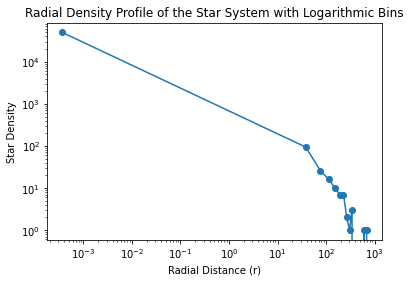

In [102]:
# define radial distances
radial_distances = df_stars["distance"]
# Define logarithmic bins
log_bins = np.linspace(np.min(radial_distances),np.max(radial_distances), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes

# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], hist, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins')
plt.show()

In [103]:
hist

array([49842,    94,    26,    16,    10,     7,     7,     2,     1,
           3,     0,     0,     0,     0,     0,     0,     1,     0,
           1])

In [109]:
a_guess = 0.05

In [120]:
def hernquist_profile_fixed_M_log(r, a):
    return np.log10(4622219.259/ (2 * np.pi)) + np.log10(a) - np.log10(r) - 3* np.log10(r + a)

In [153]:
a_guess = 0.07817867

fixed mass profile a value:[0.0977247]


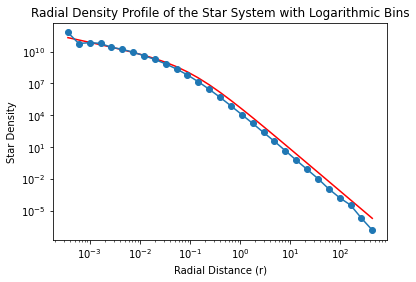

In [160]:
# define radial distances
radial_distances = df_stars["distance"]
# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 30)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
# Star mass
lone_star_mass 
star_density = hist * 92 / shell_volumes



a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, p0=a_guess, sigma = np.sqrt(star_density),absolute_sigma = True)
#a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')


#Error
#e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, label='Fitted Henquist Profile', color='red')
# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], star_density, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins')
plt.show()

In [ ]:
def hernquist_profile(r, M, a):
    return M / (2 * np.pi) * (a / r) * (1/(r + a)**3)

def hernquist_profile_fixed_M(r, a):
    return total_mass / (2 * np.pi) * (a / r) * (1/(r + a)**3)

To test and use the treecode I will first use some small toy subsamle. Say 213 stars at radius 0.0055 pc

For the treecode I will probably use the octree implementation. From chat gpt:

### Step 1: Understand the Problem
You have a dataset describing a star cluster with columns for mass and 3D coordinates (x, y, z) of each star.

### Step 2: Define Particle and TreeNode Classes
Create a Particle class to represent stars with attributes like mass, position, and force.

Create a TreeNode class to represent nodes in the octree, storing information such as center, size, total mass, center of mass, and children.

### Step 3: Build the Octree
Define a function to build the octree (build_tree).

The function should take stars, a center, and a size as parameters.

Initialize the root node with the provided center and size.

Iterate over each star in the dataset and insert it into the octree.

To insert a star, navigate through the tree recursively, creating child nodes as needed.

### Step 4: Inserting Stars into the Octree
When inserting a star into a node, check if the star is within the boundaries of the node.

If the node is a leaf (no children), update the total mass and center of mass of the node.

If the node has children, determine the appropriate child node based on the star's position and insert the star there.

### Step 5: Compute Forces Using the Octree
Define a function to compute forces (compute_force).

Given a particle (star) and a node, calculate the distance vector between the particle and the center of mass of the node.

Use the Barnes-Hut criterion to decide whether to use the center of mass approximation or recurse into the node's children.

If approximating, calculate the gravitational force and update the particle's force attribute.

### Step 6: Main Function
Create a main function to orchestrate the entire process.

Load your star data into a list of Particle objects.

Build the octree using the build_tree function.

Iterate over each star and compute forces using the compute_force function.

Print or store the results.

### Step 7: Adjust Parameters

Tweak parameters such as the initial size of the space in the octree, the Barnes-Hut criterion threshold, and others based on your specific 
dataset and performance requirements.

### Step 8: Testing and Optimization

Test your implementation with different datasets to ensure correctness.

Optimize the code based on profiling and performance considerations.

By following these logical steps, you can implement an octree-based algorithm for calculating forces in your star cluster dataset efficiently.




In [ ]:
#old tree code stuff
#Define a class for particles that describes its mass,position and force

class starObj:
    def __init__(self, position, org_index = None):
        self.mass = 92.4259 #every star has same mass anyway
        self.position = np.array(position)
        self.force = np.zeros(3)
        self.org_index = org_index

#Define a octree treenode
class TreeNode:
    def __init__(self, center, size):
        self.center = np.array(center)
        self.size = size
        self.total_mass = 0
        self.center_of_mass = np.zeros(3)
        self.children = [None] * 8 #octree structure

In [ ]:
def insert_star(node,star):
    #first lets check if the star is inside the current node's region
    if(
        abs(star.position[0] - node.center[0]) < 0.5 * node.size and
        abs(star.position[1] - node.center[1]) < 0.5 * node.size and
        abs(star.position[2] - node.center[2]) < 0.5 * node.size
    ):
        if all(child is None for child in node.children):#check if all the children nodes are None in a node # 
            #if this condition true this is a leaf node so only star (no children)
            print("no children")
            node.total_mass += star.mass
            node.center_of_mass += star.mass *star.position
        #but if it is not the only star (so there are children) insert the star inside the first nodes children
        else:
            i = 0
            #finding the corresponding octant from 
            for dim in range(3):
                if star.position[dim] > node.center[dim]:
                    i |= (1 << dim) #some trick I found to ("Use bitwise OR to set the corresponding bit")
            #print(i)
            
            if node.children[i] is None:
                # Create child node if it doesn't exist = None
                child_center = [
                    node.center[0] + 0.25 * node.size * (1 if i & 1 else -1),
                    node.center[1] + 0.25 * node.size * (1 if i & 2 else -1),
                    node.center[2] + 0.25 * node.size * (1 if i & 4 else -1),
                ]
                #insert the child node
                print("inserting child")
                node.children[i] = TreeNode(child_center, 0.5 * node.size)
            # Recursively insert the star into the appropriate child node
            insert_star(node.children[i], star)

In [ ]:
def compute_force(particle, node):
    G = 1  # gravitational constant

    # Calculate distance vector between the particle and the center of mass of the node
    r = node.center_of_mass - particle.position
    distance = np.linalg.norm(r)

    # Use the Barnes-Hut criterion to check if the node can be approximated
    theta = 0.5 # Adjust this threshold as needed
    if node.size / distance < theta:
        print(node.size / distance)
        # Node is sufficiently far, use center of mass to calculate force
        force_magnitude = G * particle.mass * node.total_mass / distance**3
        particle.force += force_magnitude * r
    else:
        print("else")
        # Recursively compute forces for the node's children
        for child in node.children:
            if child is not None:
                print("recursive")
                compute_force(particle, child)

In [ ]:
stars = []
for index,row in df_examp_stars[["x","y","z"]].iterrows(): #take the original index and coordinates of a star
    #print(index)
    #print(row.values)
    star = starObj(position = row.values, org_index = index)
    stars.append(star)

In [ ]:
#My brain is melting here this might not be correct.

#a node is separeted into octants
#bottom-left-front = (-x,-y-z) = blf
#blb = botto-left-back
blf = [-0.5,-0.5,-0.5]#(000): Bottom-left-front octant i = 0
brf = [+0.5,-0.5,-0.5]#(001): Bottom-right-front octant i = 1
tlf = [-0.5,+0.5,-0.5]#(010): Top-left-front octant i = 2
trf = [+0.5,+0.5,-0.5]#(011): Top-right-front octant i = 3
blb = [-0.5,-0.5,+0.5]#(100): Bottom-left-back octant i = 4
brb = [+0.5,-0.5,+0.5]#(101): Bottom-right-back octant i = 5
tlb = [-0.5,+0.5,+0.5]#(110): Top-left-back octant i = 6
trb = [0.5,0.5,0.5]#(111): Top-right-back octant i = 7
node_center = [0,0,0]
i = 0

#finding the corresponding octant from 
for dim in range(3):
    if trb[dim] > node_center[dim]:
        i |= (1 << dim) #some trick I found to ("Use bitwise OR to set the corresponding bit")
print(i)

In [ ]:
if node.children[i] is None:
    # Create child node if it doesn't exist
    child_center = [
        node.center[0] + 0.25 * node.size * (1 if i & 1 else -1),
        node.center[1] + 0.25 * node.size * (1 if i & 2 else -1),
        node.center[2] + 0.25 * node.size * (1 if i & 4 else -1),
    ]

/scratch/tmp.44193610.atepper/ipykernel_86988/3333241215.py:23: RuntimeWarning:

divide by zero encountered in divide



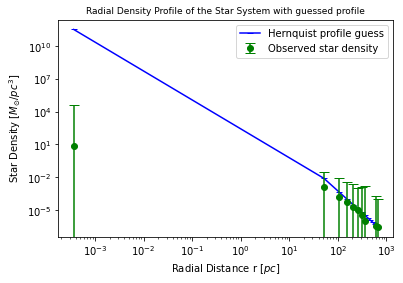

In [32]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

#bins = np.logspace(np.log(np.min(radial_distances)), np.log(np.max(radial_distances)), 50)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

#find the denisty of stars in solar_masses per cubic parsec
# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 

#Guessef fixed mass profile
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_guess)

#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero


# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile guess', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 9)
plt.show()

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning:

divide by zero encountered in divide

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated

/scratch/tmp.44193610.atepper/ipykernel_86988/428110446.py:24: RuntimeWarning:

divide by zero encountered in divide



fixed mass profile a value:[0.07817867]


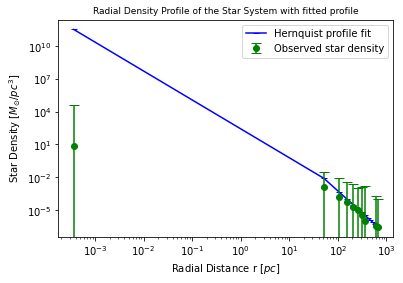

In [33]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, p0=a_guess, sigma = np.sqrt(star_density),absolute_sigma = True)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')


#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero




# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile fit', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with fitted profile', fontsize = 9)
plt.show()

In [36]:
#Defininf total mass and hernquist profiles
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile

def hernquist_profile(r, M, a):
    return M / (2 * np.pi) * (a / r) * (1/(r + a)**3)

def hernquist_profile_fixed_M(r, a):
    return total_mass / (2 * np.pi) * (a / r) * (1/(r + a)**3)

In [37]:
lone_star_mass = df_stars["mass"].values[0]
examp_stars = [
      [lone_star_mass,-0.45,-0.45,-0.45],#(000): Bottom-left-front octant i = 0
      [lone_star_mass,+0.45,-0.45,-0.45],#(001): Bottom-right-front octant i = 1
      [lone_star_mass,-0.45,+0.45,-0.45],#(010): Top-left-front octant i = 2
      [lone_star_mass,+0.45,+0.45,-0.45],#(011): Top-right-front octant i = 3
      [lone_star_mass,-0.45,-0.45,+0.45],#(100): Bottom-left-back octant i = 4
      [lone_star_mass,+0.45,-0.45,+0.45],#(101): Bottom-right-back octant i = 5
      [lone_star_mass,-0.45,+0.45,+0.45],#(110): Top-left-back octant i = 6
      [lone_star_mass,0.45,0.45,0.45],#(111): Top-right-back octant i = 7
      [lone_star_mass,0.245,0.245,0.245], # extra in Top-right-back octant i = 7
      [lone_star_mass,0.11,0.11,0.11]
]
column_names = ["mass","x","y","z"]
df_examp_stars = pd.DataFrame(examp_stars, columns=column_names)

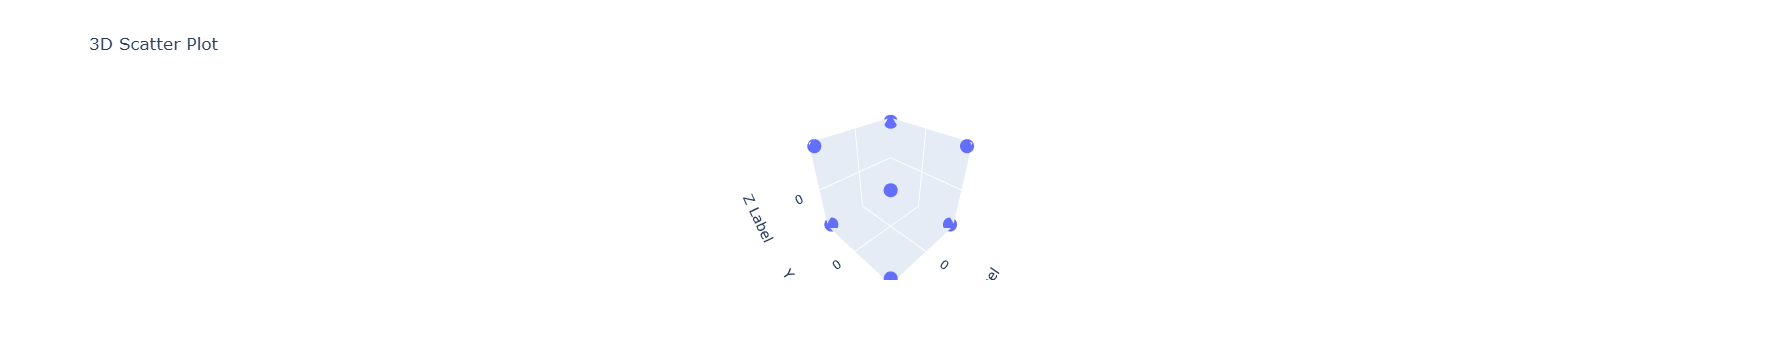

In [38]:
# Assuming df is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names
fig = px.scatter_3d(df_examp_stars, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 2)

# You can customize the labels for each axis
fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))

# Show the interactive plot
fig.show()

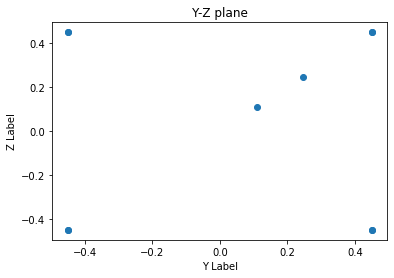

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_examp_stars['y'], df_examp_stars['z'])

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')


plt.title("Y-Z plane")
plt.show()

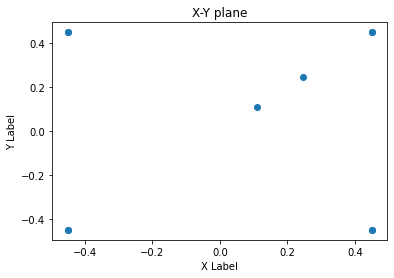

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_examp_stars['x'], df_examp_stars['y'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.title("X-Y plane")
plt.show()

In [60]:
#lets create the same example with dataframes
e = 0.25
v = (1+e)**0.5
examp_stars = [
      [1.0, 0,0,0,0,0,0],
      [1.0, 1,0,0,0,v,0],
]
column_names = ["mass","x","y","z","vx","vy","vz"]
df_2body = pd.DataFrame(examp_stars, columns=column_names)
df_2body

mass  x  y  z  vx        vy  vz
0   1.0  0  0  0   0  0.000000   0
1   1.0  1  0  0   0  1.118034   0

In [61]:
new_pos = [
            [2.0,2.0,2.0],
            [ 3.0,3.0,3.0],]

In [63]:
df_2body[['x', 'y', 'z']] = new_pos

In [64]:
df_2body

mass    x    y    z  vx        vy  vz
0   1.0  2.0  2.0  2.0   0  0.000000   0
1   1.0  3.0  3.0  3.0   0  1.118034   0

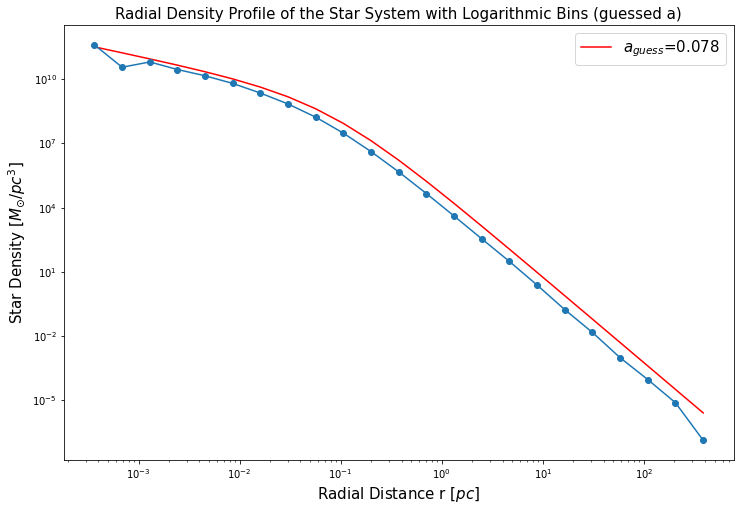

fixed mass profile scaling radius a value:0.07847778361950496 and pcov: 1.2440699983709611e-05


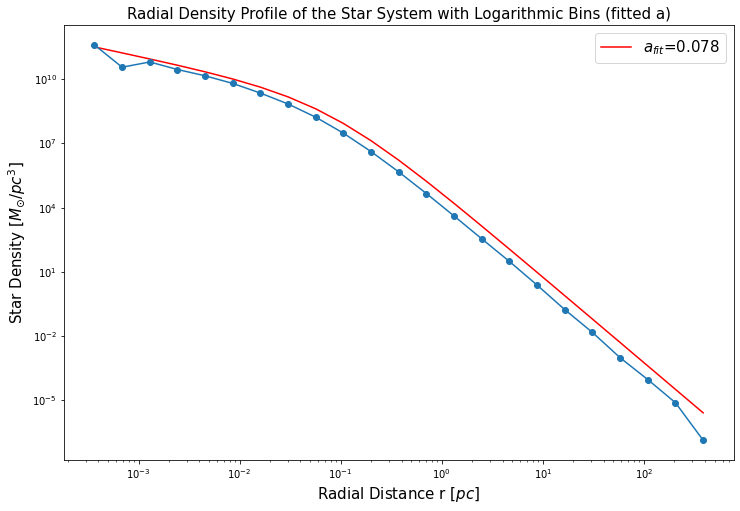

fixed mass profile scaling radius a value:0.0711812794142304 and pcov: 2.0210756181502142e-38


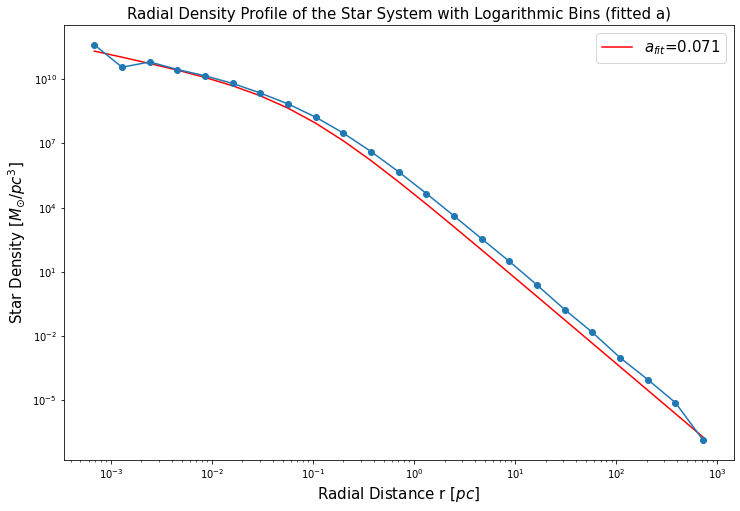

In [75]:
# define radial distances
radial_distances = df_stars["distance"]
# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 24)
#log_bins = np.logspace(np.log10(0.1), np.log10(200), 25)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell

# Star mass
lone_star_mass = df_stars["mass"].values[0]
# Calculate star density in each shell
star_density = hist*lone_star_mass / shell_volumes 
#with leftmost
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_guess)
#fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], 0.0778)
#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, label='$a_{guess}$'+f"={np.round(a_guess,3)}", color='red')

# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], star_density, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (guessed a)', fontsize = 15)
plt.show()

#fit with lectmost
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, p0=a_guess)

#if I would add the error it should be a better fit
#sigma=..... 
#sigma=1/np.sqrt(star_density) 
#a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,sigma = sigma, p0=a_guess, absolute_sigma = True)
print(f'fixed mass profile scaling radius a value:{a_fit[0]} and pcov: {pcov[0][0]}')


fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

yerr = star_density/np.sqrt(star_density)
#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, label='$a_{fit}$'+f"={np.round(a_fit[0],3)}", color='red')

#plt.errorbar(bin_edges[:-1], star_density, yerr=np.log10(yerr), color='C0', fmt='o', markersize=4, capsize=2)

#plt.errorbar(bin_edges[:-1], fixed_M_fitted_profile)
# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], star_density, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (fitted a)', fontsize = 15)
plt.show()

#excluding leftmost
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[1:], star_density,p0=a_guess)

#if I would add the error it should be a better fit
#sigma=np.sqrt(star_density) 
sigma=1/np.sqrt(star_density) 
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,sigma = sigma, p0=a_guess, absolute_sigma = True)
print(f'fixed mass profile scaling radius a value:{a_fit[0]} and pcov: {pcov[0][0]}')


fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[1:], a_fit)

yerr = star_density/np.sqrt(star_density)
#plot
plt.figure(figsize=(12, 8))
plt.plot(bin_edges[1:], fixed_M_fitted_profile, label='$a_{fit}$'+f"={np.round(a_fit[0],3)}", color='red')

#plt.errorbar(bin_edges[:-1], star_density, yerr=np.log10(yerr), color='C0', fmt='o', markersize=4, capsize=2)

#plt.errorbar(bin_edges[:-1], fixed_M_fitted_profile)
# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[1:], star_density, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.xlabel('Radial Distance r $[pc]$', fontsize = 15)
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]', fontsize = 15)
plt.title('Radial Density Profile of the Star System with Logarithmic Bins (fitted a)', fontsize = 15)
plt.show()

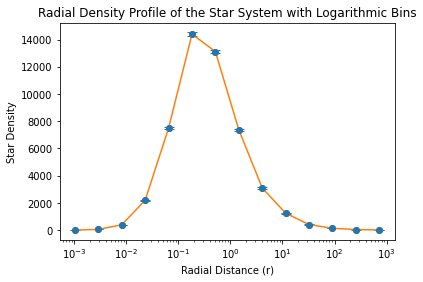

In [76]:
# define radial distances
radial_distances = df_stars["distance"]
# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 15)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
# Star mass
lone_star_mass = df_stars["mass"].values[0]

#a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[1:], star_density,p0=a_guess)

#star_density = hist * lone_star_mass / shell_volumes
#hist_fitted = (star_denisty_H * shell_volumes)/ lone_star_mass

#plot
#plt.plot(bin_edges[1:], fixed_M_fitted_profile, label='Fitted Henquist Profile', color='red')
# Plot the radial density profile with logarithmic bins
plt.errorbar(bin_edges[1:], hist, yerr=np.sqrt(hist), fmt='o', label='Observed Data with Error Bars',capsize=5)
plt.plot(bin_edges[1:], hist, marker='o')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins')
plt.show()

In [ ]:
###WORKING EXAMPLE OF BOTH INTEGRATORS
df_stars_sub = sample_stars(df_stars,nr_stars = 200)
#test_array = test_sample()

stars = df_stars_sub
#stars = test_array
#stars = test_df
N = stars.shape[0]
column_names = ["mass","x","y","z","vx","vy","vz"]

#time parameters
endTime = 0.1
dt = 0.01
# number of timesteps
num_steps = int(np.ceil(endTime/dt))


#first forces calculation direct
epsilon = 0.003
#forces = calculate_total_force(stars, epsilon = epsilon)#seq
forces = calculate_total_force_parallel_proc(stars, epsilon = epsilon)

#first forces calculation tree
opening_angle = 0.5
#forces = calculate_total_force(stars, epsilon = epsilon)#seq
#forces = Tree_forces(stars, thetamax = opening_angle, G = 1.)

#save for plotting
# save particle orbits for plotting trails
position_save = np.zeros((N, 3, num_steps+1))
position_save[:,:,0] = stars[["x","y","z"]]

#plot style
plt.style.use('dark_background')
for step in range(num_steps):
    #direct summation
    stars, forces = leapfrog_integration(stars, forces, dt,epsilon = epsilon)
    
    #tree code
    #stars, forces = leapfrog_integration_tree(stars, forces, dt, opening_angle = 0.5)
    
    # save positions for plotting trail
    position_save[:,:,step+1] = stars[["x","y","z"]]
    
    # clear the current figure
    plt.cla()
    #xp and yp are the trail left behind by the stars
    xp = position_save[:, 0, max(step-50,0):step+1]
    yp = position_save[:, 1, max(step-50,0):step+1]
    # plotting the trails
    plt.scatter(xp, yp, s=1, color = 'cornflowerblue')
    # plotting the objects
    plt.scatter(stars[["x","y","z"]].values[:,0], stars[["x","y","z"]].values[:,1], s=10, color ='white')
    plt.pause(0.001)

I was given a metric:

${ds}^2 = - (1+\frac{r^2}{l^2}){dt}^2 + (1+\frac{r^2}{l^2}){dr}^2 + {r}^2({d \theta}^2 + \sin^2 \theta d \phi^2) $

$l$- seemed to be some constant

a)find remaining geodesic equations(2 first were given):  
Do not have the first, so try to find all of them and it think you had to find them with the varying the action like in exercise sheet 9 ex 1

b)Find radial coordinate r as a function of proper time $\tau$ ($\tau \in [0, \pi l] $) assuming:  
    * worldline has initial condition $r(\tau = 0) = 0$ and $\frac{dr}{dt}(\tau = 0) = v$  
    *that the angular coordinates are constant $(\theta = const, \phi = const$) for $\tau \in [0, \pi l] $  
    
c)Bob is observer who is freely falling ($r = const > 0$) and $\theta = \frac{\pi}{2} = const$.  
Show that his wordline must be such that $\frac{d\phi}{dt}=k$ for some constant $k \in \mathbb{R} / \{0\}$ and determine all possible values of $k$'s